- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adagrad

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        50, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #model.add(Dense(64,activation='swish'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=Adagrad(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
4/4 [==============================] - 11s 227ms/step - loss: 0.7330 - accuracy: 0.4617 - auc_roc: 0.4501
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7250 - accuracy: 0.4780 - auc_roc: 0.4828
Epoch 3/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7019 - accuracy: 0.5084 - auc_roc: 0.5393
Epoch 4/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6889 - accuracy: 0.5337 - auc_roc: 0.5635
Epoch 5/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6757 - accuracy: 0.5566 - auc_roc: 0.6026
Epoch 6/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6671 - accuracy: 0.5872 - auc_roc: 0.6347
Epoch 7/200
4/4 [==============================] - 1s 250ms/step - loss: 0.6642 - accuracy: 0.5956 - auc_roc: 0.6337
Epo

4/4 [==============================] - 1s 213ms/step - loss: 0.5790 - accuracy: 0.7156 - auc_roc: 0.7674
Epoch 69/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5762 - accuracy: 0.7185 - auc_roc: 0.7705
Epoch 70/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5787 - accuracy: 0.7119 - auc_roc: 0.7715
Epoch 71/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5716 - accuracy: 0.7227 - auc_roc: 0.7766
Epoch 72/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5741 - accuracy: 0.7180 - auc_roc: 0.7769
Epoch 73/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5744 - accuracy: 0.7285 - auc_roc: 0.7733
Epoch 74/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5747 - accuracy: 0.7125 - auc_roc: 0.7667
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5806 - accuracy: 0.7147 - auc_roc: 0.7676
Epoch 76/200
4/4 [==============================] - 1s 280ms/step - l

4/4 [==============================] - 1s 215ms/step - loss: 0.5600 - accuracy: 0.7288 - auc_roc: 0.7850
Epoch 138/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5589 - accuracy: 0.7378 - auc_roc: 0.7865
Epoch 139/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5601 - accuracy: 0.7308 - auc_roc: 0.7880
Epoch 140/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5597 - accuracy: 0.7285 - auc_roc: 0.7855
Epoch 141/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5614 - accuracy: 0.7142 - auc_roc: 0.7797
Epoch 142/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5561 - accuracy: 0.7223 - auc_roc: 0.7835
Epoch 143/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5619 - accuracy: 0.7216 - auc_roc: 0.7862
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5743 - accuracy: 0.7067 - auc_roc: 0.7688
Epoch 145/200
4/4 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0002 Epoch 1/200
4/4 [==============================] - 11s 186ms/step - loss: 0.7333 - accuracy: 0.4695 - auc_roc: 0.6925
Epoch 2/200
4/4 [==============================] - 1s 137ms/step - loss: 0.7250 - accuracy: 0.4789 - auc_roc: 0.5109
Epoch 3/200
4/4 [==============================] - 1s 146ms/step - loss: 0.7157 - accuracy: 0.5092 - auc_roc: 0.5298
Epoch 4/200
4/4 [==============================] - 1s 169ms/step - loss: 0.6972 - accuracy: 0.5208 - auc_roc: 0.5582
Epoch 5/200
4/4 [==============================] - 1s 144ms/step - loss: 0.6847 - accuracy: 0.5452 - auc_roc: 0.5831
Epoch 6/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6750 - accuracy: 0.5719 - auc_roc: 0.6097
Epoch 7/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6736 - accuracy: 0.5738 - auc_roc: 0.6075
Epoch 8/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6648 - accuracy: 0.5932 - auc_roc: 0.6398
Epoch 9

4/4 [==============================] - 1s 241ms/step - loss: 0.5730 - accuracy: 0.7096 - auc_roc: 0.7773
Epoch 71/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5953 - accuracy: 0.6941 - auc_roc: 0.7493
Epoch 72/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5859 - accuracy: 0.6832 - auc_roc: 0.7520
Epoch 73/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5812 - accuracy: 0.7122 - auc_roc: 0.7651
Epoch 74/200
4/4 [==============================] - 1s 303ms/step - loss: 0.5840 - accuracy: 0.7013 - auc_roc: 0.7602
Epoch 75/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5890 - accuracy: 0.7116 - auc_roc: 0.7583
Epoch 76/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5870 - accuracy: 0.7028 - auc_roc: 0.7560
Epoch 77/200
4/4 [==============================] - 1s 303ms/step - loss: 0.5846 - accuracy: 0.7029 - auc_roc: 0.7599
Epoch 78/200
4/4 [==============================] - 1s 289ms/step - l

4/4 [==============================] - 1s 218ms/step - loss: 0.5731 - accuracy: 0.7136 - auc_roc: 0.7724
Epoch 140/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5738 - accuracy: 0.7139 - auc_roc: 0.7694
Epoch 141/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5697 - accuracy: 0.7155 - auc_roc: 0.7734
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5700 - accuracy: 0.7047 - auc_roc: 0.7767
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5670 - accuracy: 0.7115 - auc_roc: 0.7748
Epoch 144/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5740 - accuracy: 0.7126 - auc_roc: 0.7708
Epoch 145/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5683 - accuracy: 0.6998 - auc_roc: 0.7749
Epoch 146/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5719 - accuracy: 0.7067 - auc_roc: 0.7709
Epoch 147/200
4/4 [==============================] - 1s 228ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 44ms/step
0003 Epoch 1/200
4/4 [==============================] - 12s 153ms/step - loss: 0.7161 - accuracy: 0.5196 - auc_roc: 0.6969
Epoch 2/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6917 - accuracy: 0.5534 - auc_roc: 0.5667
Epoch 3/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6846 - accuracy: 0.5827 - auc_roc: 0.5886
Epoch 4/200
4/4 [==============================] - 1s 150ms/step - loss: 0.6719 - accuracy: 0.5946 - auc_roc: 0.6144
Epoch 5/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6595 - accuracy: 0.6300 - auc_roc: 0.6557
Epoch 6/200
4/4 [==============================] - 0s 115ms/step - loss: 0.6550 - accuracy: 0.6255 - auc_roc: 0.6637
Epoch 7/200
4/4 [==============================] - 1s 122ms/step - loss: 0.6436 - accuracy: 0.6355 - auc_roc: 0.6766
Epoch 8/200
4/4 [==============================] - 1s 118ms/step - loss: 0.6500 - accuracy: 0.6334 - auc_roc: 0.6639
Epoch 

4/4 [==============================] - 1s 281ms/step - loss: 0.5893 - accuracy: 0.7197 - auc_roc: 0.7632
Epoch 71/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5845 - accuracy: 0.7183 - auc_roc: 0.7690
Epoch 72/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5859 - accuracy: 0.7138 - auc_roc: 0.7667
Epoch 73/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5737 - accuracy: 0.7222 - auc_roc: 0.7778
Epoch 74/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5814 - accuracy: 0.7003 - auc_roc: 0.7620
Epoch 75/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5801 - accuracy: 0.7207 - auc_roc: 0.7707
Epoch 76/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5843 - accuracy: 0.7155 - auc_roc: 0.7691
Epoch 77/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5869 - accuracy: 0.7133 - auc_roc: 0.7669
Epoch 78/200
4/4 [==============================] - 1s 273ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.5790 - accuracy: 0.7177 - auc_roc: 0.7690
Epoch 140/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5729 - accuracy: 0.7298 - auc_roc: 0.7792
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5806 - accuracy: 0.7156 - auc_roc: 0.7728
Epoch 142/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5732 - accuracy: 0.7184 - auc_roc: 0.7766
Epoch 143/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5745 - accuracy: 0.7227 - auc_roc: 0.7760
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5705 - accuracy: 0.7158 - auc_roc: 0.7834
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5722 - accuracy: 0.7159 - auc_roc: 0.7737
Epoch 146/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5728 - accuracy: 0.7287 - auc_roc: 0.7777
Epoch 147/200
4/4 [==============================] - 1s 271ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 75ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0004 Epoch 1/200
4/4 [==============================] - 12s 105ms/step - loss: 0.6890 - accuracy: 0.5603 - auc_roc: 0.7168
Epoch 2/200
4/4 [==============================] - 0s 117ms/step - loss: 0.6895 - accuracy: 0.5643 - auc_roc: 0.5796
Epoch 3/200
4/4 [==============================] - 1s 128ms/step - loss: 0.6700 - accuracy: 0.5928 - auc_roc: 0.6294
Epoch 4/200
4/4 [==============================] - 0s 120ms/step - loss: 0.6675 - accuracy: 0.6059 - auc_roc: 0.6316
Epoch 5/200
4/4 [==============================] - 1s 113ms/step - loss: 0.6543 - accuracy: 0.6275 - auc_roc: 0.6564
Epoch 6/200
4/4 [==============================] - 1s 126ms/step - loss: 0.6472 - accuracy: 0.6304 - auc_roc: 0.6685
Epoch 7/200
4/4 [==============================] - 1s 141ms/step - loss: 0.6374 - accuracy: 0.6503 - auc_roc: 0.6910
Epoch 8/200
4/4 [==============================] - 0s 118ms/step - loss: 0.6329 - accuracy: 0.6588 - auc_roc: 0.7016
Epoch 9

4/4 [==============================] - 1s 267ms/step - loss: 0.5855 - accuracy: 0.7060 - auc_roc: 0.7588
Epoch 71/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5871 - accuracy: 0.6997 - auc_roc: 0.7580
Epoch 72/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5821 - accuracy: 0.7167 - auc_roc: 0.7628
Epoch 73/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5838 - accuracy: 0.7118 - auc_roc: 0.7659
Epoch 74/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5870 - accuracy: 0.7041 - auc_roc: 0.7604
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5884 - accuracy: 0.7231 - auc_roc: 0.7651
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5917 - accuracy: 0.7020 - auc_roc: 0.7530
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5934 - accuracy: 0.7131 - auc_roc: 0.7577
Epoch 78/200
4/4 [==============================] - 1s 288ms/step - l

4/4 [==============================] - 1s 251ms/step - loss: 0.5810 - accuracy: 0.7212 - auc_roc: 0.7677
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5872 - accuracy: 0.7049 - auc_roc: 0.7599
Epoch 141/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5794 - accuracy: 0.7207 - auc_roc: 0.7658
Epoch 142/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5811 - accuracy: 0.7137 - auc_roc: 0.7705
Epoch 143/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5749 - accuracy: 0.7162 - auc_roc: 0.7728
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5785 - accuracy: 0.7163 - auc_roc: 0.7655
Epoch 145/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5834 - accuracy: 0.7134 - auc_roc: 0.7652
Epoch 146/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5753 - accuracy: 0.7199 - auc_roc: 0.7758
Epoch 147/200
4/4 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0005 Epoch 1/200
4/4 [==============================] - 11s 165ms/step - loss: 0.6899 - accuracy: 0.5446 - auc_roc: 0.7127
Epoch 2/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6765 - accuracy: 0.5532 - auc_roc: 0.5997
Epoch 3/200
4/4 [==============================] - 1s 175ms/step - loss: 0.6653 - accuracy: 0.5756 - auc_roc: 0.6335
Epoch 4/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6594 - accuracy: 0.5925 - auc_roc: 0.6401
Epoch 5/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6525 - accuracy: 0.6021 - auc_roc: 0.6592
Epoch 6/200
4/4 [==============================] - 1s 190ms/step - loss: 0.6582 - accuracy: 0.6138 - auc_roc: 0.6602
Epoch 7/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6386 - accuracy: 0.6383 - auc_roc: 0.6901
Epoch 8/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6352 - accuracy: 0.6390 - auc_roc: 0.6971
Epoch 

4/4 [==============================] - 1s 248ms/step - loss: 0.5867 - accuracy: 0.7169 - auc_roc: 0.7704
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5778 - accuracy: 0.7116 - auc_roc: 0.7711
Epoch 72/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5795 - accuracy: 0.7127 - auc_roc: 0.7698
Epoch 73/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5719 - accuracy: 0.7127 - auc_roc: 0.7793
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5776 - accuracy: 0.7050 - auc_roc: 0.7731
Epoch 75/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5761 - accuracy: 0.7097 - auc_roc: 0.7732
Epoch 76/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5794 - accuracy: 0.7049 - auc_roc: 0.7719
Epoch 77/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5797 - accuracy: 0.7049 - auc_roc: 0.7702
Epoch 78/200
4/4 [==============================] - 1s 287ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.5604 - accuracy: 0.7249 - auc_roc: 0.7888
Epoch 140/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5573 - accuracy: 0.7225 - auc_roc: 0.7920
Epoch 141/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5661 - accuracy: 0.7095 - auc_roc: 0.7800
Epoch 142/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5614 - accuracy: 0.7145 - auc_roc: 0.7893
Epoch 143/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5697 - accuracy: 0.7080 - auc_roc: 0.7818
Epoch 144/200
4/4 [==============================] - 1s 156ms/step - loss: 0.5518 - accuracy: 0.7228 - auc_roc: 0.8026
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5668 - accuracy: 0.7071 - auc_roc: 0.7772
Epoch 146/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5611 - accuracy: 0.7214 - auc_roc: 0.7893
Epoch 147/200
4/4 [==============================] - 1s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 5s 143ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0006 Epoch 1/200
4/4 [==============================] - 14s 195ms/step - loss: 0.7780 - accuracy: 0.4875 - auc_roc: 0.6808
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7512 - accuracy: 0.5079 - auc_roc: 0.5032
Epoch 3/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7489 - accuracy: 0.5083 - auc_roc: 0.5003
Epoch 4/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7246 - accuracy: 0.5376 - auc_roc: 0.5467
Epoch 5/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7220 - accuracy: 0.5431 - auc_roc: 0.5535
Epoch 6/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6991 - accuracy: 0.5771 - auc_roc: 0.5862
Epoch 7/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6910 - accuracy: 0.5715 - auc_roc: 0.5967
Epoch 8/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6873 - accuracy: 0.5780 - auc_roc: 0.6016
Epoch 

4/4 [==============================] - 1s 182ms/step - loss: 0.5812 - accuracy: 0.7084 - auc_roc: 0.7680
Epoch 71/200
4/4 [==============================] - 1s 185ms/step - loss: 0.5905 - accuracy: 0.6908 - auc_roc: 0.7517
Epoch 72/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5748 - accuracy: 0.7117 - auc_roc: 0.7691
Epoch 73/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5865 - accuracy: 0.7036 - auc_roc: 0.7562
Epoch 74/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5876 - accuracy: 0.7033 - auc_roc: 0.7578
Epoch 75/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5834 - accuracy: 0.7088 - auc_roc: 0.7625
Epoch 76/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5861 - accuracy: 0.7081 - auc_roc: 0.7561
Epoch 77/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5854 - accuracy: 0.7149 - auc_roc: 0.7671
Epoch 78/200
4/4 [==============================] - 1s 170ms/step - l

4/4 [==============================] - 1s 221ms/step - loss: 0.5695 - accuracy: 0.7070 - auc_roc: 0.7797
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5739 - accuracy: 0.7105 - auc_roc: 0.7695
Epoch 141/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5601 - accuracy: 0.7195 - auc_roc: 0.7922
Epoch 142/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5605 - accuracy: 0.7192 - auc_roc: 0.7868
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5691 - accuracy: 0.7251 - auc_roc: 0.7760
Epoch 144/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5590 - accuracy: 0.7310 - auc_roc: 0.7922
Epoch 145/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5683 - accuracy: 0.7174 - auc_roc: 0.7791
Epoch 146/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5641 - accuracy: 0.7185 - auc_roc: 0.7820
Epoch 147/200
4/4 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 32ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 54ms/step
0007 Epoch 1/200
4/4 [==============================] - 14s 180ms/step - loss: 0.6616 - accuracy: 0.6136 - auc_roc: 0.7410
Epoch 2/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6460 - accuracy: 0.6440 - auc_roc: 0.7012
Epoch 3/200
4/4 [==============================] - 1s 181ms/step - loss: 0.6345 - accuracy: 0.6705 - auc_roc: 0.7237
Epoch 4/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6295 - accuracy: 0.6830 - auc_roc: 0.7303
Epoch 5/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6258 - accuracy: 0.6800 - auc_roc: 0.7346
Epoch 6/200
4/4 [==============================] - 1s 177ms/step - loss: 0.6221 - accuracy: 0.6607 - auc_roc: 0.7304
Epoch 7/200
4/4 [==============================] - 1s 161ms/step - loss: 0.6234 - accuracy: 0.6673 - auc_roc: 0.7255
Epoch 8/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6162 - accuracy: 0.6859 - auc_roc: 0.7410
Epoch 

4/4 [==============================] - 1s 238ms/step - loss: 0.5737 - accuracy: 0.7059 - auc_roc: 0.7708
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5662 - accuracy: 0.7064 - auc_roc: 0.7809
Epoch 72/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5711 - accuracy: 0.7077 - auc_roc: 0.7709
Epoch 73/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5758 - accuracy: 0.7069 - auc_roc: 0.7649
Epoch 74/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5781 - accuracy: 0.7176 - auc_roc: 0.7647
Epoch 75/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5810 - accuracy: 0.7066 - auc_roc: 0.7584
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5675 - accuracy: 0.7192 - auc_roc: 0.7757
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5699 - accuracy: 0.7111 - auc_roc: 0.7753
Epoch 78/200
4/4 [==============================] - 1s 199ms/step - l

4/4 [==============================] - 1s 210ms/step - loss: 0.5619 - accuracy: 0.7180 - auc_roc: 0.7833
Epoch 140/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5714 - accuracy: 0.7016 - auc_roc: 0.7710
Epoch 141/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5654 - accuracy: 0.7012 - auc_roc: 0.7770
Epoch 142/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5655 - accuracy: 0.7077 - auc_roc: 0.7748
Epoch 143/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5616 - accuracy: 0.7245 - auc_roc: 0.7801
Epoch 144/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5571 - accuracy: 0.7252 - auc_roc: 0.7852
Epoch 145/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5480 - accuracy: 0.7314 - auc_roc: 0.7967
Epoch 146/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5618 - accuracy: 0.7259 - auc_roc: 0.7828
Epoch 147/200
4/4 [==============================] - 1s 215ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0008 Epoch 1/200
4/4 [==============================] - 14s 233ms/step - loss: 0.7598 - accuracy: 0.4641 - auc_roc: 0.6751
Epoch 2/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7312 - accuracy: 0.4863 - auc_roc: 0.5095
Epoch 3/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7066 - accuracy: 0.5071 - auc_roc: 0.5420
Epoch 4/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7054 - accuracy: 0.5129 - auc_roc: 0.5387
Epoch 5/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6875 - accuracy: 0.5444 - auc_roc: 0.5796
Epoch 6/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6743 - accuracy: 0.5840 - auc_roc: 0.6125
Epoch 7/200
4/4 [==============================] - 1s 246ms/step - loss: 0.6659 - accuracy: 0.5713 - auc_roc: 0.6231
Epoch 8/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6566 - accuracy: 0.5998 - auc_roc: 0.6454
Epoch 

4/4 [==============================] - 1s 241ms/step - loss: 0.5837 - accuracy: 0.7173 - auc_roc: 0.7665
Epoch 71/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5791 - accuracy: 0.7178 - auc_roc: 0.7703
Epoch 72/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5873 - accuracy: 0.7081 - auc_roc: 0.7595
Epoch 73/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5787 - accuracy: 0.7051 - auc_roc: 0.7699
Epoch 74/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5780 - accuracy: 0.7210 - auc_roc: 0.7707
Epoch 75/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5762 - accuracy: 0.7232 - auc_roc: 0.7757
Epoch 76/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5789 - accuracy: 0.7212 - auc_roc: 0.7748
Epoch 77/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5795 - accuracy: 0.7123 - auc_roc: 0.7719
Epoch 78/200
4/4 [==============================] - 1s 254ms/step - l

4/4 [==============================] - 1s 204ms/step - loss: 0.5725 - accuracy: 0.7259 - auc_roc: 0.7754
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5698 - accuracy: 0.7228 - auc_roc: 0.7751
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5557 - accuracy: 0.7421 - auc_roc: 0.7908
Epoch 142/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5674 - accuracy: 0.7279 - auc_roc: 0.7834
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5721 - accuracy: 0.7245 - auc_roc: 0.7778
Epoch 144/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5662 - accuracy: 0.7243 - auc_roc: 0.7813
Epoch 145/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5657 - accuracy: 0.7334 - auc_roc: 0.7829
Epoch 146/200
4/4 [==============================] - 1s 302ms/step - loss: 0.5746 - accuracy: 0.7174 - auc_roc: 0.7743
Epoch 147/200
4/4 [==============================] - 1s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 49ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0009 Epoch 1/200
4/4 [==============================] - 15s 224ms/step - loss: 0.6713 - accuracy: 0.5708 - auc_roc: 0.7290
Epoch 2/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6607 - accuracy: 0.6039 - auc_roc: 0.6524
Epoch 3/200
4/4 [==============================] - 1s 249ms/step - loss: 0.6557 - accuracy: 0.6082 - auc_roc: 0.6593
Epoch 4/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6526 - accuracy: 0.6277 - auc_roc: 0.6731
Epoch 5/200
4/4 [==============================] - 1s 190ms/step - loss: 0.6464 - accuracy: 0.6233 - auc_roc: 0.6844
Epoch 6/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6337 - accuracy: 0.6610 - auc_roc: 0.7087
Epoch 7/200
4/4 [==============================] - 1s 198ms/step - loss: 0.6392 - accuracy: 0.6525 - auc_roc: 0.6925
Epoch 8/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6241 - accuracy: 0.6792 - auc_roc: 0.7317
Epoch 

4/4 [==============================] - 1s 286ms/step - loss: 0.5776 - accuracy: 0.7076 - auc_roc: 0.7691
Epoch 71/200
4/4 [==============================] - 1s 316ms/step - loss: 0.5715 - accuracy: 0.7166 - auc_roc: 0.7751
Epoch 72/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5837 - accuracy: 0.7138 - auc_roc: 0.7653
Epoch 73/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5784 - accuracy: 0.7121 - auc_roc: 0.7695
Epoch 74/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5782 - accuracy: 0.7141 - auc_roc: 0.7676
Epoch 75/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5940 - accuracy: 0.6987 - auc_roc: 0.7519
Epoch 76/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5824 - accuracy: 0.7239 - auc_roc: 0.7665
Epoch 77/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5854 - accuracy: 0.7076 - auc_roc: 0.7626
Epoch 78/200
4/4 [==============================] - 1s 277ms/step - l

4/4 [==============================] - 1s 226ms/step - loss: 0.5761 - accuracy: 0.7167 - auc_roc: 0.7708
Epoch 140/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5780 - accuracy: 0.7149 - auc_roc: 0.7690
Epoch 141/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5674 - accuracy: 0.7181 - auc_roc: 0.7804
Epoch 142/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5656 - accuracy: 0.7232 - auc_roc: 0.7806
Epoch 143/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5694 - accuracy: 0.7245 - auc_roc: 0.7790
Epoch 144/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5721 - accuracy: 0.7142 - auc_roc: 0.7752
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5691 - accuracy: 0.7301 - auc_roc: 0.7793
Epoch 146/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5597 - accuracy: 0.7176 - auc_roc: 0.7843
Epoch 147/200
4/4 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0010 Epoch 1/200
4/4 [==============================] - 13s 250ms/step - loss: 0.7426 - accuracy: 0.4959 - auc_roc: 0.6862
Epoch 2/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7228 - accuracy: 0.5070 - auc_roc: 0.5253
Epoch 3/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7051 - accuracy: 0.5430 - auc_roc: 0.5618
Epoch 4/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6921 - accuracy: 0.5677 - auc_roc: 0.5855
Epoch 5/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6727 - accuracy: 0.6145 - auc_roc: 0.6333
Epoch 6/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6749 - accuracy: 0.5947 - auc_roc: 0.6281
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6701 - accuracy: 0.6118 - auc_roc: 0.6400
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6551 - accuracy: 0.6363 - auc_roc: 0.6675
Epoch 9

4/4 [==============================] - 1s 225ms/step - loss: 0.5784 - accuracy: 0.7077 - auc_roc: 0.7714
Epoch 71/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5856 - accuracy: 0.7061 - auc_roc: 0.7627
Epoch 72/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5891 - accuracy: 0.7115 - auc_roc: 0.7613
Epoch 73/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5764 - accuracy: 0.7230 - auc_roc: 0.7787
Epoch 74/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5926 - accuracy: 0.7044 - auc_roc: 0.7565
Epoch 75/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5893 - accuracy: 0.7023 - auc_roc: 0.7618
Epoch 76/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5874 - accuracy: 0.6976 - auc_roc: 0.7635
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5858 - accuracy: 0.7063 - auc_roc: 0.7666
Epoch 78/200
4/4 [==============================] - 1s 229ms/step - l

4/4 [==============================] - 1s 255ms/step - loss: 0.5717 - accuracy: 0.7093 - auc_roc: 0.7749
Epoch 140/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5694 - accuracy: 0.7203 - auc_roc: 0.7828
Epoch 141/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5690 - accuracy: 0.7163 - auc_roc: 0.7810
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5726 - accuracy: 0.7118 - auc_roc: 0.7765
Epoch 143/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5722 - accuracy: 0.7164 - auc_roc: 0.7798
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5796 - accuracy: 0.7050 - auc_roc: 0.7708
Epoch 145/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5740 - accuracy: 0.7048 - auc_roc: 0.7749
Epoch 146/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5681 - accuracy: 0.7179 - auc_roc: 0.7829
Epoch 147/200
4/4 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 70ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 50ms/step
0011 Epoch 1/200
4/4 [==============================] - 12s 191ms/step - loss: 0.8871 - accuracy: 0.3093 - auc_roc: 0.6099
Epoch 2/200
4/4 [==============================] - 1s 216ms/step - loss: 0.8341 - accuracy: 0.3584 - auc_roc: 0.3136
Epoch 3/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7951 - accuracy: 0.3546 - auc_roc: 0.3250
Epoch 4/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7723 - accuracy: 0.3884 - auc_roc: 0.3573
Epoch 5/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7500 - accuracy: 0.4286 - auc_roc: 0.3981
Epoch 6/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7260 - accuracy: 0.4638 - auc_roc: 0.4486
Epoch 7/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7114 - accuracy: 0.5062 - auc_roc: 0.5052
Epoch 8/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6978 - accuracy: 0.5290 - auc_roc: 0.5465
Epoch 

4/4 [==============================] - 1s 249ms/step - loss: 0.5779 - accuracy: 0.7076 - auc_roc: 0.7734
Epoch 71/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5847 - accuracy: 0.7088 - auc_roc: 0.7626
Epoch 72/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5801 - accuracy: 0.7224 - auc_roc: 0.7707
Epoch 73/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5837 - accuracy: 0.7205 - auc_roc: 0.7632
Epoch 74/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5778 - accuracy: 0.7234 - auc_roc: 0.7746
Epoch 75/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5883 - accuracy: 0.7025 - auc_roc: 0.7603
Epoch 76/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5835 - accuracy: 0.7039 - auc_roc: 0.7667
Epoch 77/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5853 - accuracy: 0.7049 - auc_roc: 0.7649
Epoch 78/200
4/4 [==============================] - 1s 233ms/step - l

4/4 [==============================] - 1s 234ms/step - loss: 0.5739 - accuracy: 0.7265 - auc_roc: 0.7797
Epoch 140/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5627 - accuracy: 0.7137 - auc_roc: 0.7859
Epoch 141/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5640 - accuracy: 0.7210 - auc_roc: 0.7854
Epoch 142/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5687 - accuracy: 0.7226 - auc_roc: 0.7817
Epoch 143/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5687 - accuracy: 0.7080 - auc_roc: 0.7767
Epoch 144/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5619 - accuracy: 0.7169 - auc_roc: 0.7870
Epoch 145/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5707 - accuracy: 0.7085 - auc_roc: 0.7752
Epoch 146/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5577 - accuracy: 0.7230 - auc_roc: 0.7921
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0012 Epoch 1/200
4/4 [==============================] - 16s 231ms/step - loss: 0.7421 - accuracy: 0.4585 - auc_roc: 0.6801
Epoch 2/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7205 - accuracy: 0.4929 - auc_roc: 0.4963
Epoch 3/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7042 - accuracy: 0.5250 - auc_roc: 0.5325
Epoch 4/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6821 - accuracy: 0.5636 - auc_roc: 0.5937
Epoch 5/200
4/4 [==============================] - 1s 265ms/step - loss: 0.6731 - accuracy: 0.5826 - auc_roc: 0.6120
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6669 - accuracy: 0.5830 - auc_roc: 0.6236
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6526 - accuracy: 0.6229 - auc_roc: 0.6596
Epoch 8/200
4/4 [==============================] - 1s 206ms/step - loss: 0.6508 - accuracy: 0.6151 - auc_roc: 0.6578
Epoch 9

4/4 [==============================] - 1s 258ms/step - loss: 0.5835 - accuracy: 0.6987 - auc_roc: 0.7507
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5910 - accuracy: 0.6925 - auc_roc: 0.7502
Epoch 72/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5989 - accuracy: 0.7000 - auc_roc: 0.7408
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5909 - accuracy: 0.7070 - auc_roc: 0.7603
Epoch 74/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5850 - accuracy: 0.7079 - auc_roc: 0.7601
Epoch 75/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5783 - accuracy: 0.7091 - auc_roc: 0.7638
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5764 - accuracy: 0.7076 - auc_roc: 0.7668
Epoch 77/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5787 - accuracy: 0.7005 - auc_roc: 0.7623
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 206ms/step - loss: 0.5705 - accuracy: 0.7161 - auc_roc: 0.7737
Epoch 140/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5673 - accuracy: 0.7207 - auc_roc: 0.7753
Epoch 141/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5760 - accuracy: 0.7101 - auc_roc: 0.7652
Epoch 142/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5636 - accuracy: 0.7107 - auc_roc: 0.7760
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5715 - accuracy: 0.7124 - auc_roc: 0.7705
Epoch 144/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5692 - accuracy: 0.7057 - auc_roc: 0.7757
Epoch 145/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5676 - accuracy: 0.7194 - auc_roc: 0.7741
Epoch 146/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5677 - accuracy: 0.7115 - auc_roc: 0.7755
Epoch 147/200
4/4 [==============================] - 1s 196ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0013 Epoch 1/200
4/4 [==============================] - 12s 176ms/step - loss: 0.7177 - accuracy: 0.5389 - auc_roc: 0.6997
Epoch 2/200
4/4 [==============================] - 1s 184ms/step - loss: 0.6906 - accuracy: 0.5769 - auc_roc: 0.6051
Epoch 3/200
4/4 [==============================] - 1s 144ms/step - loss: 0.6822 - accuracy: 0.5737 - auc_roc: 0.5985
Epoch 4/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6651 - accuracy: 0.6116 - auc_roc: 0.6352
Epoch 5/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6445 - accuracy: 0.6580 - auc_roc: 0.6811
Epoch 6/200
4/4 [==============================] - 1s 152ms/step - loss: 0.6419 - accuracy: 0.6396 - auc_roc: 0.6837
Epoch 7/200
4/4 [==============================] - 1s 175ms/step - loss: 0.6287 - accuracy: 0.6628 - auc_roc: 0.7037
Epoch 8/200
4/4 [==============================] - 1s 183ms/step - loss: 0.6264 - accuracy: 0.6788 - auc_roc: 0.7093
Epoch 9

4/4 [==============================] - 1s 253ms/step - loss: 0.5589 - accuracy: 0.7155 - auc_roc: 0.7851
Epoch 71/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5544 - accuracy: 0.7180 - auc_roc: 0.7842
Epoch 72/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5579 - accuracy: 0.7211 - auc_roc: 0.7873
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5611 - accuracy: 0.7187 - auc_roc: 0.7806
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5546 - accuracy: 0.7216 - auc_roc: 0.7904
Epoch 75/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5496 - accuracy: 0.7260 - auc_roc: 0.7931
Epoch 76/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5530 - accuracy: 0.7303 - auc_roc: 0.7919
Epoch 77/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5489 - accuracy: 0.7286 - auc_roc: 0.7945
Epoch 78/200
4/4 [==============================] - 1s 202ms/step - l

4/4 [==============================] - 1s 208ms/step - loss: 0.5527 - accuracy: 0.7222 - auc_roc: 0.7882
Epoch 140/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5449 - accuracy: 0.7278 - auc_roc: 0.7922
Epoch 141/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5422 - accuracy: 0.7264 - auc_roc: 0.8000
Epoch 142/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5489 - accuracy: 0.7245 - auc_roc: 0.7953
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5350 - accuracy: 0.7464 - auc_roc: 0.8047
Epoch 144/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5384 - accuracy: 0.7268 - auc_roc: 0.8018
Epoch 145/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5342 - accuracy: 0.7365 - auc_roc: 0.8072
Epoch 146/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5507 - accuracy: 0.7141 - auc_roc: 0.7924
Epoch 147/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0014 Epoch 1/200
4/4 [==============================] - 8s 145ms/step - loss: 0.7276 - accuracy: 0.4618 - auc_roc: 0.7009
Epoch 2/200
4/4 [==============================] - 1s 147ms/step - loss: 0.7008 - accuracy: 0.5188 - auc_roc: 0.5404
Epoch 3/200
4/4 [==============================] - 1s 126ms/step - loss: 0.6827 - accuracy: 0.5649 - auc_roc: 0.5820
Epoch 4/200
4/4 [==============================] - 1s 141ms/step - loss: 0.6619 - accuracy: 0.6027 - auc_roc: 0.6428
Epoch 5/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6553 - accuracy: 0.6011 - auc_roc: 0.6485
Epoch 6/200
4/4 [==============================] - 1s 175ms/step - loss: 0.6396 - accuracy: 0.6256 - auc_roc: 0.6812
Epoch 7/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6398 - accuracy: 0.6376 - auc_roc: 0.6901
Epoch 8/200
4/4 [==============================] - 1s 155ms/step - loss: 0.6302 - accuracy: 0.6599 - auc_roc: 0.7002
Epoch 9

4/4 [==============================] - 1s 244ms/step - loss: 0.5628 - accuracy: 0.7247 - auc_roc: 0.7738
Epoch 71/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5514 - accuracy: 0.7274 - auc_roc: 0.7894
Epoch 72/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5591 - accuracy: 0.7198 - auc_roc: 0.7822
Epoch 73/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5594 - accuracy: 0.7231 - auc_roc: 0.7849
Epoch 74/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5679 - accuracy: 0.7147 - auc_roc: 0.7719
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5762 - accuracy: 0.7156 - auc_roc: 0.7672
Epoch 76/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5551 - accuracy: 0.7240 - auc_roc: 0.7862
Epoch 77/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5753 - accuracy: 0.6974 - auc_roc: 0.7603
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 270ms/step - loss: 0.5472 - accuracy: 0.7240 - auc_roc: 0.7892
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5527 - accuracy: 0.7139 - auc_roc: 0.7831
Epoch 141/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5558 - accuracy: 0.7235 - auc_roc: 0.7807
Epoch 142/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5524 - accuracy: 0.7197 - auc_roc: 0.7872
Epoch 143/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5430 - accuracy: 0.7258 - auc_roc: 0.7944
Epoch 144/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5488 - accuracy: 0.7256 - auc_roc: 0.7896
Epoch 145/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5557 - accuracy: 0.7237 - auc_roc: 0.7829
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5417 - accuracy: 0.7228 - auc_roc: 0.7959
Epoch 147/200
4/4 [==============================] - 1s 263ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0015 Epoch 1/200
4/4 [==============================] - 11s 179ms/step - loss: 0.6621 - accuracy: 0.5867 - auc_roc: 0.7397
Epoch 2/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6515 - accuracy: 0.6140 - auc_roc: 0.6741
Epoch 3/200
4/4 [==============================] - 1s 189ms/step - loss: 0.6536 - accuracy: 0.6104 - auc_roc: 0.6648
Epoch 4/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6290 - accuracy: 0.6455 - auc_roc: 0.7105
Epoch 5/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6446 - accuracy: 0.6456 - auc_roc: 0.6931
Epoch 6/200
4/4 [==============================] - 1s 136ms/step - loss: 0.6255 - accuracy: 0.6538 - auc_roc: 0.7143
Epoch 7/200
4/4 [==============================] - 1s 153ms/step - loss: 0.6188 - accuracy: 0.6585 - auc_roc: 0.7223
Epoch 8/200
4/4 [==============================] - 1s 171ms/step - loss: 0.6116 - accuracy: 0.6799 - auc_roc: 0.7387
Epoch 

4/4 [==============================] - 1s 247ms/step - loss: 0.5725 - accuracy: 0.7176 - auc_roc: 0.7785
Epoch 71/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5613 - accuracy: 0.7230 - auc_roc: 0.7911
Epoch 72/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5652 - accuracy: 0.7145 - auc_roc: 0.7830
Epoch 73/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5526 - accuracy: 0.7318 - auc_roc: 0.7995
Epoch 74/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5510 - accuracy: 0.7349 - auc_roc: 0.7990
Epoch 75/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5596 - accuracy: 0.7317 - auc_roc: 0.7910
Epoch 76/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5541 - accuracy: 0.7297 - auc_roc: 0.7947
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5601 - accuracy: 0.7298 - auc_roc: 0.7899
Epoch 78/200
4/4 [==============================] - 1s 203ms/step - l

4/4 [==============================] - 1s 251ms/step - loss: 0.5431 - accuracy: 0.7350 - auc_roc: 0.8032
Epoch 140/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5421 - accuracy: 0.7430 - auc_roc: 0.8044
Epoch 141/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5510 - accuracy: 0.7223 - auc_roc: 0.7942
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5474 - accuracy: 0.7386 - auc_roc: 0.8020
Epoch 143/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5485 - accuracy: 0.7334 - auc_roc: 0.7995
Epoch 144/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5558 - accuracy: 0.7258 - auc_roc: 0.7957
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5498 - accuracy: 0.7399 - auc_roc: 0.8004
Epoch 146/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5464 - accuracy: 0.7362 - auc_roc: 0.8048
Epoch 147/200
4/4 [==============================] - 1s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 130ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0016 Epoch 1/200
4/4 [==============================] - 13s 177ms/step - loss: 0.6327 - accuracy: 0.6338 - auc_roc: 0.7677
Epoch 2/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6324 - accuracy: 0.6478 - auc_roc: 0.7002
Epoch 3/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6282 - accuracy: 0.6562 - auc_roc: 0.7079
Epoch 4/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6309 - accuracy: 0.6563 - auc_roc: 0.6985
Epoch 5/200
4/4 [==============================] - 1s 157ms/step - loss: 0.6203 - accuracy: 0.6633 - auc_roc: 0.7178
Epoch 6/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6140 - accuracy: 0.6833 - auc_roc: 0.7315
Epoch 7/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6214 - accuracy: 0.6823 - auc_roc: 0.7256
Epoch 8/200
4/4 [==============================] - 1s 140ms/step - loss: 0.6180 - accuracy: 0.6718 - auc_roc: 0.7231
Epoch 

4/4 [==============================] - 1s 236ms/step - loss: 0.5710 - accuracy: 0.7215 - auc_roc: 0.7790
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5661 - accuracy: 0.7240 - auc_roc: 0.7850
Epoch 72/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5680 - accuracy: 0.7138 - auc_roc: 0.7780
Epoch 73/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5709 - accuracy: 0.7205 - auc_roc: 0.7827
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5718 - accuracy: 0.7208 - auc_roc: 0.7807
Epoch 75/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5678 - accuracy: 0.7150 - auc_roc: 0.7831
Epoch 76/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5706 - accuracy: 0.7279 - auc_roc: 0.7810
Epoch 77/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5570 - accuracy: 0.7219 - auc_roc: 0.7933
Epoch 78/200
4/4 [==============================] - 1s 225ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.5572 - accuracy: 0.7302 - auc_roc: 0.7902
Epoch 140/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5623 - accuracy: 0.7226 - auc_roc: 0.7865
Epoch 141/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5574 - accuracy: 0.7298 - auc_roc: 0.7912
Epoch 142/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5643 - accuracy: 0.7211 - auc_roc: 0.7829
Epoch 143/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5616 - accuracy: 0.7257 - auc_roc: 0.7863
Epoch 144/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5644 - accuracy: 0.7256 - auc_roc: 0.7865
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5551 - accuracy: 0.7233 - auc_roc: 0.7935
Epoch 146/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5569 - accuracy: 0.7291 - auc_roc: 0.7923
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0017 Epoch 1/200
4/4 [==============================] - 14s 187ms/step - loss: 0.7212 - accuracy: 0.4824 - auc_roc: 0.6969
Epoch 2/200
4/4 [==============================] - 1s 157ms/step - loss: 0.7054 - accuracy: 0.5197 - auc_roc: 0.5403
Epoch 3/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6950 - accuracy: 0.5384 - auc_roc: 0.5574
Epoch 4/200
4/4 [==============================] - 1s 153ms/step - loss: 0.6802 - accuracy: 0.5518 - auc_roc: 0.5880
Epoch 5/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6651 - accuracy: 0.5897 - auc_roc: 0.6269
Epoch 6/200
4/4 [==============================] - 1s 151ms/step - loss: 0.6562 - accuracy: 0.5998 - auc_roc: 0.6520
Epoch 7/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6409 - accuracy: 0.6312 - auc_roc: 0.6880
Epoch 8/200
4/4 [==============================] - 1s 160ms/step - loss: 0.6480 - accuracy: 0.6328 - auc_roc: 0.6693
Epoch 

4/4 [==============================] - 1s 215ms/step - loss: 0.5898 - accuracy: 0.7006 - auc_roc: 0.7479
Epoch 71/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5865 - accuracy: 0.6974 - auc_roc: 0.7514
Epoch 72/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5800 - accuracy: 0.6994 - auc_roc: 0.7605
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5745 - accuracy: 0.7162 - auc_roc: 0.7752
Epoch 74/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5820 - accuracy: 0.7026 - auc_roc: 0.7575
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5952 - accuracy: 0.6895 - auc_roc: 0.7447
Epoch 76/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5791 - accuracy: 0.7167 - auc_roc: 0.7659
Epoch 77/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5808 - accuracy: 0.7093 - auc_roc: 0.7599
Epoch 78/200
4/4 [==============================] - 1s 277ms/step - l

4/4 [==============================] - 1s 240ms/step - loss: 0.5720 - accuracy: 0.7189 - auc_roc: 0.7674
Epoch 140/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5793 - accuracy: 0.7033 - auc_roc: 0.7573
Epoch 141/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5695 - accuracy: 0.7126 - auc_roc: 0.7754
Epoch 142/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5756 - accuracy: 0.7109 - auc_roc: 0.7709
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5762 - accuracy: 0.7086 - auc_roc: 0.7710
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5683 - accuracy: 0.7137 - auc_roc: 0.7751
Epoch 145/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5718 - accuracy: 0.7229 - auc_roc: 0.7721
Epoch 146/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5750 - accuracy: 0.7144 - auc_roc: 0.7698
Epoch 147/200
4/4 [==============================] - 1s 287ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0018 Epoch 1/200
4/4 [==============================] - 14s 214ms/step - loss: 0.6702 - accuracy: 0.5916 - auc_roc: 0.7328
Epoch 2/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6664 - accuracy: 0.6238 - auc_roc: 0.6613
Epoch 3/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6467 - accuracy: 0.6485 - auc_roc: 0.7002
Epoch 4/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6308 - accuracy: 0.6614 - auc_roc: 0.7260
Epoch 5/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6268 - accuracy: 0.6712 - auc_roc: 0.7290
Epoch 6/200
4/4 [==============================] - 1s 166ms/step - loss: 0.6269 - accuracy: 0.6801 - auc_roc: 0.7308
Epoch 7/200
4/4 [==============================] - 1s 196ms/step - loss: 0.6236 - accuracy: 0.6768 - auc_roc: 0.7338
Epoch 8/200
4/4 [==============================] - 1s 175ms/step - loss: 0.6186 - accuracy: 0.6800 - auc_roc: 0.7416
Epoch 

4/4 [==============================] - 1s 209ms/step - loss: 0.5575 - accuracy: 0.7341 - auc_roc: 0.7978
Epoch 71/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5516 - accuracy: 0.7346 - auc_roc: 0.7997
Epoch 72/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5597 - accuracy: 0.7308 - auc_roc: 0.7911
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5540 - accuracy: 0.7255 - auc_roc: 0.7976
Epoch 74/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5525 - accuracy: 0.7329 - auc_roc: 0.7998
Epoch 75/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5552 - accuracy: 0.7349 - auc_roc: 0.7974
Epoch 76/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5633 - accuracy: 0.7169 - auc_roc: 0.7880
Epoch 77/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5630 - accuracy: 0.7245 - auc_roc: 0.7939
Epoch 78/200
4/4 [==============================] - 1s 223ms/step - l

4/4 [==============================] - 1s 272ms/step - loss: 0.5441 - accuracy: 0.7320 - auc_roc: 0.8043
Epoch 139/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5432 - accuracy: 0.7426 - auc_roc: 0.8054
Epoch 140/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5433 - accuracy: 0.7362 - auc_roc: 0.8048
Epoch 141/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5491 - accuracy: 0.7391 - auc_roc: 0.8032
Epoch 142/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5415 - accuracy: 0.7389 - auc_roc: 0.8080
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5452 - accuracy: 0.7293 - auc_roc: 0.7990
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5457 - accuracy: 0.7350 - auc_roc: 0.8040
Epoch 145/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5496 - accuracy: 0.7333 - auc_roc: 0.7988
Epoch 146/200
4/4 [==============================] - 1s 241ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0019 Epoch 1/200
4/4 [==============================] - 25s 196ms/step - loss: 0.6516 - accuracy: 0.6057 - auc_roc: 0.7614
Epoch 2/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6418 - accuracy: 0.6231 - auc_roc: 0.6735
Epoch 3/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6390 - accuracy: 0.6358 - auc_roc: 0.6792
Epoch 4/200
4/4 [==============================] - 1s 166ms/step - loss: 0.6363 - accuracy: 0.6350 - auc_roc: 0.6903
Epoch 5/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6270 - accuracy: 0.6371 - auc_roc: 0.7014
Epoch 6/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6215 - accuracy: 0.6468 - auc_roc: 0.7156
Epoch 7/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6175 - accuracy: 0.6679 - auc_roc: 0.7234
Epoch 8/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6086 - accuracy: 0.6745 - auc_roc: 0.7345
Epoch 

4/4 [==============================] - 1s 191ms/step - loss: 0.5642 - accuracy: 0.7156 - auc_roc: 0.7769
Epoch 71/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5619 - accuracy: 0.7117 - auc_roc: 0.7795
Epoch 72/200
4/4 [==============================] - 1s 166ms/step - loss: 0.5731 - accuracy: 0.7020 - auc_roc: 0.7644
Epoch 73/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5640 - accuracy: 0.7258 - auc_roc: 0.7760
Epoch 74/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5553 - accuracy: 0.7243 - auc_roc: 0.7837
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5610 - accuracy: 0.7216 - auc_roc: 0.7811
Epoch 76/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5524 - accuracy: 0.7299 - auc_roc: 0.7885
Epoch 77/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5672 - accuracy: 0.7100 - auc_roc: 0.7747
Epoch 78/200
4/4 [==============================] - 1s 209ms/step - l

4/4 [==============================] - 1s 162ms/step - loss: 0.5430 - accuracy: 0.7300 - auc_roc: 0.7948
Epoch 140/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5447 - accuracy: 0.7429 - auc_roc: 0.7928
Epoch 141/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5502 - accuracy: 0.7239 - auc_roc: 0.7885
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5639 - accuracy: 0.7170 - auc_roc: 0.7763
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5472 - accuracy: 0.7269 - auc_roc: 0.7933
Epoch 144/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5517 - accuracy: 0.7238 - auc_roc: 0.7888
Epoch 145/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5430 - accuracy: 0.7371 - auc_roc: 0.7953
Epoch 146/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5550 - accuracy: 0.7233 - auc_roc: 0.7858
Epoch 147/200
4/4 [==============================] - 1s 226ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 84ms/step
0020 Epoch 1/200
4/4 [==============================] - 16s 235ms/step - loss: 0.7454 - accuracy: 0.5068 - auc_roc: 0.6897
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7269 - accuracy: 0.5306 - auc_roc: 0.5292
Epoch 3/200
4/4 [==============================] - 1s 185ms/step - loss: 0.7122 - accuracy: 0.5448 - auc_roc: 0.5580
Epoch 4/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6876 - accuracy: 0.5871 - auc_roc: 0.6092
Epoch 5/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6847 - accuracy: 0.5940 - auc_roc: 0.6135
Epoch 6/200
4/4 [==============================] - 1s 181ms/step - loss: 0.6778 - accuracy: 0.6061 - auc_roc: 0.6383
Epoch 7/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6625 - accuracy: 0.6232 - auc_roc: 0.6628
Epoch 8/200
4/4 [==============================] - 1s 159ms/step - loss: 0.6622 - accuracy: 0.6355 - auc_roc: 0.6685
Epoch 

4/4 [==============================] - 1s 207ms/step - loss: 0.5792 - accuracy: 0.7202 - auc_roc: 0.7749
Epoch 71/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5791 - accuracy: 0.7288 - auc_roc: 0.7770
Epoch 72/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5872 - accuracy: 0.7091 - auc_roc: 0.7608
Epoch 73/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5793 - accuracy: 0.7094 - auc_roc: 0.7725
Epoch 74/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5740 - accuracy: 0.7280 - auc_roc: 0.7830
Epoch 75/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5828 - accuracy: 0.7013 - auc_roc: 0.7690
Epoch 76/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5734 - accuracy: 0.7264 - auc_roc: 0.7804
Epoch 77/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5839 - accuracy: 0.7178 - auc_roc: 0.7706
Epoch 78/200
4/4 [==============================] - 1s 173ms/step - l

4/4 [==============================] - 1s 221ms/step - loss: 0.5652 - accuracy: 0.7226 - auc_roc: 0.7872
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5544 - accuracy: 0.7387 - auc_roc: 0.8003
Epoch 141/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5579 - accuracy: 0.7323 - auc_roc: 0.7949
Epoch 142/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5553 - accuracy: 0.7384 - auc_roc: 0.7989
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5563 - accuracy: 0.7312 - auc_roc: 0.7940
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5563 - accuracy: 0.7310 - auc_roc: 0.7945
Epoch 145/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5633 - accuracy: 0.7389 - auc_roc: 0.7899
Epoch 146/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5571 - accuracy: 0.7313 - auc_roc: 0.7952
Epoch 147/200
4/4 [==============================] - 1s 206ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


1/2 [==============>...............] - ETA: 0s

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 78ms/step
0021 Epoch 1/200
4/4 [==============================] - 14s 244ms/step - loss: 0.7768 - accuracy: 0.4801 - auc_roc: 0.6760
Epoch 2/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7484 - accuracy: 0.4991 - auc_roc: 0.4833
Epoch 3/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7272 - accuracy: 0.5403 - auc_roc: 0.5244
Epoch 4/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7130 - accuracy: 0.5598 - auc_roc: 0.5613
Epoch 5/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7093 - accuracy: 0.5552 - auc_roc: 0.5608
Epoch 6/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6796 - accuracy: 0.5985 - auc_roc: 0.6216
Epoch 7/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6755 - accuracy: 0.6057 - auc_roc: 0.6317
Epoch 8/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6598 - accuracy: 0.6226 - auc_roc: 0.6622
Epoch 

4/4 [==============================] - 1s 290ms/step - loss: 0.5951 - accuracy: 0.7104 - auc_roc: 0.7569
Epoch 71/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5827 - accuracy: 0.7159 - auc_roc: 0.7717
Epoch 72/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5941 - accuracy: 0.7123 - auc_roc: 0.7582
Epoch 73/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5935 - accuracy: 0.7119 - auc_roc: 0.7581
Epoch 74/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5753 - accuracy: 0.7270 - auc_roc: 0.7751
Epoch 75/200
4/4 [==============================] - 1s 258ms/step - loss: 0.6081 - accuracy: 0.6815 - auc_roc: 0.7378
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5853 - accuracy: 0.7125 - auc_roc: 0.7606
Epoch 77/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5901 - accuracy: 0.7055 - auc_roc: 0.7592
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 231ms/step - loss: 0.5590 - accuracy: 0.7236 - auc_roc: 0.7890
Epoch 140/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5716 - accuracy: 0.7157 - auc_roc: 0.7808
Epoch 141/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5639 - accuracy: 0.7238 - auc_roc: 0.7822
Epoch 142/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5726 - accuracy: 0.7111 - auc_roc: 0.7748
Epoch 143/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5670 - accuracy: 0.7193 - auc_roc: 0.7825
Epoch 144/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5767 - accuracy: 0.7177 - auc_roc: 0.7744
Epoch 145/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5752 - accuracy: 0.7160 - auc_roc: 0.7731
Epoch 146/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5650 - accuracy: 0.7151 - auc_roc: 0.7850
Epoch 147/200
4/4 [==============================] - 1s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0022 Epoch 1/200
4/4 [==============================] - 14s 193ms/step - loss: 0.7209 - accuracy: 0.5321 - auc_roc: 0.7062
Epoch 2/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7233 - accuracy: 0.5228 - auc_roc: 0.5497
Epoch 3/200
4/4 [==============================] - 1s 181ms/step - loss: 0.6944 - accuracy: 0.5732 - auc_roc: 0.6089
Epoch 4/200
4/4 [==============================] - 1s 162ms/step - loss: 0.6809 - accuracy: 0.5789 - auc_roc: 0.6142
Epoch 5/200
4/4 [==============================] - 1s 168ms/step - loss: 0.6602 - accuracy: 0.6047 - auc_roc: 0.6568
Epoch 6/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6548 - accuracy: 0.6128 - auc_roc: 0.6639
Epoch 7/200
4/4 [==============================] - 1s 139ms/step - loss: 0.6441 - accuracy: 0.6414 - auc_roc: 0.6823
Epoch 8/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6518 - accuracy: 0.6348 - auc_roc: 0.6739
Epoch 9

4/4 [==============================] - 1s 266ms/step - loss: 0.5776 - accuracy: 0.7105 - auc_roc: 0.7654
Epoch 71/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5801 - accuracy: 0.6999 - auc_roc: 0.7623
Epoch 72/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5777 - accuracy: 0.6926 - auc_roc: 0.7659
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5915 - accuracy: 0.7067 - auc_roc: 0.7566
Epoch 74/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5799 - accuracy: 0.7009 - auc_roc: 0.7632
Epoch 75/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5930 - accuracy: 0.6919 - auc_roc: 0.7507
Epoch 76/200
4/4 [==============================] - 1s 314ms/step - loss: 0.5754 - accuracy: 0.6999 - auc_roc: 0.7670
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5718 - accuracy: 0.7059 - auc_roc: 0.7714
Epoch 78/200
4/4 [==============================] - 1s 272ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.5675 - accuracy: 0.6947 - auc_roc: 0.7764
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5523 - accuracy: 0.7278 - auc_roc: 0.7925
Epoch 141/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5526 - accuracy: 0.7112 - auc_roc: 0.7858
Epoch 142/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5655 - accuracy: 0.7105 - auc_roc: 0.7783
Epoch 143/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5701 - accuracy: 0.7034 - auc_roc: 0.7772
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5623 - accuracy: 0.7189 - auc_roc: 0.7800
Epoch 145/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5708 - accuracy: 0.7109 - auc_roc: 0.7701
Epoch 146/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5658 - accuracy: 0.6982 - auc_roc: 0.7708
Epoch 147/200
4/4 [==============================] - 1s 241ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 29ms/step
0023 Epoch 1/200
4/4 [==============================] - 9s 124ms/step - loss: 0.6374 - accuracy: 0.6462 - auc_roc: 0.7461
Epoch 2/200
4/4 [==============================] - 1s 169ms/step - loss: 0.6256 - accuracy: 0.6555 - auc_roc: 0.7233
Epoch 3/200
4/4 [==============================] - 1s 141ms/step - loss: 0.6268 - accuracy: 0.6718 - auc_roc: 0.7252
Epoch 4/200
4/4 [==============================] - 1s 149ms/step - loss: 0.6256 - accuracy: 0.6818 - auc_roc: 0.7346
Epoch 5/200
4/4 [==============================] - 1s 157ms/step - loss: 0.6032 - accuracy: 0.6919 - auc_roc: 0.7510
Epoch 6/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6031 - accuracy: 0.7000 - auc_roc: 0.7548
Epoch 7/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6018 - accuracy: 0.6877 - auc_roc: 0.7541
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5904 - accuracy: 0.7138 - auc_roc: 0.7651
Epoch 9

4/4 [==============================] - 1s 243ms/step - loss: 0.5610 - accuracy: 0.7203 - auc_roc: 0.7867
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5515 - accuracy: 0.7346 - auc_roc: 0.8001
Epoch 72/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5490 - accuracy: 0.7225 - auc_roc: 0.7983
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5505 - accuracy: 0.7429 - auc_roc: 0.8009
Epoch 74/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5544 - accuracy: 0.7274 - auc_roc: 0.7934
Epoch 75/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5503 - accuracy: 0.7318 - auc_roc: 0.7938
Epoch 76/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5556 - accuracy: 0.7243 - auc_roc: 0.7955
Epoch 77/200
4/4 [==============================] - 1s 300ms/step - loss: 0.5447 - accuracy: 0.7350 - auc_roc: 0.8018
Epoch 78/200
4/4 [==============================] - 1s 282ms/step - l

4/4 [==============================] - 1s 207ms/step - loss: 0.5434 - accuracy: 0.7376 - auc_roc: 0.8025
Epoch 140/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5374 - accuracy: 0.7396 - auc_roc: 0.8070
Epoch 141/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5468 - accuracy: 0.7334 - auc_roc: 0.8010
Epoch 142/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5359 - accuracy: 0.7450 - auc_roc: 0.8103
Epoch 143/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5465 - accuracy: 0.7339 - auc_roc: 0.8005
Epoch 144/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5373 - accuracy: 0.7460 - auc_roc: 0.8093
Epoch 145/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5386 - accuracy: 0.7429 - auc_roc: 0.8062
Epoch 146/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5360 - accuracy: 0.7500 - auc_roc: 0.8097
Epoch 147/200
4/4 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0024 Epoch 1/200
4/4 [==============================] - 12s 259ms/step - loss: 0.7052 - accuracy: 0.5718 - auc_roc: 0.7350
Epoch 2/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6783 - accuracy: 0.5920 - auc_roc: 0.6252
Epoch 3/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6583 - accuracy: 0.6166 - auc_roc: 0.6633
Epoch 4/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6463 - accuracy: 0.6460 - auc_roc: 0.6885
Epoch 5/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6383 - accuracy: 0.6482 - auc_roc: 0.6902
Epoch 6/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6227 - accuracy: 0.6664 - auc_roc: 0.7186
Epoch 7/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6198 - accuracy: 0.6749 - auc_roc: 0.7311
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6125 - accuracy: 0.6672 - auc_roc: 0.7354
Epoch 9

4/4 [==============================] - 1s 209ms/step - loss: 0.5604 - accuracy: 0.7098 - auc_roc: 0.7779
Epoch 71/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5650 - accuracy: 0.7142 - auc_roc: 0.7741
Epoch 72/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5614 - accuracy: 0.7060 - auc_roc: 0.7773
Epoch 73/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5585 - accuracy: 0.7127 - auc_roc: 0.7809
Epoch 74/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5498 - accuracy: 0.7323 - auc_roc: 0.7880
Epoch 75/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5455 - accuracy: 0.7297 - auc_roc: 0.7954
Epoch 76/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5489 - accuracy: 0.7280 - auc_roc: 0.7912
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5478 - accuracy: 0.7289 - auc_roc: 0.7900
Epoch 78/200
4/4 [==============================] - 1s 238ms/step - l

4/4 [==============================] - 1s 264ms/step - loss: 0.5412 - accuracy: 0.7257 - auc_roc: 0.7949
Epoch 140/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5304 - accuracy: 0.7355 - auc_roc: 0.8057
Epoch 141/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5349 - accuracy: 0.7358 - auc_roc: 0.8046
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5424 - accuracy: 0.7262 - auc_roc: 0.7945
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5504 - accuracy: 0.7197 - auc_roc: 0.7843
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5455 - accuracy: 0.7195 - auc_roc: 0.7916
Epoch 145/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5354 - accuracy: 0.7344 - auc_roc: 0.8011
Epoch 146/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5376 - accuracy: 0.7367 - auc_roc: 0.7963
Epoch 147/200
4/4 [==============================] - 1s 194ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0025 Epoch 1/200
4/4 [==============================] - 10s 143ms/step - loss: 0.8268 - accuracy: 0.4110 - auc_roc: 0.6589
Epoch 2/200
4/4 [==============================] - 1s 180ms/step - loss: 0.7878 - accuracy: 0.4393 - auc_roc: 0.4356
Epoch 3/200
4/4 [==============================] - 1s 150ms/step - loss: 0.7493 - accuracy: 0.4705 - auc_roc: 0.4852
Epoch 4/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7265 - accuracy: 0.5021 - auc_roc: 0.5208
Epoch 5/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7015 - accuracy: 0.5403 - auc_roc: 0.5646
Epoch 6/200
4/4 [==============================] - 1s 257ms/step - loss: 0.6806 - accuracy: 0.5577 - auc_roc: 0.6022
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6732 - accuracy: 0.5783 - auc_roc: 0.6231
Epoch 8/200
4/4 [==============================] - 1s 251ms/step - loss: 0.6681 - accuracy: 0.5963 - auc_roc: 0.6327
Epoch 

4/4 [==============================] - 1s 253ms/step - loss: 0.5826 - accuracy: 0.6953 - auc_roc: 0.7634
Epoch 71/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5759 - accuracy: 0.7156 - auc_roc: 0.7740
Epoch 72/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5780 - accuracy: 0.7088 - auc_roc: 0.7715
Epoch 73/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5875 - accuracy: 0.7074 - auc_roc: 0.7612
Epoch 74/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5862 - accuracy: 0.6941 - auc_roc: 0.7599
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5743 - accuracy: 0.7193 - auc_roc: 0.7755
Epoch 76/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5724 - accuracy: 0.7077 - auc_roc: 0.7750
Epoch 77/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5694 - accuracy: 0.7183 - auc_roc: 0.7793
Epoch 78/200
4/4 [==============================] - 1s 279ms/step - l

4/4 [==============================] - 1s 240ms/step - loss: 0.5611 - accuracy: 0.7267 - auc_roc: 0.7874
Epoch 140/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5765 - accuracy: 0.7144 - auc_roc: 0.7719
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5715 - accuracy: 0.7090 - auc_roc: 0.7770
Epoch 142/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5542 - accuracy: 0.7346 - auc_roc: 0.7922
Epoch 143/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5700 - accuracy: 0.7040 - auc_roc: 0.7772
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5673 - accuracy: 0.7216 - auc_roc: 0.7801
Epoch 145/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5555 - accuracy: 0.7222 - auc_roc: 0.7932
Epoch 146/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5636 - accuracy: 0.7164 - auc_roc: 0.7845
Epoch 147/200
4/4 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 86ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0026 Epoch 1/200
4/4 [==============================] - 13s 235ms/step - loss: 0.8012 - accuracy: 0.4924 - auc_roc: 0.6831
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7481 - accuracy: 0.5184 - auc_roc: 0.5334
Epoch 3/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7328 - accuracy: 0.5412 - auc_roc: 0.5459
Epoch 4/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7060 - accuracy: 0.5685 - auc_roc: 0.5778
Epoch 5/200
4/4 [==============================] - 1s 190ms/step - loss: 0.6912 - accuracy: 0.5820 - auc_roc: 0.6057
Epoch 6/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6799 - accuracy: 0.5785 - auc_roc: 0.6098
Epoch 7/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6707 - accuracy: 0.6052 - auc_roc: 0.6292
Epoch 8/200
4/4 [==============================] - 1s 158ms/step - loss: 0.6623 - accuracy: 0.6066 - auc_roc: 0.6462
Epoch 9

4/4 [==============================] - 1s 204ms/step - loss: 0.5742 - accuracy: 0.7124 - auc_roc: 0.7731
Epoch 71/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5612 - accuracy: 0.7213 - auc_roc: 0.7872
Epoch 72/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5744 - accuracy: 0.7230 - auc_roc: 0.7710
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5655 - accuracy: 0.7118 - auc_roc: 0.7761
Epoch 74/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5765 - accuracy: 0.7069 - auc_roc: 0.7675
Epoch 75/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5597 - accuracy: 0.7240 - auc_roc: 0.7869
Epoch 76/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5660 - accuracy: 0.7128 - auc_roc: 0.7749
Epoch 77/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5619 - accuracy: 0.7183 - auc_roc: 0.7856
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 297ms/step - loss: 0.5520 - accuracy: 0.7357 - auc_roc: 0.7949
Epoch 140/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5601 - accuracy: 0.7199 - auc_roc: 0.7844
Epoch 141/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5569 - accuracy: 0.7146 - auc_roc: 0.7868
Epoch 142/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5585 - accuracy: 0.7267 - auc_roc: 0.7864
Epoch 143/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5652 - accuracy: 0.7192 - auc_roc: 0.7802
Epoch 144/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5538 - accuracy: 0.7300 - auc_roc: 0.7884
Epoch 145/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5515 - accuracy: 0.7341 - auc_roc: 0.7932
Epoch 146/200
4/4 [==============================] - 1s 304ms/step - loss: 0.5496 - accuracy: 0.7297 - auc_roc: 0.7948
Epoch 147/200
4/4 [==============================] - 1s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0027 Epoch 1/200
4/4 [==============================] - 20s 189ms/step - loss: 0.7407 - accuracy: 0.5139 - auc_roc: 0.6933
Epoch 2/200
4/4 [==============================] - 1s 176ms/step - loss: 0.7143 - accuracy: 0.5446 - auc_roc: 0.5356
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6998 - accuracy: 0.5683 - auc_roc: 0.5736
Epoch 4/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6798 - accuracy: 0.5829 - auc_roc: 0.6018
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6768 - accuracy: 0.5787 - auc_roc: 0.6120
Epoch 6/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6602 - accuracy: 0.5940 - auc_roc: 0.6428
Epoch 7/200
4/4 [==============================] - 1s 200ms/step - loss: 0.6539 - accuracy: 0.6300 - auc_roc: 0.6635
Epoch 8/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6540 - accuracy: 0.6129 - auc_roc: 0.6656
Epoch 

4/4 [==============================] - 1s 162ms/step - loss: 0.5947 - accuracy: 0.7091 - auc_roc: 0.7522
Epoch 71/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5802 - accuracy: 0.7198 - auc_roc: 0.7698
Epoch 72/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5768 - accuracy: 0.7094 - auc_roc: 0.7701
Epoch 73/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5699 - accuracy: 0.7060 - auc_roc: 0.7763
Epoch 74/200
4/4 [==============================] - 1s 160ms/step - loss: 0.5858 - accuracy: 0.7017 - auc_roc: 0.7568
Epoch 75/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5815 - accuracy: 0.7011 - auc_roc: 0.7672
Epoch 76/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5821 - accuracy: 0.7070 - auc_roc: 0.7634
Epoch 77/200
4/4 [==============================] - 1s 162ms/step - loss: 0.5687 - accuracy: 0.7153 - auc_roc: 0.7816
Epoch 78/200
4/4 [==============================] - 1s 163ms/step - l

4/4 [==============================] - 1s 328ms/step - loss: 0.5668 - accuracy: 0.7129 - auc_roc: 0.7789
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5667 - accuracy: 0.6975 - auc_roc: 0.7773
Epoch 141/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5719 - accuracy: 0.7162 - auc_roc: 0.7698
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5639 - accuracy: 0.7083 - auc_roc: 0.7798
Epoch 143/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5631 - accuracy: 0.7128 - auc_roc: 0.7833
Epoch 144/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5704 - accuracy: 0.7023 - auc_roc: 0.7720
Epoch 145/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5625 - accuracy: 0.7113 - auc_roc: 0.7820
Epoch 146/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5824 - accuracy: 0.6941 - auc_roc: 0.7613
Epoch 147/200
4/4 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 114ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 105ms/step
0028 Epoch 1/200
4/4 [==============================] - 11s 172ms/step - loss: 0.7928 - accuracy: 0.4398 - auc_roc: 0.6646
Epoch 2/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7606 - accuracy: 0.4758 - auc_roc: 0.4661
Epoch 3/200
4/4 [==============================] - 1s 153ms/step - loss: 0.7267 - accuracy: 0.5068 - auc_roc: 0.5228
Epoch 4/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6996 - accuracy: 0.5538 - auc_roc: 0.5752
Epoch 5/200
4/4 [==============================] - 1s 160ms/step - loss: 0.6791 - accuracy: 0.5840 - auc_roc: 0.6181
Epoch 6/200
4/4 [==============================] - 1s 150ms/step - loss: 0.6691 - accuracy: 0.6003 - auc_roc: 0.6348
Epoch 7/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6529 - accuracy: 0.6146 - auc_roc: 0.6674
Epoch 8/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6541 - accuracy: 0.6231 - auc_roc: 0.6597
Epoch

4/4 [==============================] - 1s 202ms/step - loss: 0.5626 - accuracy: 0.7278 - auc_roc: 0.7883
Epoch 71/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5614 - accuracy: 0.7238 - auc_roc: 0.7870
Epoch 72/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5571 - accuracy: 0.7095 - auc_roc: 0.7883
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5534 - accuracy: 0.7175 - auc_roc: 0.7935
Epoch 74/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5617 - accuracy: 0.7149 - auc_roc: 0.7848
Epoch 75/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5650 - accuracy: 0.7234 - auc_roc: 0.7826
Epoch 76/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5609 - accuracy: 0.7144 - auc_roc: 0.7871
Epoch 77/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5779 - accuracy: 0.7085 - auc_roc: 0.7751
Epoch 78/200
4/4 [==============================] - 1s 234ms/step - l

4/4 [==============================] - 1s 235ms/step - loss: 0.5552 - accuracy: 0.7258 - auc_roc: 0.7929
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5623 - accuracy: 0.7208 - auc_roc: 0.7876
Epoch 141/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5513 - accuracy: 0.7238 - auc_roc: 0.7978
Epoch 142/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5534 - accuracy: 0.7227 - auc_roc: 0.7921
Epoch 143/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5495 - accuracy: 0.7183 - auc_roc: 0.7959
Epoch 144/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5379 - accuracy: 0.7475 - auc_roc: 0.8085
Epoch 145/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5464 - accuracy: 0.7196 - auc_roc: 0.7968
Epoch 146/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5507 - accuracy: 0.7249 - auc_roc: 0.7959
Epoch 147/200
4/4 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 132ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0029 Epoch 1/200
4/4 [==============================] - 16s 194ms/step - loss: 0.7241 - accuracy: 0.4808 - auc_roc: 0.6997
Epoch 2/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6900 - accuracy: 0.5261 - auc_roc: 0.5646
Epoch 3/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6677 - accuracy: 0.5865 - auc_roc: 0.6274
Epoch 4/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6498 - accuracy: 0.6199 - auc_roc: 0.6652
Epoch 5/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6404 - accuracy: 0.6179 - auc_roc: 0.6817
Epoch 6/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6352 - accuracy: 0.6549 - auc_roc: 0.6972
Epoch 7/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6230 - accuracy: 0.6516 - auc_roc: 0.7123
Epoch 8/200
4/4 [==============================] - 1s 206ms/step - loss: 0.6285 - accuracy: 0.6377 - auc_roc: 0.7001
Epoch 9

4/4 [==============================] - 1s 154ms/step - loss: 0.5489 - accuracy: 0.7290 - auc_roc: 0.7849
Epoch 71/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5536 - accuracy: 0.7133 - auc_roc: 0.7816
Epoch 72/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5444 - accuracy: 0.7238 - auc_roc: 0.7929
Epoch 73/200
4/4 [==============================] - 1s 155ms/step - loss: 0.5420 - accuracy: 0.7329 - auc_roc: 0.7903
Epoch 74/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5377 - accuracy: 0.7243 - auc_roc: 0.7984
Epoch 75/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5408 - accuracy: 0.7308 - auc_roc: 0.7917
Epoch 76/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5404 - accuracy: 0.7418 - auc_roc: 0.7981
Epoch 77/200
4/4 [==============================] - 1s 164ms/step - loss: 0.5502 - accuracy: 0.7171 - auc_roc: 0.7864
Epoch 78/200
4/4 [==============================] - 1s 138ms/step - l

4/4 [==============================] - 1s 233ms/step - loss: 0.5479 - accuracy: 0.7198 - auc_roc: 0.7844
Epoch 140/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5312 - accuracy: 0.7381 - auc_roc: 0.7995
Epoch 141/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5408 - accuracy: 0.7358 - auc_roc: 0.7934
Epoch 142/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5182 - accuracy: 0.7528 - auc_roc: 0.8139
Epoch 143/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5261 - accuracy: 0.7401 - auc_roc: 0.8042
Epoch 144/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5346 - accuracy: 0.7307 - auc_roc: 0.7988
Epoch 145/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5318 - accuracy: 0.7271 - auc_roc: 0.7989
Epoch 146/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5316 - accuracy: 0.7393 - auc_roc: 0.8024
Epoch 147/200
4/4 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 104ms/step
0030 Epoch 1/200
4/4 [==============================] - 11s 162ms/step - loss: 0.6670 - accuracy: 0.5986 - auc_roc: 0.7499
Epoch 2/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6564 - accuracy: 0.6078 - auc_roc: 0.6603
Epoch 3/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6427 - accuracy: 0.6300 - auc_roc: 0.6896
Epoch 4/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6441 - accuracy: 0.6253 - auc_roc: 0.6781
Epoch 5/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6345 - accuracy: 0.6390 - auc_roc: 0.6960
Epoch 6/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6324 - accuracy: 0.6437 - auc_roc: 0.6990
Epoch 7/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6278 - accuracy: 0.6672 - auc_roc: 0.7060
Epoch 8/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6248 - accuracy: 0.6496 - auc_roc: 0.7060
Epoch

4/4 [==============================] - 1s 234ms/step - loss: 0.5793 - accuracy: 0.7157 - auc_roc: 0.7678
Epoch 70/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5873 - accuracy: 0.7089 - auc_roc: 0.7615
Epoch 71/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5808 - accuracy: 0.7050 - auc_roc: 0.7697
Epoch 72/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5703 - accuracy: 0.7225 - auc_roc: 0.7816
Epoch 73/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5778 - accuracy: 0.7162 - auc_roc: 0.7719
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5797 - accuracy: 0.7117 - auc_roc: 0.7695
Epoch 75/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5720 - accuracy: 0.7140 - auc_roc: 0.7771
Epoch 76/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5835 - accuracy: 0.7162 - auc_roc: 0.7664
Epoch 77/200
4/4 [==============================] - 1s 213ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.5605 - accuracy: 0.7263 - auc_roc: 0.7919
Epoch 139/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5654 - accuracy: 0.7122 - auc_roc: 0.7840
Epoch 140/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5577 - accuracy: 0.7268 - auc_roc: 0.7932
Epoch 141/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5625 - accuracy: 0.7228 - auc_roc: 0.7894
Epoch 142/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5662 - accuracy: 0.7154 - auc_roc: 0.7865
Epoch 143/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5667 - accuracy: 0.7171 - auc_roc: 0.7857
Epoch 144/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5668 - accuracy: 0.7239 - auc_roc: 0.7831
Epoch 145/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5728 - accuracy: 0.7123 - auc_roc: 0.7768
Epoch 146/200
4/4 [==============================] - 1s 206ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 40ms/step
0031 Epoch 1/200
4/4 [==============================] - 15s 246ms/step - loss: 0.7633 - accuracy: 0.5265 - auc_roc: 0.6961
Epoch 2/200
4/4 [==============================] - 1s 259ms/step - loss: 0.7227 - accuracy: 0.5678 - auc_roc: 0.5793
Epoch 3/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6982 - accuracy: 0.5908 - auc_roc: 0.6233
Epoch 4/200
4/4 [==============================] - 1s 260ms/step - loss: 0.6854 - accuracy: 0.5851 - auc_roc: 0.6210
Epoch 5/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6753 - accuracy: 0.6180 - auc_roc: 0.6497
Epoch 6/200
4/4 [==============================] - 1s 293ms/step - loss: 0.6575 - accuracy: 0.6213 - auc_roc: 0.6675
Epoch 7/200
4/4 [==============================] - 1s 294ms/step - loss: 0.6455 - accuracy: 0.6492 - auc_roc: 0.7004
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.6551 - accuracy: 0.6430 - auc_roc: 0.6807
Epoch 

4/4 [==============================] - 1s 239ms/step - loss: 0.5814 - accuracy: 0.6995 - auc_roc: 0.7713
Epoch 71/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5807 - accuracy: 0.7081 - auc_roc: 0.7700
Epoch 72/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5731 - accuracy: 0.7083 - auc_roc: 0.7764
Epoch 73/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5659 - accuracy: 0.7207 - auc_roc: 0.7823
Epoch 74/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5730 - accuracy: 0.7117 - auc_roc: 0.7767
Epoch 75/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5690 - accuracy: 0.7095 - auc_roc: 0.7810
Epoch 76/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5820 - accuracy: 0.7083 - auc_roc: 0.7681
Epoch 77/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5752 - accuracy: 0.7185 - auc_roc: 0.7775
Epoch 78/200
4/4 [==============================] - 1s 165ms/step - l

4/4 [==============================] - 1s 225ms/step - loss: 0.5466 - accuracy: 0.7312 - auc_roc: 0.7998
Epoch 140/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5519 - accuracy: 0.7324 - auc_roc: 0.7990
Epoch 141/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5491 - accuracy: 0.7215 - auc_roc: 0.7974
Epoch 142/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5522 - accuracy: 0.7089 - auc_roc: 0.7941
Epoch 143/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5458 - accuracy: 0.7286 - auc_roc: 0.8018
Epoch 144/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5604 - accuracy: 0.7222 - auc_roc: 0.7871
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5603 - accuracy: 0.7192 - auc_roc: 0.7884
Epoch 146/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5551 - accuracy: 0.7249 - auc_roc: 0.7920
Epoch 147/200
4/4 [==============================] - 1s 253ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0032 Epoch 1/200
4/4 [==============================] - 14s 237ms/step - loss: 0.6815 - accuracy: 0.6132 - auc_roc: 0.7403
Epoch 2/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6722 - accuracy: 0.6068 - auc_roc: 0.6362
Epoch 3/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6713 - accuracy: 0.6016 - auc_roc: 0.6376
Epoch 4/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6624 - accuracy: 0.6208 - auc_roc: 0.6602
Epoch 5/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6624 - accuracy: 0.6228 - auc_roc: 0.6603
Epoch 6/200
4/4 [==============================] - 1s 263ms/step - loss: 0.6531 - accuracy: 0.6284 - auc_roc: 0.6759
Epoch 7/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6380 - accuracy: 0.6499 - auc_roc: 0.6903
Epoch 8/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6503 - accuracy: 0.6407 - auc_roc: 0.6721
Epoch 

4/4 [==============================] - 1s 272ms/step - loss: 0.5721 - accuracy: 0.7201 - auc_roc: 0.7762
Epoch 71/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5888 - accuracy: 0.6980 - auc_roc: 0.7550
Epoch 72/200
4/4 [==============================] - 1s 263ms/step - loss: 0.5750 - accuracy: 0.7087 - auc_roc: 0.7677
Epoch 73/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5794 - accuracy: 0.6918 - auc_roc: 0.7620
Epoch 74/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5920 - accuracy: 0.6997 - auc_roc: 0.7532
Epoch 75/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5811 - accuracy: 0.6949 - auc_roc: 0.7610
Epoch 76/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5853 - accuracy: 0.6989 - auc_roc: 0.7582
Epoch 77/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5890 - accuracy: 0.7033 - auc_roc: 0.7558
Epoch 78/200
4/4 [==============================] - 1s 231ms/step - l

4/4 [==============================] - 1s 199ms/step - loss: 0.5607 - accuracy: 0.7089 - auc_roc: 0.7789
Epoch 140/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5585 - accuracy: 0.7168 - auc_roc: 0.7868
Epoch 141/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5615 - accuracy: 0.7036 - auc_roc: 0.7785
Epoch 142/200
4/4 [==============================] - 1s 191ms/step - loss: 0.5677 - accuracy: 0.7149 - auc_roc: 0.7734
Epoch 143/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5513 - accuracy: 0.7248 - auc_roc: 0.7910
Epoch 144/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5683 - accuracy: 0.7044 - auc_roc: 0.7768
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5615 - accuracy: 0.7135 - auc_roc: 0.7778
Epoch 146/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5615 - accuracy: 0.7112 - auc_roc: 0.7842
Epoch 147/200
4/4 [==============================] - 1s 184ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 107ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0033 Epoch 1/200
4/4 [==============================] - 14s 253ms/step - loss: 0.8005 - accuracy: 0.4297 - auc_roc: 0.6609
Epoch 2/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7660 - accuracy: 0.4739 - auc_roc: 0.4688
Epoch 3/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7546 - accuracy: 0.5112 - auc_roc: 0.5040
Epoch 4/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7265 - accuracy: 0.5477 - auc_roc: 0.5593
Epoch 5/200
4/4 [==============================] - 1s 250ms/step - loss: 0.6925 - accuracy: 0.5628 - auc_roc: 0.6005
Epoch 6/200
4/4 [==============================] - 1s 251ms/step - loss: 0.6856 - accuracy: 0.6074 - auc_roc: 0.6476
Epoch 7/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6664 - accuracy: 0.6331 - auc_roc: 0.6782
Epoch 8/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6544 - accuracy: 0.6449 - auc_roc: 0.6987
Epoch 

4/4 [==============================] - 1s 226ms/step - loss: 0.5736 - accuracy: 0.7307 - auc_roc: 0.7837
Epoch 71/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5589 - accuracy: 0.7463 - auc_roc: 0.7984
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5520 - accuracy: 0.7376 - auc_roc: 0.8012
Epoch 73/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5750 - accuracy: 0.7239 - auc_roc: 0.7785
Epoch 74/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5512 - accuracy: 0.7549 - auc_roc: 0.8080
Epoch 75/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5588 - accuracy: 0.7354 - auc_roc: 0.7942
Epoch 76/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5592 - accuracy: 0.7412 - auc_roc: 0.7984
Epoch 77/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5564 - accuracy: 0.7273 - auc_roc: 0.7969
Epoch 78/200
4/4 [==============================] - 1s 258ms/step - l

4/4 [==============================] - 1s 276ms/step - loss: 0.5575 - accuracy: 0.7277 - auc_roc: 0.7922
Epoch 140/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5344 - accuracy: 0.7393 - auc_roc: 0.8132
Epoch 141/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5540 - accuracy: 0.7252 - auc_roc: 0.7957
Epoch 142/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5324 - accuracy: 0.7537 - auc_roc: 0.8155
Epoch 143/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5575 - accuracy: 0.7301 - auc_roc: 0.7931
Epoch 144/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5429 - accuracy: 0.7376 - auc_roc: 0.8067
Epoch 145/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5450 - accuracy: 0.7434 - auc_roc: 0.8052
Epoch 146/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5534 - accuracy: 0.7417 - auc_roc: 0.8003
Epoch 147/200
4/4 [==============================] - 1s 241ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 45ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 140ms/step
0034 Epoch 1/200
4/4 [==============================] - 16s 207ms/step - loss: 0.6770 - accuracy: 0.6073 - auc_roc: 0.7485
Epoch 2/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6620 - accuracy: 0.6317 - auc_roc: 0.6712
Epoch 3/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6455 - accuracy: 0.6434 - auc_roc: 0.6889
Epoch 4/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6460 - accuracy: 0.6404 - auc_roc: 0.6910
Epoch 5/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6301 - accuracy: 0.6503 - auc_roc: 0.7182
Epoch 6/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6214 - accuracy: 0.6674 - auc_roc: 0.7283
Epoch 7/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6215 - accuracy: 0.6640 - auc_roc: 0.7268
Epoch 8/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6111 - accuracy: 0.6861 - auc_roc: 0.7372
Epoch

4/4 [==============================] - 1s 229ms/step - loss: 0.5541 - accuracy: 0.7359 - auc_roc: 0.7889
Epoch 71/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5504 - accuracy: 0.7262 - auc_roc: 0.7927
Epoch 72/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5579 - accuracy: 0.7237 - auc_roc: 0.7802
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5513 - accuracy: 0.7290 - auc_roc: 0.7855
Epoch 74/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5465 - accuracy: 0.7306 - auc_roc: 0.7968
Epoch 75/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5579 - accuracy: 0.7124 - auc_roc: 0.7808
Epoch 76/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5614 - accuracy: 0.7184 - auc_roc: 0.7804
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5542 - accuracy: 0.7227 - auc_roc: 0.7836
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 163ms/step - loss: 0.5461 - accuracy: 0.7338 - auc_roc: 0.7965
Epoch 140/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5503 - accuracy: 0.7253 - auc_roc: 0.7879
Epoch 141/200
4/4 [==============================] - 1s 165ms/step - loss: 0.5379 - accuracy: 0.7319 - auc_roc: 0.8006
Epoch 142/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5450 - accuracy: 0.7218 - auc_roc: 0.7933
Epoch 143/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5474 - accuracy: 0.7210 - auc_roc: 0.7880
Epoch 144/200
4/4 [==============================] - 1s 160ms/step - loss: 0.5396 - accuracy: 0.7228 - auc_roc: 0.7941
Epoch 145/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5314 - accuracy: 0.7284 - auc_roc: 0.8041
Epoch 146/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5376 - accuracy: 0.7333 - auc_roc: 0.7976
Epoch 147/200
4/4 [==============================] - 1s 162ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 29ms/step
0035 Epoch 1/200
4/4 [==============================] - 21s 288ms/step - loss: 0.7296 - accuracy: 0.5208 - auc_roc: 0.7123
Epoch 2/200
4/4 [==============================] - 1s 279ms/step - loss: 0.7077 - accuracy: 0.5745 - auc_roc: 0.5938
Epoch 3/200
4/4 [==============================] - 1s 279ms/step - loss: 0.6916 - accuracy: 0.5909 - auc_roc: 0.6094
Epoch 4/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6951 - accuracy: 0.5904 - auc_roc: 0.6085
Epoch 5/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6764 - accuracy: 0.6236 - auc_roc: 0.6494
Epoch 6/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6651 - accuracy: 0.6257 - auc_roc: 0.6638
Epoch 7/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6610 - accuracy: 0.6306 - auc_roc: 0.6724
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6502 - accuracy: 0.6550 - auc_roc: 0.6868
Epoch 

4/4 [==============================] - 1s 249ms/step - loss: 0.5708 - accuracy: 0.7168 - auc_roc: 0.7776
Epoch 71/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5663 - accuracy: 0.7241 - auc_roc: 0.7853
Epoch 72/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5649 - accuracy: 0.7103 - auc_roc: 0.7800
Epoch 73/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5580 - accuracy: 0.7171 - auc_roc: 0.7881
Epoch 74/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5714 - accuracy: 0.7179 - auc_roc: 0.7797
Epoch 75/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5690 - accuracy: 0.7275 - auc_roc: 0.7816
Epoch 76/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5664 - accuracy: 0.7150 - auc_roc: 0.7810
Epoch 77/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5636 - accuracy: 0.7206 - auc_roc: 0.7864
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 227ms/step - loss: 0.5499 - accuracy: 0.7371 - auc_roc: 0.7994
Epoch 140/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5549 - accuracy: 0.7275 - auc_roc: 0.7922
Epoch 141/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5471 - accuracy: 0.7302 - auc_roc: 0.8010
Epoch 142/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5455 - accuracy: 0.7246 - auc_roc: 0.8030
Epoch 143/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5395 - accuracy: 0.7325 - auc_roc: 0.8060
Epoch 144/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5455 - accuracy: 0.7221 - auc_roc: 0.8006
Epoch 145/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5517 - accuracy: 0.7231 - auc_roc: 0.7955
Epoch 146/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5463 - accuracy: 0.7282 - auc_roc: 0.7992
Epoch 147/200
4/4 [==============================] - 1s 228ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0036 Epoch 1/200
4/4 [==============================] - 13s 225ms/step - loss: 0.9148 - accuracy: 0.4146 - auc_roc: 0.6478
Epoch 2/200
4/4 [==============================] - 1s 249ms/step - loss: 0.8565 - accuracy: 0.4372 - auc_roc: 0.4106
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.8028 - accuracy: 0.4949 - auc_roc: 0.4688
Epoch 4/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7636 - accuracy: 0.5107 - auc_roc: 0.5047
Epoch 5/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7575 - accuracy: 0.5340 - auc_roc: 0.5221
Epoch 6/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7282 - accuracy: 0.5434 - auc_roc: 0.5531
Epoch 7/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7067 - accuracy: 0.5789 - auc_roc: 0.5898
Epoch 8/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6967 - accuracy: 0.5713 - auc_roc: 0.5907
Epoch 

4/4 [==============================] - 1s 231ms/step - loss: 0.5816 - accuracy: 0.7053 - auc_roc: 0.7679
Epoch 70/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5832 - accuracy: 0.7034 - auc_roc: 0.7677
Epoch 71/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5761 - accuracy: 0.7155 - auc_roc: 0.7720
Epoch 72/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5831 - accuracy: 0.7036 - auc_roc: 0.7667
Epoch 73/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5732 - accuracy: 0.7061 - auc_roc: 0.7779
Epoch 74/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5783 - accuracy: 0.7118 - auc_roc: 0.7726
Epoch 75/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5805 - accuracy: 0.7105 - auc_roc: 0.7678
Epoch 76/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5758 - accuracy: 0.7242 - auc_roc: 0.7765
Epoch 77/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 250ms/step - loss: 0.5704 - accuracy: 0.7151 - auc_roc: 0.7790
Epoch 139/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5699 - accuracy: 0.7260 - auc_roc: 0.7805
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5742 - accuracy: 0.7209 - auc_roc: 0.7758
Epoch 141/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5641 - accuracy: 0.7295 - auc_roc: 0.7867
Epoch 142/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5629 - accuracy: 0.7148 - auc_roc: 0.7851
Epoch 143/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5765 - accuracy: 0.7078 - auc_roc: 0.7729
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5636 - accuracy: 0.7237 - auc_roc: 0.7819
Epoch 145/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5544 - accuracy: 0.7346 - auc_roc: 0.7937
Epoch 146/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 50ms/step
0037 Epoch 1/200
4/4 [==============================] - 15s 239ms/step - loss: 0.7939 - accuracy: 0.4732 - auc_roc: 0.6723
Epoch 2/200
4/4 [==============================] - 1s 222ms/step - loss: 0.7770 - accuracy: 0.4756 - auc_roc: 0.4619
Epoch 3/200
4/4 [==============================] - 1s 159ms/step - loss: 0.7533 - accuracy: 0.4863 - auc_roc: 0.4877
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7341 - accuracy: 0.5280 - auc_roc: 0.5253
Epoch 5/200
4/4 [==============================] - 1s 165ms/step - loss: 0.7211 - accuracy: 0.5376 - auc_roc: 0.5494
Epoch 6/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7015 - accuracy: 0.5588 - auc_roc: 0.5704
Epoch 7/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6937 - accuracy: 0.5681 - auc_roc: 0.5875
Epoch 8/200
4/4 [==============================] - 1s 164ms/step - loss: 0.6812 - accuracy: 0.5895 - auc_roc: 0.6125
Epoch 

4/4 [==============================] - 1s 252ms/step - loss: 0.6029 - accuracy: 0.6778 - auc_roc: 0.7390
Epoch 71/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6031 - accuracy: 0.6881 - auc_roc: 0.7424
Epoch 72/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6013 - accuracy: 0.6812 - auc_roc: 0.7353
Epoch 73/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5978 - accuracy: 0.6945 - auc_roc: 0.7449
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5989 - accuracy: 0.6794 - auc_roc: 0.7432
Epoch 75/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6007 - accuracy: 0.6750 - auc_roc: 0.7389
Epoch 76/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5889 - accuracy: 0.7024 - auc_roc: 0.7568
Epoch 77/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5927 - accuracy: 0.6890 - auc_roc: 0.7522
Epoch 78/200
4/4 [==============================] - 1s 240ms/step - l

4/4 [==============================] - 1s 197ms/step - loss: 0.5802 - accuracy: 0.6862 - auc_roc: 0.7594
Epoch 140/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5798 - accuracy: 0.7010 - auc_roc: 0.7624
Epoch 141/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5815 - accuracy: 0.6897 - auc_roc: 0.7596
Epoch 142/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5874 - accuracy: 0.6958 - auc_roc: 0.7581
Epoch 143/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5832 - accuracy: 0.6968 - auc_roc: 0.7578
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5845 - accuracy: 0.7037 - auc_roc: 0.7577
Epoch 145/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5863 - accuracy: 0.6927 - auc_roc: 0.7604
Epoch 146/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5800 - accuracy: 0.7079 - auc_roc: 0.7613
Epoch 147/200
4/4 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 31ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0038 Epoch 1/200
4/4 [==============================] - 12s 167ms/step - loss: 0.7276 - accuracy: 0.5235 - auc_roc: 0.6927
Epoch 2/200
4/4 [==============================] - 1s 165ms/step - loss: 0.7016 - accuracy: 0.5491 - auc_roc: 0.5745
Epoch 3/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6837 - accuracy: 0.5941 - auc_roc: 0.6214
Epoch 4/200
4/4 [==============================] - 1s 161ms/step - loss: 0.6828 - accuracy: 0.6046 - auc_roc: 0.6229
Epoch 5/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6657 - accuracy: 0.6190 - auc_roc: 0.6557
Epoch 6/200
4/4 [==============================] - 1s 183ms/step - loss: 0.6668 - accuracy: 0.6144 - auc_roc: 0.6546
Epoch 7/200
4/4 [==============================] - 1s 160ms/step - loss: 0.6609 - accuracy: 0.6301 - auc_roc: 0.6650
Epoch 8/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6431 - accuracy: 0.6476 - auc_roc: 0.6963
Epoch 

4/4 [==============================] - 1s 211ms/step - loss: 0.5754 - accuracy: 0.7010 - auc_roc: 0.7725
Epoch 71/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5839 - accuracy: 0.7142 - auc_roc: 0.7710
Epoch 72/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5762 - accuracy: 0.6998 - auc_roc: 0.7713
Epoch 73/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5815 - accuracy: 0.7082 - auc_roc: 0.7663
Epoch 74/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5736 - accuracy: 0.6924 - auc_roc: 0.7723
Epoch 75/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5825 - accuracy: 0.7120 - auc_roc: 0.7693
Epoch 76/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5714 - accuracy: 0.7190 - auc_roc: 0.7787
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5786 - accuracy: 0.7053 - auc_roc: 0.7696
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.5647 - accuracy: 0.7124 - auc_roc: 0.7845
Epoch 140/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5615 - accuracy: 0.7037 - auc_roc: 0.7850
Epoch 141/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5640 - accuracy: 0.7190 - auc_roc: 0.7866
Epoch 142/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5608 - accuracy: 0.7157 - auc_roc: 0.7892
Epoch 143/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5713 - accuracy: 0.7160 - auc_roc: 0.7788
Epoch 144/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5662 - accuracy: 0.7115 - auc_roc: 0.7807
Epoch 145/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5731 - accuracy: 0.7156 - auc_roc: 0.7768
Epoch 146/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5655 - accuracy: 0.7127 - auc_roc: 0.7808
Epoch 147/200
4/4 [==============================] - 1s 267ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 101ms/step
0039 Epoch 1/200
4/4 [==============================] - 11s 172ms/step - loss: 0.6894 - accuracy: 0.5500 - auc_roc: 0.7199
Epoch 2/200
4/4 [==============================] - 1s 160ms/step - loss: 0.6696 - accuracy: 0.5983 - auc_roc: 0.6281
Epoch 3/200
4/4 [==============================] - 1s 169ms/step - loss: 0.6615 - accuracy: 0.6007 - auc_roc: 0.6399
Epoch 4/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6476 - accuracy: 0.6118 - auc_roc: 0.6648
Epoch 5/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6400 - accuracy: 0.6270 - auc_roc: 0.6797
Epoch 6/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6378 - accuracy: 0.6220 - auc_roc: 0.6833
Epoch 7/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6250 - accuracy: 0.6518 - auc_roc: 0.7049
Epoch 8/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6178 - accuracy: 0.6563 - auc_roc: 0.7152
Epoch

4/4 [==============================] - 1s 215ms/step - loss: 0.5592 - accuracy: 0.6986 - auc_roc: 0.7771
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5581 - accuracy: 0.7101 - auc_roc: 0.7764
Epoch 72/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5557 - accuracy: 0.7055 - auc_roc: 0.7814
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5519 - accuracy: 0.7076 - auc_roc: 0.7813
Epoch 74/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5533 - accuracy: 0.7181 - auc_roc: 0.7826
Epoch 75/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5601 - accuracy: 0.7076 - auc_roc: 0.7732
Epoch 76/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5594 - accuracy: 0.7140 - auc_roc: 0.7751
Epoch 77/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5573 - accuracy: 0.7200 - auc_roc: 0.7775
Epoch 78/200
4/4 [==============================] - 1s 213ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.5363 - accuracy: 0.7295 - auc_roc: 0.7969
Epoch 140/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5435 - accuracy: 0.7152 - auc_roc: 0.7870
Epoch 141/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5336 - accuracy: 0.7402 - auc_roc: 0.7989
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5287 - accuracy: 0.7355 - auc_roc: 0.8058
Epoch 143/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5367 - accuracy: 0.7224 - auc_roc: 0.7978
Epoch 144/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5391 - accuracy: 0.7227 - auc_roc: 0.7947
Epoch 145/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5330 - accuracy: 0.7239 - auc_roc: 0.7990
Epoch 146/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5339 - accuracy: 0.7236 - auc_roc: 0.7994
Epoch 147/200
4/4 [==============================] - 1s 215ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0040 Epoch 1/200
4/4 [==============================] - 12s 256ms/step - loss: 0.7107 - accuracy: 0.5270 - auc_roc: 0.7104
Epoch 2/200
4/4 [==============================] - 1s 268ms/step - loss: 0.6927 - accuracy: 0.5700 - auc_roc: 0.5787
Epoch 3/200
4/4 [==============================] - 1s 315ms/step - loss: 0.6835 - accuracy: 0.5676 - auc_roc: 0.5940
Epoch 4/200
4/4 [==============================] - 1s 288ms/step - loss: 0.6710 - accuracy: 0.5961 - auc_roc: 0.6263
Epoch 5/200
4/4 [==============================] - 1s 274ms/step - loss: 0.6604 - accuracy: 0.6210 - auc_roc: 0.6561
Epoch 6/200
4/4 [==============================] - 1s 238ms/step - loss: 0.6513 - accuracy: 0.6372 - auc_roc: 0.6725
Epoch 7/200
4/4 [==============================] - 1s 246ms/step - loss: 0.6422 - accuracy: 0.6476 - auc_roc: 0.6923
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.6339 - accuracy: 0.6572 - auc_roc: 0.7058
Epoch 

4/4 [==============================] - 1s 228ms/step - loss: 0.5951 - accuracy: 0.6936 - auc_roc: 0.7602
Epoch 71/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5718 - accuracy: 0.7148 - auc_roc: 0.7794
Epoch 72/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5874 - accuracy: 0.7034 - auc_roc: 0.7621
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5853 - accuracy: 0.7090 - auc_roc: 0.7683
Epoch 74/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5675 - accuracy: 0.7221 - auc_roc: 0.7859
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5863 - accuracy: 0.7118 - auc_roc: 0.7657
Epoch 76/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5820 - accuracy: 0.7116 - auc_roc: 0.7717
Epoch 77/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5783 - accuracy: 0.7118 - auc_roc: 0.77280s - loss: 0.5775 - accuracy: 0.7127 - auc_roc: 0.77
Epoch 78/200
4/4 

4/4 [==============================] - 1s 184ms/step - loss: 0.5674 - accuracy: 0.7187 - auc_roc: 0.7849
Epoch 139/200
4/4 [==============================] - 1s 188ms/step - loss: 0.5668 - accuracy: 0.7190 - auc_roc: 0.7818
Epoch 140/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5647 - accuracy: 0.7297 - auc_roc: 0.7891
Epoch 141/200
4/4 [==============================] - 1s 186ms/step - loss: 0.5805 - accuracy: 0.7069 - auc_roc: 0.7708
Epoch 142/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5580 - accuracy: 0.7309 - auc_roc: 0.7937
Epoch 143/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5563 - accuracy: 0.7207 - auc_roc: 0.7936
Epoch 144/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5712 - accuracy: 0.7197 - auc_roc: 0.7820
Epoch 145/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5645 - accuracy: 0.7167 - auc_roc: 0.7879
Epoch 146/200
4/4 [==============================] - 1s 179ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 83ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0041 Epoch 1/200
4/4 [==============================] - 16s 255ms/step - loss: 0.7638 - accuracy: 0.4311 - auc_roc: 0.6709
Epoch 2/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7354 - accuracy: 0.4628 - auc_roc: 0.4603
Epoch 3/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7289 - accuracy: 0.4829 - auc_roc: 0.4814
Epoch 4/200
4/4 [==============================] - 1s 277ms/step - loss: 0.7150 - accuracy: 0.4975 - auc_roc: 0.5082
Epoch 5/200
4/4 [==============================] - 1s 247ms/step - loss: 0.6975 - accuracy: 0.5205 - auc_roc: 0.5439
Epoch 6/200
4/4 [==============================] - 1s 297ms/step - loss: 0.6864 - accuracy: 0.5456 - auc_roc: 0.5773
Epoch 7/200
4/4 [==============================] - 1s 257ms/step - loss: 0.6753 - accuracy: 0.5871 - auc_roc: 0.6052
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6645 - accuracy: 0.6002 - auc_roc: 0.6404
Epoch 9

4/4 [==============================] - 1s 240ms/step - loss: 0.5638 - accuracy: 0.7295 - auc_roc: 0.7860
Epoch 71/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5691 - accuracy: 0.7165 - auc_roc: 0.7799
Epoch 72/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5765 - accuracy: 0.7166 - auc_roc: 0.7731
Epoch 73/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5636 - accuracy: 0.7324 - auc_roc: 0.7861
Epoch 74/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5635 - accuracy: 0.7382 - auc_roc: 0.7882
Epoch 75/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5599 - accuracy: 0.7288 - auc_roc: 0.7889
Epoch 76/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5772 - accuracy: 0.7013 - auc_roc: 0.7723
Epoch 77/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5692 - accuracy: 0.7135 - auc_roc: 0.7800
Epoch 78/200
4/4 [==============================] - 1s 227ms/step - l

4/4 [==============================] - 1s 195ms/step - loss: 0.5604 - accuracy: 0.7158 - auc_roc: 0.7859
Epoch 140/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5527 - accuracy: 0.7180 - auc_roc: 0.7945
Epoch 141/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5489 - accuracy: 0.7290 - auc_roc: 0.7947
Epoch 142/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5675 - accuracy: 0.7104 - auc_roc: 0.7773
Epoch 143/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5564 - accuracy: 0.7324 - auc_roc: 0.7906
Epoch 144/200
4/4 [==============================] - 1s 138ms/step - loss: 0.5548 - accuracy: 0.7256 - auc_roc: 0.7916
Epoch 145/200
4/4 [==============================] - 1s 145ms/step - loss: 0.5529 - accuracy: 0.7215 - auc_roc: 0.7947
Epoch 146/200
4/4 [==============================] - 1s 141ms/step - loss: 0.5486 - accuracy: 0.7441 - auc_roc: 0.8042
Epoch 147/200
4/4 [==============================] - 1s 147ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0042 Epoch 1/200
4/4 [==============================] - 16s 221ms/step - loss: 0.8061 - accuracy: 0.4794 - auc_roc: 0.6821
Epoch 2/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7791 - accuracy: 0.4997 - auc_roc: 0.5265
Epoch 3/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7443 - accuracy: 0.5273 - auc_roc: 0.5514
Epoch 4/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7316 - accuracy: 0.5455 - auc_roc: 0.5739
Epoch 5/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7141 - accuracy: 0.5696 - auc_roc: 0.6010
Epoch 6/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7032 - accuracy: 0.5715 - auc_roc: 0.6075
Epoch 7/200
4/4 [==============================] - 1s 281ms/step - loss: 0.6844 - accuracy: 0.5768 - auc_roc: 0.6263
Epoch 8/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6823 - accuracy: 0.5943 - auc_roc: 0.6360
Epoch 

4/4 [==============================] - 1s 265ms/step - loss: 0.5857 - accuracy: 0.6933 - auc_roc: 0.7547
Epoch 71/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5852 - accuracy: 0.6938 - auc_roc: 0.7570
Epoch 72/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5868 - accuracy: 0.6871 - auc_roc: 0.7526
Epoch 73/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5986 - accuracy: 0.6667 - auc_roc: 0.7358
Epoch 74/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5783 - accuracy: 0.6994 - auc_roc: 0.7626
Epoch 75/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5778 - accuracy: 0.6998 - auc_roc: 0.7579
Epoch 76/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5831 - accuracy: 0.6943 - auc_roc: 0.7574
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5960 - accuracy: 0.6815 - auc_roc: 0.7443
Epoch 78/200
4/4 [==============================] - 1s 227ms/step - l

4/4 [==============================] - 1s 274ms/step - loss: 0.5762 - accuracy: 0.7035 - auc_roc: 0.7620
Epoch 140/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5732 - accuracy: 0.7015 - auc_roc: 0.7636
Epoch 141/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5720 - accuracy: 0.7108 - auc_roc: 0.7628
Epoch 142/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5793 - accuracy: 0.7042 - auc_roc: 0.7607
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5732 - accuracy: 0.7027 - auc_roc: 0.7683
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5667 - accuracy: 0.7053 - auc_roc: 0.7707
Epoch 145/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5772 - accuracy: 0.6951 - auc_roc: 0.7629
Epoch 146/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5687 - accuracy: 0.6983 - auc_roc: 0.7703
Epoch 147/200
4/4 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0043 Epoch 1/200
4/4 [==============================] - 28s 269ms/step - loss: 0.7989 - accuracy: 0.4905 - auc_roc: 0.6759
Epoch 2/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7537 - accuracy: 0.5320 - auc_roc: 0.5415
Epoch 3/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7016 - accuracy: 0.5881 - auc_roc: 0.6093
Epoch 4/200
4/4 [==============================] - 1s 306ms/step - loss: 0.6962 - accuracy: 0.5836 - auc_roc: 0.6101
Epoch 5/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6790 - accuracy: 0.6193 - auc_roc: 0.6562
Epoch 6/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6684 - accuracy: 0.6292 - auc_roc: 0.6703
Epoch 7/200
4/4 [==============================] - 1s 261ms/step - loss: 0.6462 - accuracy: 0.6511 - auc_roc: 0.6955
Epoch 8/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6498 - accuracy: 0.6514 - auc_roc: 0.7006
Epoch 

4/4 [==============================] - 1s 236ms/step - loss: 0.5561 - accuracy: 0.7182 - auc_roc: 0.7899
Epoch 71/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5638 - accuracy: 0.7156 - auc_roc: 0.7848
Epoch 72/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5526 - accuracy: 0.7274 - auc_roc: 0.7959
Epoch 73/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5513 - accuracy: 0.7266 - auc_roc: 0.7978
Epoch 74/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5560 - accuracy: 0.7332 - auc_roc: 0.7914
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5601 - accuracy: 0.7212 - auc_roc: 0.7859
Epoch 76/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5686 - accuracy: 0.7113 - auc_roc: 0.7790
Epoch 77/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5605 - accuracy: 0.7253 - auc_roc: 0.7897
Epoch 78/200
4/4 [==============================] - 1s 262ms/step - l

4/4 [==============================] - 0s 119ms/step - loss: 0.5568 - accuracy: 0.7305 - auc_roc: 0.7899
Epoch 140/200
4/4 [==============================] - 0s 123ms/step - loss: 0.5410 - accuracy: 0.7367 - auc_roc: 0.8028
Epoch 141/200
4/4 [==============================] - 0s 120ms/step - loss: 0.5422 - accuracy: 0.7378 - auc_roc: 0.8025
Epoch 142/200
4/4 [==============================] - 1s 117ms/step - loss: 0.5525 - accuracy: 0.7366 - auc_roc: 0.7931
Epoch 143/200
4/4 [==============================] - 1s 122ms/step - loss: 0.5372 - accuracy: 0.7316 - auc_roc: 0.8033
Epoch 144/200
4/4 [==============================] - 1s 156ms/step - loss: 0.5524 - accuracy: 0.7369 - auc_roc: 0.7931
Epoch 145/200
4/4 [==============================] - 1s 140ms/step - loss: 0.5413 - accuracy: 0.7240 - auc_roc: 0.8027
Epoch 146/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5474 - accuracy: 0.7242 - auc_roc: 0.7962
Epoch 147/200
4/4 [==============================] - 1s 175ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0044 Epoch 1/200
4/4 [==============================] - 16s 208ms/step - loss: 0.7911 - accuracy: 0.5084 - auc_roc: 0.6937
Epoch 2/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7453 - accuracy: 0.5150 - auc_roc: 0.5245
Epoch 3/200
4/4 [==============================] - 1s 266ms/step - loss: 0.7288 - accuracy: 0.5586 - auc_roc: 0.5723
Epoch 4/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7085 - accuracy: 0.5817 - auc_roc: 0.6002
Epoch 5/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6848 - accuracy: 0.5998 - auc_roc: 0.6351
Epoch 6/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6567 - accuracy: 0.6269 - auc_roc: 0.6778
Epoch 7/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6576 - accuracy: 0.6261 - auc_roc: 0.6727
Epoch 8/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6594 - accuracy: 0.6157 - auc_roc: 0.6690
Epoch 

4/4 [==============================] - 1s 271ms/step - loss: 0.5627 - accuracy: 0.7209 - auc_roc: 0.7805
Epoch 71/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5600 - accuracy: 0.7139 - auc_roc: 0.7783
Epoch 72/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5606 - accuracy: 0.7193 - auc_roc: 0.7781
Epoch 73/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5634 - accuracy: 0.7173 - auc_roc: 0.7789
Epoch 74/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5552 - accuracy: 0.7140 - auc_roc: 0.7804
Epoch 75/200
4/4 [==============================] - 1s 310ms/step - loss: 0.5677 - accuracy: 0.7047 - auc_roc: 0.7720
Epoch 76/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5706 - accuracy: 0.7048 - auc_roc: 0.7683
Epoch 77/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5579 - accuracy: 0.7207 - auc_roc: 0.7828
Epoch 78/200
4/4 [==============================] - 1s 292ms/step - l

4/4 [==============================] - 1s 155ms/step - loss: 0.5471 - accuracy: 0.7199 - auc_roc: 0.7869
Epoch 140/200
4/4 [==============================] - 1s 144ms/step - loss: 0.5413 - accuracy: 0.7285 - auc_roc: 0.7929
Epoch 141/200
4/4 [==============================] - 1s 163ms/step - loss: 0.5397 - accuracy: 0.7221 - auc_roc: 0.7972
Epoch 142/200
4/4 [==============================] - 1s 141ms/step - loss: 0.5463 - accuracy: 0.7232 - auc_roc: 0.7886
Epoch 143/200
4/4 [==============================] - 1s 147ms/step - loss: 0.5439 - accuracy: 0.7322 - auc_roc: 0.7941
Epoch 144/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5517 - accuracy: 0.7249 - auc_roc: 0.7875
Epoch 145/200
4/4 [==============================] - 1s 163ms/step - loss: 0.5429 - accuracy: 0.7259 - auc_roc: 0.7910
Epoch 146/200
4/4 [==============================] - 1s 155ms/step - loss: 0.5425 - accuracy: 0.7274 - auc_roc: 0.7904
Epoch 147/200
4/4 [==============================] - 1s 143ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0045 Epoch 1/200
4/4 [==============================] - 15s 259ms/step - loss: 0.7168 - accuracy: 0.5302 - auc_roc: 0.7185
Epoch 2/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6834 - accuracy: 0.5674 - auc_roc: 0.6067
Epoch 3/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6584 - accuracy: 0.6210 - auc_roc: 0.6611
Epoch 4/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6709 - accuracy: 0.5917 - auc_roc: 0.6380
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.6594 - accuracy: 0.6058 - auc_roc: 0.6544
Epoch 6/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6571 - accuracy: 0.6278 - auc_roc: 0.6653
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6410 - accuracy: 0.6386 - auc_roc: 0.6896
Epoch 8/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6326 - accuracy: 0.6449 - auc_roc: 0.7003
Epoch 

4/4 [==============================] - 1s 252ms/step - loss: 0.5862 - accuracy: 0.7067 - auc_roc: 0.7628
Epoch 71/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5810 - accuracy: 0.7045 - auc_roc: 0.7659
Epoch 72/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5804 - accuracy: 0.7160 - auc_roc: 0.7740
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5663 - accuracy: 0.7231 - auc_roc: 0.7847
Epoch 74/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5870 - accuracy: 0.7069 - auc_roc: 0.7643
Epoch 75/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5742 - accuracy: 0.7198 - auc_roc: 0.7755
Epoch 76/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5841 - accuracy: 0.7063 - auc_roc: 0.7654
Epoch 77/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5675 - accuracy: 0.7249 - auc_roc: 0.7805
Epoch 78/200
4/4 [==============================] - 1s 208ms/step - l

4/4 [==============================] - 1s 209ms/step - loss: 0.5597 - accuracy: 0.7183 - auc_roc: 0.7865
Epoch 140/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5805 - accuracy: 0.7082 - auc_roc: 0.7691
Epoch 141/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5589 - accuracy: 0.7213 - auc_roc: 0.7883
Epoch 142/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5610 - accuracy: 0.7223 - auc_roc: 0.7861
Epoch 143/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5453 - accuracy: 0.7284 - auc_roc: 0.8019
Epoch 144/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5547 - accuracy: 0.7273 - auc_roc: 0.7931
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5568 - accuracy: 0.7195 - auc_roc: 0.7884
Epoch 146/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5738 - accuracy: 0.7179 - auc_roc: 0.7742
Epoch 147/200
4/4 [==============================] - 1s 203ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0046 Epoch 1/200
4/4 [==============================] - 15s 238ms/step - loss: 0.6802 - accuracy: 0.6010 - auc_roc: 0.7355
Epoch 2/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6588 - accuracy: 0.6265 - auc_roc: 0.6634
Epoch 3/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6562 - accuracy: 0.6331 - auc_roc: 0.6725
Epoch 4/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6562 - accuracy: 0.6292 - auc_roc: 0.6660
Epoch 5/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6495 - accuracy: 0.6481 - auc_roc: 0.6872
Epoch 6/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6403 - accuracy: 0.6616 - auc_roc: 0.7016
Epoch 7/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6394 - accuracy: 0.6593 - auc_roc: 0.7063
Epoch 8/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6313 - accuracy: 0.6666 - auc_roc: 0.7136
Epoch 

4/4 [==============================] - 1s 231ms/step - loss: 0.5719 - accuracy: 0.7291 - auc_roc: 0.7814
Epoch 71/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5778 - accuracy: 0.7175 - auc_roc: 0.7774
Epoch 72/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5726 - accuracy: 0.7306 - auc_roc: 0.7832
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5684 - accuracy: 0.7230 - auc_roc: 0.7852
Epoch 74/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5725 - accuracy: 0.7212 - auc_roc: 0.7815
Epoch 75/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5712 - accuracy: 0.7190 - auc_roc: 0.7785
Epoch 76/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5694 - accuracy: 0.7309 - auc_roc: 0.7830
Epoch 77/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5802 - accuracy: 0.7136 - auc_roc: 0.7696
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 244ms/step - loss: 0.5678 - accuracy: 0.7208 - auc_roc: 0.7835
Epoch 140/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5472 - accuracy: 0.7398 - auc_roc: 0.8031
Epoch 141/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5585 - accuracy: 0.7269 - auc_roc: 0.7899
Epoch 142/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5648 - accuracy: 0.7395 - auc_roc: 0.7871
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5672 - accuracy: 0.7161 - auc_roc: 0.7844
Epoch 144/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5543 - accuracy: 0.7266 - auc_roc: 0.7936
Epoch 145/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5583 - accuracy: 0.7306 - auc_roc: 0.7912
Epoch 146/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5556 - accuracy: 0.7244 - auc_roc: 0.7916
Epoch 147/200
4/4 [==============================] - 1s 281ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0047 Epoch 1/200
4/4 [==============================] - 15s 225ms/step - loss: 0.7581 - accuracy: 0.5142 - auc_roc: 0.7067
Epoch 2/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7541 - accuracy: 0.5029 - auc_roc: 0.5311
Epoch 3/200
4/4 [==============================] - 1s 222ms/step - loss: 0.7257 - accuracy: 0.5422 - auc_roc: 0.5818
Epoch 4/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7146 - accuracy: 0.5590 - auc_roc: 0.5862
Epoch 5/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6920 - accuracy: 0.5855 - auc_roc: 0.6228
Epoch 6/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6815 - accuracy: 0.5858 - auc_roc: 0.6282
Epoch 7/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6733 - accuracy: 0.6057 - auc_roc: 0.6509
Epoch 8/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6693 - accuracy: 0.6113 - auc_roc: 0.6531
Epoch 

4/4 [==============================] - 1s 183ms/step - loss: 0.5813 - accuracy: 0.7094 - auc_roc: 0.7629
Epoch 71/200
4/4 [==============================] - 1s 180ms/step - loss: 0.5940 - accuracy: 0.6769 - auc_roc: 0.7446
Epoch 72/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5822 - accuracy: 0.6933 - auc_roc: 0.7540
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5875 - accuracy: 0.7034 - auc_roc: 0.7627
Epoch 74/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5874 - accuracy: 0.7005 - auc_roc: 0.7520
Epoch 75/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5880 - accuracy: 0.6839 - auc_roc: 0.7499
Epoch 76/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5806 - accuracy: 0.6963 - auc_roc: 0.7634
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5835 - accuracy: 0.6938 - auc_roc: 0.7554
Epoch 78/200
4/4 [==============================] - 1s 260ms/step - l

4/4 [==============================] - 1s 266ms/step - loss: 0.5674 - accuracy: 0.7086 - auc_roc: 0.7727
Epoch 140/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5845 - accuracy: 0.6937 - auc_roc: 0.7601
Epoch 141/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5760 - accuracy: 0.6933 - auc_roc: 0.7584
Epoch 142/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5813 - accuracy: 0.6949 - auc_roc: 0.7589
Epoch 143/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5859 - accuracy: 0.6944 - auc_roc: 0.7576
Epoch 144/200
4/4 [==============================] - 1s 329ms/step - loss: 0.5713 - accuracy: 0.7085 - auc_roc: 0.7675
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5705 - accuracy: 0.7172 - auc_roc: 0.7725
Epoch 146/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5788 - accuracy: 0.6924 - auc_roc: 0.7600
Epoch 147/200
4/4 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0048 Epoch 1/200
4/4 [==============================] - 13s 206ms/step - loss: 0.7069 - accuracy: 0.5903 - auc_roc: 0.7095
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6780 - accuracy: 0.6161 - auc_roc: 0.6615
Epoch 3/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6715 - accuracy: 0.6276 - auc_roc: 0.6767
Epoch 4/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6505 - accuracy: 0.6463 - auc_roc: 0.6922
Epoch 5/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6627 - accuracy: 0.6411 - auc_roc: 0.6819
Epoch 6/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6481 - accuracy: 0.6501 - auc_roc: 0.6931
Epoch 7/200
4/4 [==============================] - 1s 168ms/step - loss: 0.6469 - accuracy: 0.6490 - auc_roc: 0.6972
Epoch 8/200
4/4 [==============================] - 1s 154ms/step - loss: 0.6390 - accuracy: 0.6576 - auc_roc: 0.7107
Epoch 

4/4 [==============================] - 1s 234ms/step - loss: 0.5695 - accuracy: 0.7118 - auc_roc: 0.7756
Epoch 71/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5652 - accuracy: 0.7152 - auc_roc: 0.7803
Epoch 72/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5633 - accuracy: 0.7365 - auc_roc: 0.7833
Epoch 73/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5734 - accuracy: 0.7177 - auc_roc: 0.7711
Epoch 74/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5730 - accuracy: 0.7078 - auc_roc: 0.7727
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5627 - accuracy: 0.7211 - auc_roc: 0.7801
Epoch 76/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5630 - accuracy: 0.7236 - auc_roc: 0.7836
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5687 - accuracy: 0.7247 - auc_roc: 0.7780
Epoch 78/200
4/4 [==============================] - 1s 241ms/step - l

4/4 [==============================] - 1s 210ms/step - loss: 0.5501 - accuracy: 0.7367 - auc_roc: 0.7908
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5536 - accuracy: 0.7215 - auc_roc: 0.7886
Epoch 141/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5484 - accuracy: 0.7265 - auc_roc: 0.7957
Epoch 142/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5367 - accuracy: 0.7360 - auc_roc: 0.8071
Epoch 143/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5451 - accuracy: 0.7238 - auc_roc: 0.7951
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5393 - accuracy: 0.7259 - auc_roc: 0.8029
Epoch 145/200
4/4 [==============================] - 1s 205ms/step - loss: 0.5473 - accuracy: 0.7192 - auc_roc: 0.7940
Epoch 146/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5528 - accuracy: 0.7365 - auc_roc: 0.7909
Epoch 147/200
4/4 [==============================] - 1s 198ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0049 Epoch 1/200
4/4 [==============================] - 16s 270ms/step - loss: 0.7915 - accuracy: 0.4569 - auc_roc: 0.6732
Epoch 2/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7763 - accuracy: 0.4789 - auc_roc: 0.4626
Epoch 3/200
4/4 [==============================] - 1s 295ms/step - loss: 0.7431 - accuracy: 0.5198 - auc_roc: 0.5085
Epoch 4/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7304 - accuracy: 0.5166 - auc_roc: 0.5271
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7111 - accuracy: 0.5583 - auc_roc: 0.5645
Epoch 6/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6939 - accuracy: 0.5776 - auc_roc: 0.6013
Epoch 7/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6922 - accuracy: 0.5801 - auc_roc: 0.5968
Epoch 8/200
4/4 [==============================] - 1s 172ms/step - loss: 0.6719 - accuracy: 0.6002 - auc_roc: 0.6363
Epoch 

4/4 [==============================] - 1s 140ms/step - loss: 0.5658 - accuracy: 0.7079 - auc_roc: 0.7716
Epoch 71/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5593 - accuracy: 0.7040 - auc_roc: 0.7774
Epoch 72/200
4/4 [==============================] - 1s 140ms/step - loss: 0.5642 - accuracy: 0.7084 - auc_roc: 0.7755
Epoch 73/200
4/4 [==============================] - 1s 145ms/step - loss: 0.5615 - accuracy: 0.7016 - auc_roc: 0.7776
Epoch 74/200
4/4 [==============================] - 1s 161ms/step - loss: 0.5591 - accuracy: 0.7194 - auc_roc: 0.7777
Epoch 75/200
4/4 [==============================] - 1s 144ms/step - loss: 0.5604 - accuracy: 0.7064 - auc_roc: 0.7759
Epoch 76/200
4/4 [==============================] - 1s 135ms/step - loss: 0.5599 - accuracy: 0.7048 - auc_roc: 0.7751
Epoch 77/200
4/4 [==============================] - 1s 130ms/step - loss: 0.5647 - accuracy: 0.7059 - auc_roc: 0.7699
Epoch 78/200
4/4 [==============================] - 1s 154ms/step - l

4/4 [==============================] - 1s 259ms/step - loss: 0.5338 - accuracy: 0.7175 - auc_roc: 0.7960
Epoch 140/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5402 - accuracy: 0.7200 - auc_roc: 0.7943
Epoch 141/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5321 - accuracy: 0.7211 - auc_roc: 0.8013
Epoch 142/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5354 - accuracy: 0.7207 - auc_roc: 0.7960
Epoch 143/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5445 - accuracy: 0.7098 - auc_roc: 0.7890
Epoch 144/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5467 - accuracy: 0.7211 - auc_roc: 0.7854
Epoch 145/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5356 - accuracy: 0.7236 - auc_roc: 0.7989
Epoch 146/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5365 - accuracy: 0.7222 - auc_roc: 0.7962
Epoch 147/200
4/4 [==============================] - 1s 270ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 56ms/step
0050 Epoch 1/200
4/4 [==============================] - 13s 188ms/step - loss: 0.7452 - accuracy: 0.5309 - auc_roc: 0.7041
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7185 - accuracy: 0.5508 - auc_roc: 0.5710
Epoch 3/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7198 - accuracy: 0.5590 - auc_roc: 0.5692
Epoch 4/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6902 - accuracy: 0.6011 - auc_roc: 0.6160
Epoch 5/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6753 - accuracy: 0.5935 - auc_roc: 0.6289
Epoch 6/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6831 - accuracy: 0.5835 - auc_roc: 0.6214
Epoch 7/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6755 - accuracy: 0.5915 - auc_roc: 0.6283
Epoch 8/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6505 - accuracy: 0.6141 - auc_roc: 0.6699
Epoch 

4/4 [==============================] - 1s 235ms/step - loss: 0.5876 - accuracy: 0.7036 - auc_roc: 0.7605
Epoch 71/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5708 - accuracy: 0.7198 - auc_roc: 0.7763
Epoch 72/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5840 - accuracy: 0.7042 - auc_roc: 0.7658
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5715 - accuracy: 0.7086 - auc_roc: 0.7836
Epoch 74/200
4/4 [==============================] - 1s 200ms/step - loss: 0.5788 - accuracy: 0.7041 - auc_roc: 0.7659
Epoch 75/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5687 - accuracy: 0.7036 - auc_roc: 0.7789
Epoch 76/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5766 - accuracy: 0.7089 - auc_roc: 0.7759
Epoch 77/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5758 - accuracy: 0.7202 - auc_roc: 0.7732
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 214ms/step - loss: 0.5623 - accuracy: 0.7125 - auc_roc: 0.7879
Epoch 140/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5621 - accuracy: 0.7071 - auc_roc: 0.7882
Epoch 141/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5607 - accuracy: 0.7155 - auc_roc: 0.7886
Epoch 142/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5544 - accuracy: 0.7205 - auc_roc: 0.7933
Epoch 143/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5628 - accuracy: 0.7099 - auc_roc: 0.7818
Epoch 144/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5611 - accuracy: 0.7218 - auc_roc: 0.7857
Epoch 145/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5540 - accuracy: 0.7125 - auc_roc: 0.7946
Epoch 146/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5594 - accuracy: 0.7244 - auc_roc: 0.7937
Epoch 147/200
4/4 [==============================] - 1s 232ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 6s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 106ms/step
0051 Epoch 1/200
4/4 [==============================] - 15s 229ms/step - loss: 0.7239 - accuracy: 0.5779 - auc_roc: 0.7222
Epoch 2/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6850 - accuracy: 0.5891 - auc_roc: 0.6186
Epoch 3/200
4/4 [==============================] - 1s 284ms/step - loss: 0.6897 - accuracy: 0.6046 - auc_roc: 0.6244
Epoch 4/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6646 - accuracy: 0.6210 - auc_roc: 0.6500
Epoch 5/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6500 - accuracy: 0.6400 - auc_roc: 0.6755
Epoch 6/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6476 - accuracy: 0.6301 - auc_roc: 0.6708
Epoch 7/200
4/4 [==============================] - 1s 247ms/step - loss: 0.6424 - accuracy: 0.6447 - auc_roc: 0.6855
Epoch 8/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6399 - accuracy: 0.6547 - auc_roc: 0.6903
Epoch

4/4 [==============================] - 1s 237ms/step - loss: 0.5726 - accuracy: 0.7098 - auc_roc: 0.7641
Epoch 71/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5764 - accuracy: 0.6996 - auc_roc: 0.7681
Epoch 72/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5835 - accuracy: 0.7028 - auc_roc: 0.7629
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5778 - accuracy: 0.7007 - auc_roc: 0.7687
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5727 - accuracy: 0.7223 - auc_roc: 0.7745
Epoch 75/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5766 - accuracy: 0.7066 - auc_roc: 0.7623
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5778 - accuracy: 0.6989 - auc_roc: 0.7638
Epoch 77/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5726 - accuracy: 0.7226 - auc_roc: 0.7748
Epoch 78/200
4/4 [==============================] - 1s 246ms/step - l

4/4 [==============================] - 1s 197ms/step - loss: 0.5706 - accuracy: 0.7132 - auc_roc: 0.7751
Epoch 140/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5721 - accuracy: 0.7169 - auc_roc: 0.7726
Epoch 141/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5668 - accuracy: 0.7202 - auc_roc: 0.7785
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5643 - accuracy: 0.7274 - auc_roc: 0.7776
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5769 - accuracy: 0.6988 - auc_roc: 0.7667
Epoch 144/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5596 - accuracy: 0.7154 - auc_roc: 0.7814
Epoch 145/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5706 - accuracy: 0.7096 - auc_roc: 0.7676
Epoch 146/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5706 - accuracy: 0.7059 - auc_roc: 0.7741
Epoch 147/200
4/4 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 122ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0052 Epoch 1/200
4/4 [==============================] - 15s 290ms/step - loss: 0.7445 - accuracy: 0.5002 - auc_roc: 0.6933
Epoch 2/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7220 - accuracy: 0.5092 - auc_roc: 0.5398
Epoch 3/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7104 - accuracy: 0.5258 - auc_roc: 0.5580
Epoch 4/200
4/4 [==============================] - 1s 241ms/step - loss: 0.6913 - accuracy: 0.5624 - auc_roc: 0.5972
Epoch 5/200
4/4 [==============================] - 1s 282ms/step - loss: 0.6807 - accuracy: 0.5790 - auc_roc: 0.6073
Epoch 6/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6773 - accuracy: 0.5716 - auc_roc: 0.6186
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6541 - accuracy: 0.6117 - auc_roc: 0.6584
Epoch 8/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6628 - accuracy: 0.6023 - auc_roc: 0.6466
Epoch 

4/4 [==============================] - 1s 253ms/step - loss: 0.5848 - accuracy: 0.6980 - auc_roc: 0.7550
Epoch 71/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5836 - accuracy: 0.6940 - auc_roc: 0.7572
Epoch 72/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5825 - accuracy: 0.6949 - auc_roc: 0.7595
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5789 - accuracy: 0.6959 - auc_roc: 0.7648
Epoch 74/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5708 - accuracy: 0.7221 - auc_roc: 0.7730
Epoch 75/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5737 - accuracy: 0.7016 - auc_roc: 0.7710
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5734 - accuracy: 0.7078 - auc_roc: 0.7714
Epoch 77/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5760 - accuracy: 0.7111 - auc_roc: 0.7681
Epoch 78/200
4/4 [==============================] - 1s 232ms/step - l

4/4 [==============================] - 1s 251ms/step - loss: 0.5656 - accuracy: 0.7191 - auc_roc: 0.7792
Epoch 140/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5632 - accuracy: 0.7147 - auc_roc: 0.7801
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5630 - accuracy: 0.7090 - auc_roc: 0.7819
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5663 - accuracy: 0.7090 - auc_roc: 0.7771
Epoch 143/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5714 - accuracy: 0.7062 - auc_roc: 0.7686
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5582 - accuracy: 0.7206 - auc_roc: 0.7832
Epoch 145/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5608 - accuracy: 0.7102 - auc_roc: 0.7778
Epoch 146/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5649 - accuracy: 0.7097 - auc_roc: 0.7760
Epoch 147/200
4/4 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0053 Epoch 1/200
4/4 [==============================] - 16s 233ms/step - loss: 0.7809 - accuracy: 0.4791 - auc_roc: 0.6761
Epoch 2/200
4/4 [==============================] - 1s 282ms/step - loss: 0.7445 - accuracy: 0.5099 - auc_roc: 0.5236
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7387 - accuracy: 0.5255 - auc_roc: 0.5402
Epoch 4/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7164 - accuracy: 0.5598 - auc_roc: 0.5815
Epoch 5/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6997 - accuracy: 0.5618 - auc_roc: 0.6033
Epoch 6/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6922 - accuracy: 0.5823 - auc_roc: 0.6155
Epoch 7/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6827 - accuracy: 0.6014 - auc_roc: 0.6391
Epoch 8/200
4/4 [==============================] - 1s 184ms/step - loss: 0.6726 - accuracy: 0.6123 - auc_roc: 0.6478
Epoch 9

4/4 [==============================] - 1s 288ms/step - loss: 0.5777 - accuracy: 0.7104 - auc_roc: 0.7733
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5665 - accuracy: 0.7175 - auc_roc: 0.7840
Epoch 72/200
4/4 [==============================] - 1s 199ms/step - loss: 0.5890 - accuracy: 0.7017 - auc_roc: 0.7583
Epoch 73/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5717 - accuracy: 0.7203 - auc_roc: 0.7770
Epoch 74/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5857 - accuracy: 0.7107 - auc_roc: 0.7654
Epoch 75/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5763 - accuracy: 0.7114 - auc_roc: 0.7748
Epoch 76/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5629 - accuracy: 0.7228 - auc_roc: 0.7849
Epoch 77/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5790 - accuracy: 0.7042 - auc_roc: 0.7677
Epoch 78/200
4/4 [==============================] - 1s 260ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.5494 - accuracy: 0.7290 - auc_roc: 0.7963
Epoch 140/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5612 - accuracy: 0.7242 - auc_roc: 0.7837
Epoch 141/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5562 - accuracy: 0.7181 - auc_roc: 0.7885
Epoch 142/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5662 - accuracy: 0.7274 - auc_roc: 0.7782
Epoch 143/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5519 - accuracy: 0.7246 - auc_roc: 0.7924
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5577 - accuracy: 0.7249 - auc_roc: 0.7897
Epoch 145/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5552 - accuracy: 0.7201 - auc_roc: 0.7876
Epoch 146/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5460 - accuracy: 0.7343 - auc_roc: 0.7968
Epoch 147/200
4/4 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0054 Epoch 1/200
4/4 [==============================] - 10s 177ms/step - loss: 0.7518 - accuracy: 0.5162 - auc_roc: 0.7005
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7353 - accuracy: 0.5360 - auc_roc: 0.5434
Epoch 3/200
4/4 [==============================] - 1s 170ms/step - loss: 0.7096 - accuracy: 0.5696 - auc_roc: 0.5874
Epoch 4/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6943 - accuracy: 0.5770 - auc_roc: 0.6063
Epoch 5/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6755 - accuracy: 0.6033 - auc_roc: 0.6465
Epoch 6/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6678 - accuracy: 0.6006 - auc_roc: 0.6489
Epoch 7/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6550 - accuracy: 0.6313 - auc_roc: 0.6774
Epoch 8/200
4/4 [==============================] - 1s 206ms/step - loss: 0.6571 - accuracy: 0.6216 - auc_roc: 0.6688
Epoch 

4/4 [==============================] - 1s 284ms/step - loss: 0.5550 - accuracy: 0.7277 - auc_roc: 0.7877
Epoch 71/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5577 - accuracy: 0.7165 - auc_roc: 0.7882
Epoch 72/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5640 - accuracy: 0.7219 - auc_roc: 0.7819
Epoch 73/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5642 - accuracy: 0.7226 - auc_roc: 0.7794
Epoch 74/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5564 - accuracy: 0.7208 - auc_roc: 0.7855
Epoch 75/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5583 - accuracy: 0.7167 - auc_roc: 0.7864
Epoch 76/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5613 - accuracy: 0.7143 - auc_roc: 0.7843
Epoch 77/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5571 - accuracy: 0.7198 - auc_roc: 0.7831
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.5494 - accuracy: 0.7264 - auc_roc: 0.7889
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5497 - accuracy: 0.7178 - auc_roc: 0.7869
Epoch 141/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5453 - accuracy: 0.7276 - auc_roc: 0.7919
Epoch 142/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5432 - accuracy: 0.7272 - auc_roc: 0.7977
Epoch 143/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5496 - accuracy: 0.7156 - auc_roc: 0.7880
Epoch 144/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5382 - accuracy: 0.7242 - auc_roc: 0.7968
Epoch 145/200
4/4 [==============================] - 1s 170ms/step - loss: 0.5488 - accuracy: 0.7167 - auc_roc: 0.7885
Epoch 146/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5428 - accuracy: 0.7266 - auc_roc: 0.7948
Epoch 147/200
4/4 [==============================] - 1s 195ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0055 Epoch 1/200
4/4 [==============================] - 10s 204ms/step - loss: 0.7901 - accuracy: 0.4900 - auc_roc: 0.6809
Epoch 2/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7434 - accuracy: 0.5205 - auc_roc: 0.5036
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7319 - accuracy: 0.5181 - auc_roc: 0.5306
Epoch 4/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7020 - accuracy: 0.5698 - auc_roc: 0.5838
Epoch 5/200
4/4 [==============================] - 1s 290ms/step - loss: 0.6980 - accuracy: 0.5773 - auc_roc: 0.5960
Epoch 6/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6764 - accuracy: 0.6029 - auc_roc: 0.6366
Epoch 7/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6648 - accuracy: 0.6143 - auc_roc: 0.6558
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6471 - accuracy: 0.6258 - auc_roc: 0.6730
Epoch 

4/4 [==============================] - 1s 247ms/step - loss: 0.5892 - accuracy: 0.6993 - auc_roc: 0.7595
Epoch 71/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5890 - accuracy: 0.7094 - auc_roc: 0.7672
Epoch 72/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5964 - accuracy: 0.7039 - auc_roc: 0.7592
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5848 - accuracy: 0.7015 - auc_roc: 0.7699
Epoch 74/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5822 - accuracy: 0.7153 - auc_roc: 0.7746
Epoch 75/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5764 - accuracy: 0.7148 - auc_roc: 0.7775
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5864 - accuracy: 0.7078 - auc_roc: 0.7671
Epoch 77/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6000 - accuracy: 0.6921 - auc_roc: 0.7491
Epoch 78/200
4/4 [==============================] - 1s 248ms/step - l

4/4 [==============================] - 1s 283ms/step - loss: 0.5765 - accuracy: 0.7187 - auc_roc: 0.7760
Epoch 140/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5844 - accuracy: 0.7101 - auc_roc: 0.7693
Epoch 141/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5806 - accuracy: 0.7292 - auc_roc: 0.7760
Epoch 142/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5742 - accuracy: 0.7154 - auc_roc: 0.7782
Epoch 143/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5720 - accuracy: 0.7179 - auc_roc: 0.7790
Epoch 144/200
4/4 [==============================] - 1s 308ms/step - loss: 0.5706 - accuracy: 0.7171 - auc_roc: 0.7772
Epoch 145/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5745 - accuracy: 0.7107 - auc_roc: 0.7767
Epoch 146/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5703 - accuracy: 0.7216 - auc_roc: 0.7799
Epoch 147/200
4/4 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0056 Epoch 1/200
4/4 [==============================] - 12s 228ms/step - loss: 0.7047 - accuracy: 0.5321 - auc_roc: 0.7177
Epoch 2/200
4/4 [==============================] - 1s 271ms/step - loss: 0.6982 - accuracy: 0.5415 - auc_roc: 0.5771
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.6746 - accuracy: 0.5813 - auc_roc: 0.6305
Epoch 4/200
4/4 [==============================] - 1s 265ms/step - loss: 0.6707 - accuracy: 0.5847 - auc_roc: 0.6262
Epoch 5/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6576 - accuracy: 0.6009 - auc_roc: 0.6520
Epoch 6/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6525 - accuracy: 0.6140 - auc_roc: 0.6675
Epoch 7/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6295 - accuracy: 0.6501 - auc_roc: 0.7063
Epoch 8/200
4/4 [==============================] - 1s 260ms/step - loss: 0.6326 - accuracy: 0.6361 - auc_roc: 0.7026
Epoch 9

4/4 [==============================] - 1s 192ms/step - loss: 0.5658 - accuracy: 0.7202 - auc_roc: 0.7806
Epoch 71/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5649 - accuracy: 0.7239 - auc_roc: 0.7809
Epoch 72/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5666 - accuracy: 0.7180 - auc_roc: 0.7766
Epoch 73/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5580 - accuracy: 0.7271 - auc_roc: 0.7857
Epoch 74/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5555 - accuracy: 0.7297 - auc_roc: 0.7914
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5611 - accuracy: 0.7307 - auc_roc: 0.7837
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5705 - accuracy: 0.7105 - auc_roc: 0.7756
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5570 - accuracy: 0.7156 - auc_roc: 0.7854
Epoch 78/200
4/4 [==============================] - 1s 210ms/step - l

4/4 [==============================] - 1s 254ms/step - loss: 0.5416 - accuracy: 0.7294 - auc_roc: 0.7989
Epoch 140/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5544 - accuracy: 0.7260 - auc_roc: 0.7840
Epoch 141/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5558 - accuracy: 0.7264 - auc_roc: 0.7872
Epoch 142/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5468 - accuracy: 0.7286 - auc_roc: 0.7935
Epoch 143/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5618 - accuracy: 0.7148 - auc_roc: 0.7792
Epoch 144/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5487 - accuracy: 0.7253 - auc_roc: 0.7924
Epoch 145/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5516 - accuracy: 0.7122 - auc_roc: 0.7910
Epoch 146/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5481 - accuracy: 0.7162 - auc_roc: 0.7942
Epoch 147/200
4/4 [==============================] - 1s 267ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 39ms/step
0057 Epoch 1/200
4/4 [==============================] - 10s 186ms/step - loss: 0.8282 - accuracy: 0.4294 - auc_roc: 0.6518
Epoch 2/200
4/4 [==============================] - 1s 186ms/step - loss: 0.7963 - accuracy: 0.4312 - auc_roc: 0.3938
Epoch 3/200
4/4 [==============================] - 1s 180ms/step - loss: 0.7706 - accuracy: 0.4741 - auc_roc: 0.4360
Epoch 4/200
4/4 [==============================] - 1s 166ms/step - loss: 0.7443 - accuracy: 0.4796 - auc_roc: 0.4760
Epoch 5/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7211 - accuracy: 0.5136 - auc_roc: 0.5153
Epoch 6/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7222 - accuracy: 0.5245 - auc_roc: 0.5132
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7004 - accuracy: 0.5589 - auc_roc: 0.5685
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6749 - accuracy: 0.5962 - auc_roc: 0.6281
Epoch 

4/4 [==============================] - 1s 220ms/step - loss: 0.5829 - accuracy: 0.7107 - auc_roc: 0.7659
Epoch 71/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5902 - accuracy: 0.6928 - auc_roc: 0.7543
Epoch 72/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5785 - accuracy: 0.7026 - auc_roc: 0.7688
Epoch 73/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5904 - accuracy: 0.6938 - auc_roc: 0.7546
Epoch 74/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5925 - accuracy: 0.6904 - auc_roc: 0.7512
Epoch 75/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5756 - accuracy: 0.7037 - auc_roc: 0.7702
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5790 - accuracy: 0.7072 - auc_roc: 0.7677
Epoch 77/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5760 - accuracy: 0.7069 - auc_roc: 0.7689
Epoch 78/200
4/4 [==============================] - 1s 274ms/step - l

4/4 [==============================] - 1s 215ms/step - loss: 0.5609 - accuracy: 0.7138 - auc_roc: 0.7783
Epoch 140/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5575 - accuracy: 0.7161 - auc_roc: 0.7839
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5640 - accuracy: 0.7128 - auc_roc: 0.7791
Epoch 142/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5725 - accuracy: 0.6955 - auc_roc: 0.7701
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5606 - accuracy: 0.7095 - auc_roc: 0.7863
Epoch 144/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5594 - accuracy: 0.7238 - auc_roc: 0.7839
Epoch 145/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5610 - accuracy: 0.7194 - auc_roc: 0.7827
Epoch 146/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5638 - accuracy: 0.7106 - auc_roc: 0.7782
Epoch 147/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 93ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0058 Epoch 1/200
4/4 [==============================] - 21s 214ms/step - loss: 0.7433 - accuracy: 0.5138 - auc_roc: 0.6967
Epoch 2/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7391 - accuracy: 0.5036 - auc_roc: 0.5207
Epoch 3/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6916 - accuracy: 0.5656 - auc_roc: 0.6021
Epoch 4/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6910 - accuracy: 0.5647 - auc_roc: 0.6102
Epoch 5/200
4/4 [==============================] - 1s 241ms/step - loss: 0.6726 - accuracy: 0.5879 - auc_roc: 0.6292
Epoch 6/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6616 - accuracy: 0.6161 - auc_roc: 0.6527
Epoch 7/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6586 - accuracy: 0.6098 - auc_roc: 0.6599
Epoch 8/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6545 - accuracy: 0.6229 - auc_roc: 0.6685
Epoch 

4/4 [==============================] - 1s 235ms/step - loss: 0.5726 - accuracy: 0.7130 - auc_roc: 0.7769
Epoch 71/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5580 - accuracy: 0.7220 - auc_roc: 0.7858
Epoch 72/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5581 - accuracy: 0.7277 - auc_roc: 0.7925
Epoch 73/200
4/4 [==============================] - 1s 292ms/step - loss: 0.5741 - accuracy: 0.7123 - auc_roc: 0.7715
Epoch 74/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5689 - accuracy: 0.7108 - auc_roc: 0.7779
Epoch 75/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5672 - accuracy: 0.7108 - auc_roc: 0.7754
Epoch 76/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5575 - accuracy: 0.7182 - auc_roc: 0.7866
Epoch 77/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5508 - accuracy: 0.7114 - auc_roc: 0.7916
Epoch 78/200
4/4 [==============================] - 1s 224ms/step - l

4/4 [==============================] - 1s 263ms/step - loss: 0.5536 - accuracy: 0.7313 - auc_roc: 0.7970
Epoch 140/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5512 - accuracy: 0.7162 - auc_roc: 0.7939
Epoch 141/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5348 - accuracy: 0.7508 - auc_roc: 0.8134
Epoch 142/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5459 - accuracy: 0.7268 - auc_roc: 0.8008
Epoch 143/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5515 - accuracy: 0.7232 - auc_roc: 0.7911
Epoch 144/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5332 - accuracy: 0.7414 - auc_roc: 0.8123
Epoch 145/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5372 - accuracy: 0.7406 - auc_roc: 0.8090
Epoch 146/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5406 - accuracy: 0.7342 - auc_roc: 0.8055
Epoch 147/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0059 Epoch 1/200
4/4 [==============================] - 10s 178ms/step - loss: 0.7436 - accuracy: 0.4947 - auc_roc: 0.7055
Epoch 2/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7136 - accuracy: 0.5293 - auc_roc: 0.5456
Epoch 3/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6994 - accuracy: 0.5428 - auc_roc: 0.5694
Epoch 4/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6775 - accuracy: 0.5721 - auc_roc: 0.6092
Epoch 5/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6620 - accuracy: 0.5934 - auc_roc: 0.6393
Epoch 6/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6491 - accuracy: 0.6050 - auc_roc: 0.6545
Epoch 7/200
4/4 [==============================] - 1s 174ms/step - loss: 0.6417 - accuracy: 0.6342 - auc_roc: 0.6778
Epoch 8/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6320 - accuracy: 0.6371 - auc_roc: 0.6944
Epoch 

4/4 [==============================] - 1s 254ms/step - loss: 0.5359 - accuracy: 0.7310 - auc_roc: 0.7987
Epoch 71/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5470 - accuracy: 0.7222 - auc_roc: 0.7899
Epoch 72/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5502 - accuracy: 0.7261 - auc_roc: 0.7871
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5532 - accuracy: 0.7140 - auc_roc: 0.7777
Epoch 74/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5490 - accuracy: 0.7179 - auc_roc: 0.7856
Epoch 75/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5441 - accuracy: 0.7238 - auc_roc: 0.7922
Epoch 76/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5460 - accuracy: 0.7214 - auc_roc: 0.7902
Epoch 77/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5482 - accuracy: 0.7322 - auc_roc: 0.7883
Epoch 78/200
4/4 [==============================] - 1s 301ms/step - l

4/4 [==============================] - 1s 234ms/step - loss: 0.5336 - accuracy: 0.7295 - auc_roc: 0.7968
Epoch 139/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5418 - accuracy: 0.7248 - auc_roc: 0.7903
Epoch 140/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5363 - accuracy: 0.7343 - auc_roc: 0.8008
Epoch 141/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5415 - accuracy: 0.7228 - auc_roc: 0.7928
Epoch 142/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5389 - accuracy: 0.7225 - auc_roc: 0.7957
Epoch 143/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5334 - accuracy: 0.7275 - auc_roc: 0.8014
Epoch 144/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5327 - accuracy: 0.7373 - auc_roc: 0.8016
Epoch 145/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5357 - accuracy: 0.7224 - auc_roc: 0.7965
Epoch 146/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0060 Epoch 1/200
4/4 [==============================] - 10s 163ms/step - loss: 0.7456 - accuracy: 0.4823 - auc_roc: 0.6996
Epoch 2/200
4/4 [==============================] - 1s 174ms/step - loss: 0.7135 - accuracy: 0.5319 - auc_roc: 0.5642
Epoch 3/200
4/4 [==============================] - 1s 190ms/step - loss: 0.6958 - accuracy: 0.5522 - auc_roc: 0.5868
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6861 - accuracy: 0.5840 - auc_roc: 0.6190
Epoch 5/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6723 - accuracy: 0.6035 - auc_roc: 0.6442
Epoch 6/200
4/4 [==============================] - 1s 184ms/step - loss: 0.6684 - accuracy: 0.5893 - auc_roc: 0.6415
Epoch 7/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6550 - accuracy: 0.6255 - auc_roc: 0.6696
Epoch 8/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6588 - accuracy: 0.6061 - auc_roc: 0.6612
Epoch 

4/4 [==============================] - 1s 247ms/step - loss: 0.5858 - accuracy: 0.7060 - auc_roc: 0.7652
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5886 - accuracy: 0.6970 - auc_roc: 0.7601
Epoch 72/200
4/4 [==============================] - 1s 218ms/step - loss: 0.5850 - accuracy: 0.7082 - auc_roc: 0.7652
Epoch 73/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5934 - accuracy: 0.7074 - auc_roc: 0.7591
Epoch 74/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5836 - accuracy: 0.7032 - auc_roc: 0.7663
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5703 - accuracy: 0.7176 - auc_roc: 0.7824
Epoch 76/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5743 - accuracy: 0.7033 - auc_roc: 0.7749
Epoch 77/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5739 - accuracy: 0.7171 - auc_roc: 0.7788
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 225ms/step - loss: 0.5721 - accuracy: 0.7235 - auc_roc: 0.7780
Epoch 140/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5718 - accuracy: 0.7283 - auc_roc: 0.7822
Epoch 141/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5715 - accuracy: 0.7109 - auc_roc: 0.7772
Epoch 142/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5727 - accuracy: 0.7109 - auc_roc: 0.7764
Epoch 143/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5660 - accuracy: 0.7218 - auc_roc: 0.7812
Epoch 144/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5673 - accuracy: 0.7173 - auc_roc: 0.7819
Epoch 145/200
4/4 [==============================] - 1s 187ms/step - loss: 0.5702 - accuracy: 0.7202 - auc_roc: 0.7820
Epoch 146/200
4/4 [==============================] - 1s 175ms/step - loss: 0.5656 - accuracy: 0.7186 - auc_roc: 0.7816
Epoch 147/200
4/4 [==============================] - 1s 173ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 139ms/step
0061 Epoch 1/200
6/6 [==============================] - 16s 203ms/step - loss: 0.6970 - accuracy: 0.5433 - auc_roc: 0.7109
Epoch 2/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6678 - accuracy: 0.5822 - auc_roc: 0.6211
Epoch 3/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6488 - accuracy: 0.6111 - auc_roc: 0.6495
Epoch 4/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6312 - accuracy: 0.6371 - auc_roc: 0.6804
Epoch 5/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6270 - accuracy: 0.6372 - auc_roc: 0.6815
Epoch 6/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6098 - accuracy: 0.6740 - auc_roc: 0.7054
Epoch 7/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6085 - accuracy: 0.6798 - auc_roc: 0.7082
Epoch 8/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6095 - accuracy: 0.6791 - auc_roc: 0.6974
Epoch

6/6 [==============================] - 1s 218ms/step - loss: 0.5383 - accuracy: 0.7271 - auc_roc: 0.7777
Epoch 71/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5439 - accuracy: 0.7307 - auc_roc: 0.7716
Epoch 72/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5293 - accuracy: 0.7333 - auc_roc: 0.7842
Epoch 73/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5371 - accuracy: 0.7379 - auc_roc: 0.7747
Epoch 74/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5415 - accuracy: 0.7270 - auc_roc: 0.7743
Epoch 75/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5463 - accuracy: 0.7280 - auc_roc: 0.7668
Epoch 76/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5332 - accuracy: 0.7337 - auc_roc: 0.7784
Epoch 77/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5399 - accuracy: 0.7289 - auc_roc: 0.7756
Epoch 78/200
6/6 [==============================] - 1s 198ms/step - l

6/6 [==============================] - 1s 219ms/step - loss: 0.5270 - accuracy: 0.7400 - auc_roc: 0.7881
Epoch 140/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5317 - accuracy: 0.7423 - auc_roc: 0.7832
Epoch 141/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5294 - accuracy: 0.7394 - auc_roc: 0.7847
Epoch 142/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5266 - accuracy: 0.7428 - auc_roc: 0.7874
Epoch 143/200
6/6 [==============================] - 2s 218ms/step - loss: 0.5117 - accuracy: 0.7518 - auc_roc: 0.8038
Epoch 144/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5199 - accuracy: 0.7430 - auc_roc: 0.7924
Epoch 145/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5199 - accuracy: 0.7459 - auc_roc: 0.7933
Epoch 146/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5304 - accuracy: 0.7361 - auc_roc: 0.7864
Epoch 147/200
6/6 [==============================] - 1s 204ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 35ms/step
0062 Epoch 1/200
6/6 [==============================] - 16s 240ms/step - loss: 0.7349 - accuracy: 0.4767 - auc_roc: 0.6802
Epoch 2/200
6/6 [==============================] - 2s 259ms/step - loss: 0.7037 - accuracy: 0.5178 - auc_roc: 0.4910
Epoch 3/200
6/6 [==============================] - 2s 292ms/step - loss: 0.6794 - accuracy: 0.5486 - auc_roc: 0.5350
Epoch 4/200
6/6 [==============================] - 2s 258ms/step - loss: 0.6644 - accuracy: 0.5735 - auc_roc: 0.5737
Epoch 5/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6519 - accuracy: 0.6021 - auc_roc: 0.5989
Epoch 6/200
6/6 [==============================] - 2s 276ms/step - loss: 0.6408 - accuracy: 0.6160 - auc_roc: 0.6327
Epoch 7/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6393 - accuracy: 0.6096 - auc_roc: 0.6351
Epoch 8/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6278 - accuracy: 0.6231 - auc_roc: 0.6465
Epoch 

6/6 [==============================] - 2s 241ms/step - loss: 0.5784 - accuracy: 0.6810 - auc_roc: 0.7327
Epoch 70/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5829 - accuracy: 0.6954 - auc_roc: 0.7324
Epoch 71/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5872 - accuracy: 0.6865 - auc_roc: 0.7280
Epoch 72/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5847 - accuracy: 0.6785 - auc_roc: 0.7267
Epoch 73/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5753 - accuracy: 0.6950 - auc_roc: 0.7358
Epoch 74/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5819 - accuracy: 0.6864 - auc_roc: 0.7260
Epoch 75/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5882 - accuracy: 0.6752 - auc_roc: 0.7244
Epoch 76/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5841 - accuracy: 0.6830 - auc_roc: 0.7313
Epoch 77/200
6/6 [==============================] - 1s 239ms/step - l

6/6 [==============================] - 1s 232ms/step - loss: 0.5773 - accuracy: 0.6915 - auc_roc: 0.7374
Epoch 139/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5791 - accuracy: 0.6955 - auc_roc: 0.7341
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5773 - accuracy: 0.6840 - auc_roc: 0.7355
Epoch 141/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5784 - accuracy: 0.6804 - auc_roc: 0.7304
Epoch 142/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5785 - accuracy: 0.6812 - auc_roc: 0.7348
Epoch 143/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5840 - accuracy: 0.6764 - auc_roc: 0.7293
Epoch 144/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5681 - accuracy: 0.6931 - auc_roc: 0.7493
Epoch 145/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5793 - accuracy: 0.6939 - auc_roc: 0.7340
Epoch 146/200
6/6 [==============================] - 1s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0063 Epoch 1/200
5/5 [==============================] - 12s 237ms/step - loss: 0.6929 - accuracy: 0.5611 - auc_roc: 0.6797
Epoch 2/200
5/5 [==============================] - 1s 228ms/step - loss: 0.6730 - accuracy: 0.5805 - auc_roc: 0.5671
Epoch 3/200
5/5 [==============================] - 1s 257ms/step - loss: 0.6490 - accuracy: 0.6308 - auc_roc: 0.6220
Epoch 4/200
5/5 [==============================] - 1s 239ms/step - loss: 0.6457 - accuracy: 0.6319 - auc_roc: 0.6232
Epoch 5/200
5/5 [==============================] - 1s 244ms/step - loss: 0.6338 - accuracy: 0.6364 - auc_roc: 0.6418
Epoch 6/200
5/5 [==============================] - 1s 252ms/step - loss: 0.6185 - accuracy: 0.6656 - auc_roc: 0.6765
Epoch 7/200
5/5 [==============================] - 1s 251ms/step - loss: 0.6105 - accuracy: 0.6639 - auc_roc: 0.6922
Epoch 8/200
5/5 [==============================] - 1s 244ms/step - loss: 0.6109 - accuracy: 0.6655 - auc_roc: 0.6856
Epoch 9

5/5 [==============================] - 1s 234ms/step - loss: 0.5623 - accuracy: 0.6961 - auc_roc: 0.7427
Epoch 71/200
5/5 [==============================] - 1s 234ms/step - loss: 0.5623 - accuracy: 0.7215 - auc_roc: 0.7507
Epoch 72/200
5/5 [==============================] - 1s 278ms/step - loss: 0.5713 - accuracy: 0.6947 - auc_roc: 0.7267
Epoch 73/200
5/5 [==============================] - 1s 213ms/step - loss: 0.5616 - accuracy: 0.7172 - auc_roc: 0.7494
Epoch 74/200
5/5 [==============================] - 1s 238ms/step - loss: 0.5668 - accuracy: 0.7082 - auc_roc: 0.7384
Epoch 75/200
5/5 [==============================] - 1s 219ms/step - loss: 0.5658 - accuracy: 0.7037 - auc_roc: 0.7376
Epoch 76/200
5/5 [==============================] - 1s 241ms/step - loss: 0.5729 - accuracy: 0.6901 - auc_roc: 0.7361
Epoch 77/200
5/5 [==============================] - 1s 211ms/step - loss: 0.5626 - accuracy: 0.7056 - auc_roc: 0.7465
Epoch 78/200
5/5 [==============================] - 1s 244ms/step - l

5/5 [==============================] - 1s 286ms/step - loss: 0.5520 - accuracy: 0.7051 - auc_roc: 0.7524
Epoch 140/200
5/5 [==============================] - 1s 256ms/step - loss: 0.5561 - accuracy: 0.7127 - auc_roc: 0.7561
Epoch 141/200
5/5 [==============================] - 1s 273ms/step - loss: 0.5522 - accuracy: 0.7199 - auc_roc: 0.7580
Epoch 142/200
5/5 [==============================] - 1s 268ms/step - loss: 0.5429 - accuracy: 0.7182 - auc_roc: 0.7679
Epoch 143/200
5/5 [==============================] - 1s 271ms/step - loss: 0.5447 - accuracy: 0.7166 - auc_roc: 0.7634
Epoch 144/200
5/5 [==============================] - 1s 253ms/step - loss: 0.5499 - accuracy: 0.7185 - auc_roc: 0.7558
Epoch 145/200
5/5 [==============================] - 1s 267ms/step - loss: 0.5574 - accuracy: 0.7172 - auc_roc: 0.7548
Epoch 146/200
5/5 [==============================] - 1s 229ms/step - loss: 0.5421 - accuracy: 0.7188 - auc_roc: 0.7663
Epoch 147/200
5/5 [==============================] - 1s 254ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0064 Epoch 1/200
6/6 [==============================] - 16s 216ms/step - loss: 0.7091 - accuracy: 0.5607 - auc_roc: 0.6889
Epoch 2/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6850 - accuracy: 0.6034 - auc_roc: 0.6230
Epoch 3/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6622 - accuracy: 0.6101 - auc_roc: 0.6441
Epoch 4/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6511 - accuracy: 0.6280 - auc_roc: 0.6600
Epoch 5/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6406 - accuracy: 0.6458 - auc_roc: 0.6750
Epoch 6/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6313 - accuracy: 0.6595 - auc_roc: 0.6843
Epoch 7/200
6/6 [==============================] - 1s 225ms/step - loss: 0.6274 - accuracy: 0.6500 - auc_roc: 0.6828
Epoch 8/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6186 - accuracy: 0.6674 - auc_roc: 0.6954
Epoch 

6/6 [==============================] - 1s 199ms/step - loss: 0.5508 - accuracy: 0.7171 - auc_roc: 0.7601
Epoch 71/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5658 - accuracy: 0.7056 - auc_roc: 0.7542
Epoch 72/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5547 - accuracy: 0.7149 - auc_roc: 0.7598
Epoch 73/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5500 - accuracy: 0.7178 - auc_roc: 0.7668
Epoch 74/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5608 - accuracy: 0.6993 - auc_roc: 0.7514
Epoch 75/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5608 - accuracy: 0.7019 - auc_roc: 0.7529
Epoch 76/200
6/6 [==============================] - 2s 231ms/step - loss: 0.5546 - accuracy: 0.7079 - auc_roc: 0.7577
Epoch 77/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5464 - accuracy: 0.7104 - auc_roc: 0.7658
Epoch 78/200
6/6 [==============================] - 2s 224ms/step - l

6/6 [==============================] - 1s 241ms/step - loss: 0.5471 - accuracy: 0.7111 - auc_roc: 0.7658
Epoch 140/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5445 - accuracy: 0.7218 - auc_roc: 0.7692
Epoch 141/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5432 - accuracy: 0.7035 - auc_roc: 0.7691
Epoch 142/200
6/6 [==============================] - 1s 255ms/step - loss: 0.5501 - accuracy: 0.7152 - auc_roc: 0.7679
Epoch 143/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5496 - accuracy: 0.7128 - auc_roc: 0.7620
Epoch 144/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5487 - accuracy: 0.7039 - auc_roc: 0.7612
Epoch 145/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5406 - accuracy: 0.7261 - auc_roc: 0.7763
Epoch 146/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5428 - accuracy: 0.7205 - auc_roc: 0.7713
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0065 Epoch 1/200
6/6 [==============================] - 10s 186ms/step - loss: 0.6768 - accuracy: 0.5824 - auc_roc: 0.7115
Epoch 2/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6610 - accuracy: 0.6084 - auc_roc: 0.6605
Epoch 3/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6472 - accuracy: 0.6304 - auc_roc: 0.6847
Epoch 4/200
6/6 [==============================] - 1s 158ms/step - loss: 0.6340 - accuracy: 0.6617 - auc_roc: 0.7085
Epoch 5/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6260 - accuracy: 0.6604 - auc_roc: 0.7107
Epoch 6/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6105 - accuracy: 0.6867 - auc_roc: 0.7295
Epoch 7/200
6/6 [==============================] - 2s 229ms/step - loss: 0.6055 - accuracy: 0.6861 - auc_roc: 0.7363
Epoch 8/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5984 - accuracy: 0.6892 - auc_roc: 0.7423
Epoch 9

6/6 [==============================] - 1s 231ms/step - loss: 0.5232 - accuracy: 0.7429 - auc_roc: 0.7964
Epoch 71/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5308 - accuracy: 0.7528 - auc_roc: 0.7878
Epoch 72/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5337 - accuracy: 0.7408 - auc_roc: 0.7869
Epoch 73/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5300 - accuracy: 0.7518 - auc_roc: 0.7890
Epoch 74/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5248 - accuracy: 0.7457 - auc_roc: 0.7952
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5226 - accuracy: 0.7398 - auc_roc: 0.7947
Epoch 76/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5249 - accuracy: 0.7526 - auc_roc: 0.7922
Epoch 77/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5313 - accuracy: 0.7500 - auc_roc: 0.7901
Epoch 78/200
6/6 [==============================] - 1s 202ms/step - l

6/6 [==============================] - 2s 242ms/step - loss: 0.5225 - accuracy: 0.7416 - auc_roc: 0.7938
Epoch 140/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5169 - accuracy: 0.7526 - auc_roc: 0.7995
Epoch 141/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5314 - accuracy: 0.7352 - auc_roc: 0.7895
Epoch 142/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5184 - accuracy: 0.7487 - auc_roc: 0.7992
Epoch 143/200
6/6 [==============================] - 2s 225ms/step - loss: 0.5115 - accuracy: 0.7464 - auc_roc: 0.8071
Epoch 144/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5126 - accuracy: 0.7611 - auc_roc: 0.8037
Epoch 145/200
6/6 [==============================] - 1s 247ms/step - loss: 0.5160 - accuracy: 0.7458 - auc_roc: 0.7996
Epoch 146/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5214 - accuracy: 0.7383 - auc_roc: 0.7956
Epoch 147/200
6/6 [==============================] - 2s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 73ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 50ms/step
0066 Epoch 1/200
6/6 [==============================] - 21s 213ms/step - loss: 0.6594 - accuracy: 0.6112 - auc_roc: 0.7423
Epoch 2/200
6/6 [==============================] - 1s 210ms/step - loss: 0.6537 - accuracy: 0.6224 - auc_roc: 0.6485
Epoch 3/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6440 - accuracy: 0.6348 - auc_roc: 0.6562
Epoch 4/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6257 - accuracy: 0.6483 - auc_roc: 0.6809
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6196 - accuracy: 0.6543 - auc_roc: 0.6832
Epoch 6/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6139 - accuracy: 0.6618 - auc_roc: 0.6939
Epoch 7/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6150 - accuracy: 0.6536 - auc_roc: 0.6821
Epoch 8/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6042 - accuracy: 0.6563 - auc_roc: 0.6952
Epoch 

6/6 [==============================] - 1s 203ms/step - loss: 0.5453 - accuracy: 0.7145 - auc_roc: 0.7571
Epoch 71/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5444 - accuracy: 0.7157 - auc_roc: 0.7516
Epoch 72/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5649 - accuracy: 0.6998 - auc_roc: 0.7329
Epoch 73/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5509 - accuracy: 0.7162 - auc_roc: 0.7499
Epoch 74/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5550 - accuracy: 0.7064 - auc_roc: 0.7473
Epoch 75/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5563 - accuracy: 0.7034 - auc_roc: 0.7496
Epoch 76/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5549 - accuracy: 0.7080 - auc_roc: 0.7520
Epoch 77/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5553 - accuracy: 0.7188 - auc_roc: 0.7543
Epoch 78/200
6/6 [==============================] - 1s 197ms/step - l

6/6 [==============================] - 1s 203ms/step - loss: 0.5517 - accuracy: 0.7188 - auc_roc: 0.7518
Epoch 140/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5454 - accuracy: 0.7220 - auc_roc: 0.7618
Epoch 141/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5507 - accuracy: 0.7179 - auc_roc: 0.7584
Epoch 142/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5429 - accuracy: 0.7148 - auc_roc: 0.7575
Epoch 143/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5494 - accuracy: 0.7120 - auc_roc: 0.7578
Epoch 144/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5373 - accuracy: 0.7244 - auc_roc: 0.7687
Epoch 145/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5573 - accuracy: 0.7023 - auc_roc: 0.7494
Epoch 146/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5522 - accuracy: 0.7210 - auc_roc: 0.7526
Epoch 147/200
6/6 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0067 Epoch 1/200
6/6 [==============================] - 13s 206ms/step - loss: 0.6794 - accuracy: 0.5721 - auc_roc: 0.6976
Epoch 2/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6571 - accuracy: 0.5975 - auc_roc: 0.6181
Epoch 3/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6536 - accuracy: 0.6250 - auc_roc: 0.6247
Epoch 4/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6369 - accuracy: 0.6291 - auc_roc: 0.6514
Epoch 5/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6370 - accuracy: 0.6323 - auc_roc: 0.6558
Epoch 6/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6425 - accuracy: 0.6254 - auc_roc: 0.6465
Epoch 7/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6373 - accuracy: 0.6331 - auc_roc: 0.6504
Epoch 8/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6280 - accuracy: 0.6439 - auc_roc: 0.6661
Epoch 9

6/6 [==============================] - 2s 266ms/step - loss: 0.5775 - accuracy: 0.6844 - auc_roc: 0.7370
Epoch 71/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5758 - accuracy: 0.6826 - auc_roc: 0.7344
Epoch 72/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5793 - accuracy: 0.6876 - auc_roc: 0.7285
Epoch 73/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5821 - accuracy: 0.6918 - auc_roc: 0.7335
Epoch 74/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5788 - accuracy: 0.6782 - auc_roc: 0.7291
Epoch 75/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5824 - accuracy: 0.6760 - auc_roc: 0.7351
Epoch 76/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5736 - accuracy: 0.6955 - auc_roc: 0.7402
Epoch 77/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5901 - accuracy: 0.6762 - auc_roc: 0.7272
Epoch 78/200
6/6 [==============================] - 1s 206ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.5657 - accuracy: 0.6959 - auc_roc: 0.7507
Epoch 140/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5772 - accuracy: 0.6889 - auc_roc: 0.7364
Epoch 141/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5715 - accuracy: 0.6993 - auc_roc: 0.7388
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5666 - accuracy: 0.6936 - auc_roc: 0.7471
Epoch 143/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5646 - accuracy: 0.7010 - auc_roc: 0.7552
Epoch 144/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5698 - accuracy: 0.6944 - auc_roc: 0.7443
Epoch 145/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5718 - accuracy: 0.6914 - auc_roc: 0.7424
Epoch 146/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5602 - accuracy: 0.6895 - auc_roc: 0.7519
Epoch 147/200
6/6 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0068 Epoch 1/200
6/6 [==============================] - 13s 265ms/step - loss: 0.7273 - accuracy: 0.5517 - auc_roc: 0.6873
Epoch 2/200
6/6 [==============================] - 2s 284ms/step - loss: 0.7042 - accuracy: 0.5994 - auc_roc: 0.6213
Epoch 3/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6872 - accuracy: 0.6153 - auc_roc: 0.6393
Epoch 4/200
6/6 [==============================] - 2s 227ms/step - loss: 0.6649 - accuracy: 0.6363 - auc_roc: 0.6636
Epoch 5/200
6/6 [==============================] - 2s 229ms/step - loss: 0.6605 - accuracy: 0.6340 - auc_roc: 0.6678
Epoch 6/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6417 - accuracy: 0.6516 - auc_roc: 0.6861
Epoch 7/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6377 - accuracy: 0.6520 - auc_roc: 0.6880
Epoch 8/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6225 - accuracy: 0.6672 - auc_roc: 0.7041
Epoch 9

6/6 [==============================] - 1s 230ms/step - loss: 0.5703 - accuracy: 0.6957 - auc_roc: 0.7414
Epoch 71/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5578 - accuracy: 0.6938 - auc_roc: 0.7502
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5576 - accuracy: 0.6966 - auc_roc: 0.7511
Epoch 73/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5707 - accuracy: 0.7032 - auc_roc: 0.7371
Epoch 74/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5570 - accuracy: 0.7123 - auc_roc: 0.7599
Epoch 75/200
6/6 [==============================] - 2s 227ms/step - loss: 0.5631 - accuracy: 0.6966 - auc_roc: 0.7484
Epoch 76/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5590 - accuracy: 0.6980 - auc_roc: 0.7481
Epoch 77/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5609 - accuracy: 0.6972 - auc_roc: 0.7540
Epoch 78/200
6/6 [==============================] - 1s 204ms/step - l

6/6 [==============================] - 2s 244ms/step - loss: 0.5565 - accuracy: 0.7039 - auc_roc: 0.7573
Epoch 140/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5524 - accuracy: 0.7063 - auc_roc: 0.7615
Epoch 141/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5553 - accuracy: 0.7062 - auc_roc: 0.7566
Epoch 142/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5538 - accuracy: 0.7057 - auc_roc: 0.7566
Epoch 143/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5556 - accuracy: 0.7080 - auc_roc: 0.7562
Epoch 144/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5609 - accuracy: 0.7052 - auc_roc: 0.7506
Epoch 145/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5497 - accuracy: 0.7087 - auc_roc: 0.7617
Epoch 146/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5405 - accuracy: 0.7186 - auc_roc: 0.7687
Epoch 147/200
6/6 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0069 Epoch 1/200
5/5 [==============================] - 14s 231ms/step - loss: 0.6973 - accuracy: 0.5981 - auc_roc: 0.7053
Epoch 2/200
5/5 [==============================] - 1s 260ms/step - loss: 0.6781 - accuracy: 0.5930 - auc_roc: 0.6214
Epoch 3/200
5/5 [==============================] - 1s 214ms/step - loss: 0.6602 - accuracy: 0.6218 - auc_roc: 0.6433
Epoch 4/200
5/5 [==============================] - 1s 253ms/step - loss: 0.6483 - accuracy: 0.6193 - auc_roc: 0.6576
Epoch 5/200
5/5 [==============================] - 1s 251ms/step - loss: 0.6447 - accuracy: 0.6322 - auc_roc: 0.6620
Epoch 6/200
5/5 [==============================] - 1s 258ms/step - loss: 0.6243 - accuracy: 0.6544 - auc_roc: 0.6934
Epoch 7/200
5/5 [==============================] - 1s 258ms/step - loss: 0.6291 - accuracy: 0.6616 - auc_roc: 0.6847
Epoch 8/200
5/5 [==============================] - 1s 238ms/step - loss: 0.6185 - accuracy: 0.6569 - auc_roc: 0.6960
Epoch 

5/5 [==============================] - 1s 235ms/step - loss: 0.5567 - accuracy: 0.7049 - auc_roc: 0.7604
Epoch 71/200
5/5 [==============================] - 1s 230ms/step - loss: 0.5499 - accuracy: 0.7052 - auc_roc: 0.7649
Epoch 72/200
5/5 [==============================] - 1s 233ms/step - loss: 0.5653 - accuracy: 0.7010 - auc_roc: 0.7580
Epoch 73/200
5/5 [==============================] - 1s 257ms/step - loss: 0.5610 - accuracy: 0.7119 - auc_roc: 0.7486
Epoch 74/200
5/5 [==============================] - 1s 238ms/step - loss: 0.5610 - accuracy: 0.6971 - auc_roc: 0.7554
Epoch 75/200
5/5 [==============================] - 1s 280ms/step - loss: 0.5580 - accuracy: 0.6967 - auc_roc: 0.7525
Epoch 76/200
5/5 [==============================] - 1s 286ms/step - loss: 0.5622 - accuracy: 0.7108 - auc_roc: 0.7580
Epoch 77/200
5/5 [==============================] - 1s 314ms/step - loss: 0.5581 - accuracy: 0.7051 - auc_roc: 0.7551
Epoch 78/200
5/5 [==============================] - 1s 285ms/step - l

5/5 [==============================] - 1s 277ms/step - loss: 0.5520 - accuracy: 0.7021 - auc_roc: 0.7639
Epoch 140/200
5/5 [==============================] - 2s 310ms/step - loss: 0.5632 - accuracy: 0.7004 - auc_roc: 0.7495
Epoch 141/200
5/5 [==============================] - 1s 243ms/step - loss: 0.5535 - accuracy: 0.7055 - auc_roc: 0.7618
Epoch 142/200
5/5 [==============================] - 1s 267ms/step - loss: 0.5575 - accuracy: 0.7026 - auc_roc: 0.7629
Epoch 143/200
5/5 [==============================] - 1s 251ms/step - loss: 0.5520 - accuracy: 0.7061 - auc_roc: 0.7633
Epoch 144/200
5/5 [==============================] - 1s 257ms/step - loss: 0.5437 - accuracy: 0.7160 - auc_roc: 0.7789
Epoch 145/200
5/5 [==============================] - 1s 261ms/step - loss: 0.5459 - accuracy: 0.7228 - auc_roc: 0.7724
Epoch 146/200
5/5 [==============================] - 1s 224ms/step - loss: 0.5597 - accuracy: 0.6993 - auc_roc: 0.7592
Epoch 147/200
5/5 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0070 Epoch 1/200
5/5 [==============================] - 16s 253ms/step - loss: 0.7506 - accuracy: 0.4724 - auc_roc: 0.6732
Epoch 2/200
5/5 [==============================] - 1s 249ms/step - loss: 0.7030 - accuracy: 0.5438 - auc_roc: 0.5651
Epoch 3/200
5/5 [==============================] - 1s 274ms/step - loss: 0.6724 - accuracy: 0.5767 - auc_roc: 0.6214
Epoch 4/200
5/5 [==============================] - 1s 252ms/step - loss: 0.6553 - accuracy: 0.6123 - auc_roc: 0.6463
Epoch 5/200
5/5 [==============================] - 1s 244ms/step - loss: 0.6314 - accuracy: 0.6642 - auc_roc: 0.6983
Epoch 6/200
5/5 [==============================] - 1s 217ms/step - loss: 0.6221 - accuracy: 0.6578 - auc_roc: 0.7085
Epoch 7/200
5/5 [==============================] - 1s 204ms/step - loss: 0.6230 - accuracy: 0.6728 - auc_roc: 0.7025
Epoch 8/200
5/5 [==============================] - 1s 204ms/step - loss: 0.6075 - accuracy: 0.6709 - auc_roc: 0.7145
Epoch 

5/5 [==============================] - 1s 220ms/step - loss: 0.5521 - accuracy: 0.7306 - auc_roc: 0.7686
Epoch 71/200
5/5 [==============================] - 1s 239ms/step - loss: 0.5468 - accuracy: 0.7186 - auc_roc: 0.7683
Epoch 72/200
5/5 [==============================] - 1s 244ms/step - loss: 0.5452 - accuracy: 0.7298 - auc_roc: 0.7757
Epoch 73/200
5/5 [==============================] - 1s 235ms/step - loss: 0.5620 - accuracy: 0.7129 - auc_roc: 0.7587
Epoch 74/200
5/5 [==============================] - 1s 290ms/step - loss: 0.5489 - accuracy: 0.7309 - auc_roc: 0.7767
Epoch 75/200
5/5 [==============================] - 1s 273ms/step - loss: 0.5481 - accuracy: 0.7226 - auc_roc: 0.7741
Epoch 76/200
5/5 [==============================] - 1s 291ms/step - loss: 0.5509 - accuracy: 0.7247 - auc_roc: 0.7701
Epoch 77/200
5/5 [==============================] - 2s 306ms/step - loss: 0.5505 - accuracy: 0.7119 - auc_roc: 0.7646
Epoch 78/200
5/5 [==============================] - 1s 275ms/step - l

5/5 [==============================] - 1s 259ms/step - loss: 0.5471 - accuracy: 0.7140 - auc_roc: 0.7699
Epoch 140/200
5/5 [==============================] - 1s 233ms/step - loss: 0.5450 - accuracy: 0.7213 - auc_roc: 0.7697
Epoch 141/200
5/5 [==============================] - 1s 244ms/step - loss: 0.5344 - accuracy: 0.7233 - auc_roc: 0.7844
Epoch 142/200
5/5 [==============================] - 1s 235ms/step - loss: 0.5348 - accuracy: 0.7373 - auc_roc: 0.7828
Epoch 143/200
5/5 [==============================] - 1s 216ms/step - loss: 0.5392 - accuracy: 0.7338 - auc_roc: 0.7782
Epoch 144/200
5/5 [==============================] - 1s 231ms/step - loss: 0.5354 - accuracy: 0.7326 - auc_roc: 0.7837
Epoch 145/200
5/5 [==============================] - 1s 244ms/step - loss: 0.5296 - accuracy: 0.7417 - auc_roc: 0.7922
Epoch 146/200
5/5 [==============================] - 1s 277ms/step - loss: 0.5524 - accuracy: 0.7206 - auc_roc: 0.7695
Epoch 147/200
5/5 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 60ms/step
0071 Epoch 1/200
6/6 [==============================] - 15s 257ms/step - loss: 0.7994 - accuracy: 0.4786 - auc_roc: 0.6663
Epoch 2/200
6/6 [==============================] - 1s 221ms/step - loss: 0.7344 - accuracy: 0.5095 - auc_roc: 0.5171
Epoch 3/200
6/6 [==============================] - 2s 240ms/step - loss: 0.7024 - accuracy: 0.5637 - auc_roc: 0.5617
Epoch 4/200
6/6 [==============================] - 1s 238ms/step - loss: 0.6659 - accuracy: 0.6011 - auc_roc: 0.6227
Epoch 5/200
6/6 [==============================] - 2s 266ms/step - loss: 0.6509 - accuracy: 0.6203 - auc_roc: 0.6391
Epoch 6/200
6/6 [==============================] - 2s 232ms/step - loss: 0.6377 - accuracy: 0.6394 - auc_roc: 0.6692
Epoch 7/200
6/6 [==============================] - 2s 256ms/step - loss: 0.6230 - accuracy: 0.6647 - auc_roc: 0.6837
Epoch 8/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6165 - accuracy: 0.6678 - auc_roc: 0.6930
Epoch 

6/6 [==============================] - 1s 237ms/step - loss: 0.5588 - accuracy: 0.7271 - auc_roc: 0.7520
Epoch 71/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5576 - accuracy: 0.7222 - auc_roc: 0.7550
Epoch 72/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5594 - accuracy: 0.7304 - auc_roc: 0.7584
Epoch 73/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5599 - accuracy: 0.7210 - auc_roc: 0.7517
Epoch 74/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5533 - accuracy: 0.7212 - auc_roc: 0.7538
Epoch 75/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5635 - accuracy: 0.7277 - auc_roc: 0.7528
Epoch 76/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5541 - accuracy: 0.7168 - auc_roc: 0.7596
Epoch 77/200
6/6 [==============================] - 1s 183ms/step - loss: 0.5679 - accuracy: 0.7085 - auc_roc: 0.7414
Epoch 78/200
6/6 [==============================] - 1s 174ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.5477 - accuracy: 0.7298 - auc_roc: 0.7638
Epoch 140/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5574 - accuracy: 0.7253 - auc_roc: 0.7554
Epoch 141/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5419 - accuracy: 0.7317 - auc_roc: 0.7653
Epoch 142/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5527 - accuracy: 0.7147 - auc_roc: 0.7583
Epoch 143/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5441 - accuracy: 0.7365 - auc_roc: 0.7651
Epoch 144/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5433 - accuracy: 0.7255 - auc_roc: 0.7648
Epoch 145/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5552 - accuracy: 0.7242 - auc_roc: 0.7607
Epoch 146/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5446 - accuracy: 0.7267 - auc_roc: 0.7692
Epoch 147/200
6/6 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0072 Epoch 1/200
6/6 [==============================] - 14s 219ms/step - loss: 0.8059 - accuracy: 0.4356 - auc_roc: 0.6308
Epoch 2/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7407 - accuracy: 0.5020 - auc_roc: 0.4189
Epoch 3/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7024 - accuracy: 0.5343 - auc_roc: 0.4797
Epoch 4/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6978 - accuracy: 0.5465 - auc_roc: 0.4812
Epoch 5/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6648 - accuracy: 0.6038 - auc_roc: 0.5595
Epoch 6/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6684 - accuracy: 0.5951 - auc_roc: 0.5625
Epoch 7/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6490 - accuracy: 0.5978 - auc_roc: 0.5901
Epoch 8/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6424 - accuracy: 0.6206 - auc_roc: 0.6192
Epoch 

6/6 [==============================] - 1s 226ms/step - loss: 0.5627 - accuracy: 0.7102 - auc_roc: 0.7515
Epoch 71/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5568 - accuracy: 0.7033 - auc_roc: 0.7532
Epoch 72/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5618 - accuracy: 0.7068 - auc_roc: 0.7481
Epoch 73/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5546 - accuracy: 0.7039 - auc_roc: 0.7533
Epoch 74/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5721 - accuracy: 0.7002 - auc_roc: 0.7412
Epoch 75/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5640 - accuracy: 0.6985 - auc_roc: 0.7376
Epoch 76/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5497 - accuracy: 0.7177 - auc_roc: 0.7567
Epoch 77/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5678 - accuracy: 0.6886 - auc_roc: 0.7363
Epoch 78/200
6/6 [==============================] - 2s 245ms/step - l

6/6 [==============================] - 1s 170ms/step - loss: 0.5477 - accuracy: 0.7119 - auc_roc: 0.7647
Epoch 140/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5421 - accuracy: 0.7203 - auc_roc: 0.7667
Epoch 141/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5494 - accuracy: 0.7159 - auc_roc: 0.7608
Epoch 142/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5498 - accuracy: 0.7180 - auc_roc: 0.7622
Epoch 143/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5532 - accuracy: 0.7219 - auc_roc: 0.7611
Epoch 144/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5423 - accuracy: 0.7222 - auc_roc: 0.7694
Epoch 145/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5445 - accuracy: 0.7111 - auc_roc: 0.7623
Epoch 146/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5564 - accuracy: 0.6992 - auc_roc: 0.7433
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0073 Epoch 1/200
6/6 [==============================] - 17s 239ms/step - loss: 0.6612 - accuracy: 0.6134 - auc_roc: 0.7245
Epoch 2/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6363 - accuracy: 0.6464 - auc_roc: 0.7006
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6325 - accuracy: 0.6539 - auc_roc: 0.6968
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6161 - accuracy: 0.6759 - auc_roc: 0.7139
Epoch 5/200
6/6 [==============================] - 1s 229ms/step - loss: 0.6122 - accuracy: 0.6710 - auc_roc: 0.7129
Epoch 6/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5960 - accuracy: 0.6831 - auc_roc: 0.7222
Epoch 7/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5953 - accuracy: 0.6744 - auc_roc: 0.7240
Epoch 8/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5862 - accuracy: 0.6896 - auc_roc: 0.7309
Epoch 

6/6 [==============================] - 1s 201ms/step - loss: 0.5219 - accuracy: 0.7239 - auc_roc: 0.7764
Epoch 71/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5237 - accuracy: 0.7296 - auc_roc: 0.7764
Epoch 72/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5397 - accuracy: 0.7131 - auc_roc: 0.7602
Epoch 73/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5357 - accuracy: 0.7146 - auc_roc: 0.7657
Epoch 74/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5356 - accuracy: 0.7198 - auc_roc: 0.7659
Epoch 75/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5378 - accuracy: 0.7196 - auc_roc: 0.7653
Epoch 76/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5321 - accuracy: 0.7227 - auc_roc: 0.7700
Epoch 77/200
6/6 [==============================] - 1s 248ms/step - loss: 0.5358 - accuracy: 0.7232 - auc_roc: 0.7713
Epoch 78/200
6/6 [==============================] - 2s 262ms/step - l

6/6 [==============================] - 1s 213ms/step - loss: 0.5257 - accuracy: 0.7216 - auc_roc: 0.7792
Epoch 140/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5215 - accuracy: 0.7244 - auc_roc: 0.7832
Epoch 141/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5211 - accuracy: 0.7315 - auc_roc: 0.7856
Epoch 142/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5240 - accuracy: 0.7376 - auc_roc: 0.7777
Epoch 143/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5211 - accuracy: 0.7273 - auc_roc: 0.7807
Epoch 144/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5277 - accuracy: 0.7225 - auc_roc: 0.7754
Epoch 145/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5097 - accuracy: 0.7347 - auc_roc: 0.7914
Epoch 146/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5183 - accuracy: 0.7327 - auc_roc: 0.7837
Epoch 147/200
6/6 [==============================] - 1s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 62ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0074 Epoch 1/200
6/6 [==============================] - 25s 242ms/step - loss: 0.6260 - accuracy: 0.6236 - auc_roc: 0.7351
Epoch 2/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6164 - accuracy: 0.6400 - auc_roc: 0.6741
Epoch 3/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5893 - accuracy: 0.6686 - auc_roc: 0.7123
Epoch 4/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5925 - accuracy: 0.6548 - auc_roc: 0.7076
Epoch 5/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5771 - accuracy: 0.6871 - auc_roc: 0.7329
Epoch 6/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5752 - accuracy: 0.6863 - auc_roc: 0.7317
Epoch 7/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5663 - accuracy: 0.6908 - auc_roc: 0.7409
Epoch 8/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5702 - accuracy: 0.6957 - auc_roc: 0.7374
Epoch 9

6/6 [==============================] - 1s 206ms/step - loss: 0.5370 - accuracy: 0.7249 - auc_roc: 0.7747
Epoch 71/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5347 - accuracy: 0.7306 - auc_roc: 0.7761
Epoch 72/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5244 - accuracy: 0.7269 - auc_roc: 0.7862
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5218 - accuracy: 0.7274 - auc_roc: 0.7850
Epoch 74/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5321 - accuracy: 0.7163 - auc_roc: 0.7740
Epoch 75/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5259 - accuracy: 0.7375 - auc_roc: 0.7812
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5327 - accuracy: 0.7260 - auc_roc: 0.7754
Epoch 77/200
6/6 [==============================] - 1s 234ms/step - loss: 0.5311 - accuracy: 0.7237 - auc_roc: 0.7791
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 1s 167ms/step - loss: 0.5327 - accuracy: 0.7321 - auc_roc: 0.7784
Epoch 140/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5395 - accuracy: 0.7202 - auc_roc: 0.7762
Epoch 141/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5347 - accuracy: 0.7218 - auc_roc: 0.7792
Epoch 142/200
6/6 [==============================] - 1s 165ms/step - loss: 0.5271 - accuracy: 0.7213 - auc_roc: 0.7818
Epoch 143/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5277 - accuracy: 0.7252 - auc_roc: 0.7797
Epoch 144/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5397 - accuracy: 0.7209 - auc_roc: 0.7732
Epoch 145/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5326 - accuracy: 0.7185 - auc_roc: 0.7761
Epoch 146/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5222 - accuracy: 0.7244 - auc_roc: 0.7924
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0075 Epoch 1/200
6/6 [==============================] - 16s 290ms/step - loss: 0.9004 - accuracy: 0.3516 - auc_roc: 0.6171
Epoch 2/200
6/6 [==============================] - 1s 252ms/step - loss: 0.8068 - accuracy: 0.4033 - auc_roc: 0.4230
Epoch 3/200
6/6 [==============================] - 2s 250ms/step - loss: 0.7611 - accuracy: 0.4502 - auc_roc: 0.4601
Epoch 4/200
6/6 [==============================] - 1s 235ms/step - loss: 0.7130 - accuracy: 0.5203 - auc_roc: 0.5522
Epoch 5/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6823 - accuracy: 0.5701 - auc_roc: 0.6095
Epoch 6/200
6/6 [==============================] - 1s 236ms/step - loss: 0.6683 - accuracy: 0.6065 - auc_roc: 0.6314
Epoch 7/200
6/6 [==============================] - 2s 268ms/step - loss: 0.6432 - accuracy: 0.6534 - auc_roc: 0.6837
Epoch 8/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6346 - accuracy: 0.6602 - auc_roc: 0.6893
Epoch 9

6/6 [==============================] - 2s 239ms/step - loss: 0.5365 - accuracy: 0.7456 - auc_roc: 0.7714
Epoch 71/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5334 - accuracy: 0.7405 - auc_roc: 0.7723
Epoch 72/200
6/6 [==============================] - 2s 220ms/step - loss: 0.5398 - accuracy: 0.7390 - auc_roc: 0.7663
Epoch 73/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5311 - accuracy: 0.7417 - auc_roc: 0.7772
Epoch 74/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5296 - accuracy: 0.7487 - auc_roc: 0.7773
Epoch 75/200
6/6 [==============================] - 2s 230ms/step - loss: 0.5346 - accuracy: 0.7396 - auc_roc: 0.7704
Epoch 76/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5328 - accuracy: 0.7545 - auc_roc: 0.7702
Epoch 77/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5333 - accuracy: 0.7450 - auc_roc: 0.7712
Epoch 78/200
6/6 [==============================] - 1s 264ms/step - l

6/6 [==============================] - 2s 224ms/step - loss: 0.5179 - accuracy: 0.7593 - auc_roc: 0.7878
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5291 - accuracy: 0.7500 - auc_roc: 0.7779
Epoch 141/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5232 - accuracy: 0.7497 - auc_roc: 0.7891
Epoch 142/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5259 - accuracy: 0.7480 - auc_roc: 0.7824
Epoch 143/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5215 - accuracy: 0.7505 - auc_roc: 0.7853
Epoch 144/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5181 - accuracy: 0.7513 - auc_roc: 0.7863
Epoch 145/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5255 - accuracy: 0.7533 - auc_roc: 0.7775
Epoch 146/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5261 - accuracy: 0.7552 - auc_roc: 0.7816
Epoch 147/200
6/6 [==============================] - 1s 226ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0076 Epoch 1/200
6/6 [==============================] - 16s 253ms/step - loss: 0.7049 - accuracy: 0.5210 - auc_roc: 0.6967
Epoch 2/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6775 - accuracy: 0.5795 - auc_roc: 0.5640
Epoch 3/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6568 - accuracy: 0.6236 - auc_roc: 0.6259
Epoch 4/200
6/6 [==============================] - 2s 278ms/step - loss: 0.6440 - accuracy: 0.6302 - auc_roc: 0.6374
Epoch 5/200
6/6 [==============================] - 2s 267ms/step - loss: 0.6270 - accuracy: 0.6644 - auc_roc: 0.6680
Epoch 6/200
6/6 [==============================] - 2s 266ms/step - loss: 0.6201 - accuracy: 0.6864 - auc_roc: 0.6944
Epoch 7/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6120 - accuracy: 0.6803 - auc_roc: 0.6944
Epoch 8/200
6/6 [==============================] - 2s 256ms/step - loss: 0.6105 - accuracy: 0.6779 - auc_roc: 0.6986
Epoch 

6/6 [==============================] - 2s 263ms/step - loss: 0.5517 - accuracy: 0.7189 - auc_roc: 0.7581
Epoch 71/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5427 - accuracy: 0.7282 - auc_roc: 0.7704
Epoch 72/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5625 - accuracy: 0.7111 - auc_roc: 0.7551
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5528 - accuracy: 0.7246 - auc_roc: 0.7635
Epoch 74/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5531 - accuracy: 0.7184 - auc_roc: 0.7584
Epoch 75/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5568 - accuracy: 0.7164 - auc_roc: 0.7553
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5481 - accuracy: 0.7331 - auc_roc: 0.7685
Epoch 77/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5543 - accuracy: 0.7199 - auc_roc: 0.7566
Epoch 78/200
6/6 [==============================] - 2s 240ms/step - l

6/6 [==============================] - 2s 271ms/step - loss: 0.5268 - accuracy: 0.7409 - auc_roc: 0.7854
Epoch 140/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5415 - accuracy: 0.7268 - auc_roc: 0.7691
Epoch 141/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5437 - accuracy: 0.7330 - auc_roc: 0.7671
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5375 - accuracy: 0.7394 - auc_roc: 0.7766
Epoch 143/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5278 - accuracy: 0.7365 - auc_roc: 0.7846
Epoch 144/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5368 - accuracy: 0.7341 - auc_roc: 0.7705
Epoch 145/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5496 - accuracy: 0.7209 - auc_roc: 0.7623
Epoch 146/200
6/6 [==============================] - 2s 228ms/step - loss: 0.5424 - accuracy: 0.7313 - auc_roc: 0.7739
Epoch 147/200
6/6 [==============================] - 2s 277ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0077 Epoch 1/200
6/6 [==============================] - 16s 255ms/step - loss: 0.6802 - accuracy: 0.5448 - auc_roc: 0.7105
Epoch 2/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6594 - accuracy: 0.5886 - auc_roc: 0.6224
Epoch 3/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6448 - accuracy: 0.6206 - auc_roc: 0.6521
Epoch 4/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6343 - accuracy: 0.6497 - auc_roc: 0.6722
Epoch 5/200
6/6 [==============================] - 2s 272ms/step - loss: 0.6293 - accuracy: 0.6468 - auc_roc: 0.6758
Epoch 6/200
6/6 [==============================] - 2s 275ms/step - loss: 0.6203 - accuracy: 0.6539 - auc_roc: 0.6856
Epoch 7/200
6/6 [==============================] - 2s 275ms/step - loss: 0.6138 - accuracy: 0.6691 - auc_roc: 0.6965
Epoch 8/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6160 - accuracy: 0.6628 - auc_roc: 0.6895
Epoch 

6/6 [==============================] - 2s 261ms/step - loss: 0.5624 - accuracy: 0.7031 - auc_roc: 0.7488
Epoch 71/200
6/6 [==============================] - 2s 316ms/step - loss: 0.5681 - accuracy: 0.6906 - auc_roc: 0.7452
Epoch 72/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5607 - accuracy: 0.7092 - auc_roc: 0.7548
Epoch 73/200
6/6 [==============================] - 1s 245ms/step - loss: 0.5673 - accuracy: 0.7013 - auc_roc: 0.7505
Epoch 74/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5529 - accuracy: 0.7181 - auc_roc: 0.7566
Epoch 75/200
6/6 [==============================] - 2s 227ms/step - loss: 0.5636 - accuracy: 0.7008 - auc_roc: 0.7455
Epoch 76/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5625 - accuracy: 0.7088 - auc_roc: 0.7546
Epoch 77/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5601 - accuracy: 0.7119 - auc_roc: 0.7531
Epoch 78/200
6/6 [==============================] - 1s 245ms/step - l

6/6 [==============================] - 1s 240ms/step - loss: 0.5497 - accuracy: 0.7183 - auc_roc: 0.7663
Epoch 140/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5463 - accuracy: 0.7193 - auc_roc: 0.7666
Epoch 141/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5648 - accuracy: 0.7038 - auc_roc: 0.7494
Epoch 142/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5500 - accuracy: 0.7212 - auc_roc: 0.7675
Epoch 143/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5432 - accuracy: 0.7221 - auc_roc: 0.7660
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5635 - accuracy: 0.7041 - auc_roc: 0.7479
Epoch 145/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5612 - accuracy: 0.6996 - auc_roc: 0.7534
Epoch 146/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5553 - accuracy: 0.7146 - auc_roc: 0.7615
Epoch 147/200
6/6 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0078 Epoch 1/200
6/6 [==============================] - 16s 229ms/step - loss: 0.6911 - accuracy: 0.5422 - auc_roc: 0.6916
Epoch 2/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6638 - accuracy: 0.5982 - auc_roc: 0.6265
Epoch 3/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6363 - accuracy: 0.6265 - auc_roc: 0.6737
Epoch 4/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6102 - accuracy: 0.6636 - auc_roc: 0.7092
Epoch 5/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6115 - accuracy: 0.6642 - auc_roc: 0.7082
Epoch 6/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5959 - accuracy: 0.6799 - auc_roc: 0.7238
Epoch 7/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5947 - accuracy: 0.6705 - auc_roc: 0.7183
Epoch 8/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5728 - accuracy: 0.7011 - auc_roc: 0.7469
Epoch 

6/6 [==============================] - 1s 198ms/step - loss: 0.5272 - accuracy: 0.7159 - auc_roc: 0.7748
Epoch 71/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5354 - accuracy: 0.7210 - auc_roc: 0.7742
Epoch 72/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5321 - accuracy: 0.7213 - auc_roc: 0.7729
Epoch 73/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5297 - accuracy: 0.7316 - auc_roc: 0.7817
Epoch 74/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5320 - accuracy: 0.7222 - auc_roc: 0.7762
Epoch 75/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5400 - accuracy: 0.7143 - auc_roc: 0.7671
Epoch 76/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5199 - accuracy: 0.7366 - auc_roc: 0.7834
Epoch 77/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5352 - accuracy: 0.7227 - auc_roc: 0.7703
Epoch 78/200
6/6 [==============================] - 1s 209ms/step - l

6/6 [==============================] - 1s 211ms/step - loss: 0.5280 - accuracy: 0.7308 - auc_roc: 0.7812
Epoch 140/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5111 - accuracy: 0.7323 - auc_roc: 0.7943
Epoch 141/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5193 - accuracy: 0.7354 - auc_roc: 0.7892
Epoch 142/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5251 - accuracy: 0.7261 - auc_roc: 0.7845
Epoch 143/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5212 - accuracy: 0.7251 - auc_roc: 0.7819
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5283 - accuracy: 0.7307 - auc_roc: 0.7811
Epoch 145/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5157 - accuracy: 0.7299 - auc_roc: 0.7892
Epoch 146/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5211 - accuracy: 0.7386 - auc_roc: 0.7876
Epoch 147/200
6/6 [==============================] - 1s 201ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 74ms/step
0079 Epoch 1/200
6/6 [==============================] - 13s 194ms/step - loss: 0.7003 - accuracy: 0.5325 - auc_roc: 0.7043
Epoch 2/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6561 - accuracy: 0.6026 - auc_roc: 0.6616
Epoch 3/200
6/6 [==============================] - 1s 235ms/step - loss: 0.6446 - accuracy: 0.6179 - auc_roc: 0.6710
Epoch 4/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6276 - accuracy: 0.6483 - auc_roc: 0.6904
Epoch 5/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6107 - accuracy: 0.6491 - auc_roc: 0.7126
Epoch 6/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5969 - accuracy: 0.6616 - auc_roc: 0.7220
Epoch 7/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5861 - accuracy: 0.6783 - auc_roc: 0.7374
Epoch 8/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5816 - accuracy: 0.6749 - auc_roc: 0.7371
Epoch 

6/6 [==============================] - 1s 195ms/step - loss: 0.5066 - accuracy: 0.7338 - auc_roc: 0.7966
Epoch 70/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5104 - accuracy: 0.7210 - auc_roc: 0.7950
Epoch 71/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5210 - accuracy: 0.7117 - auc_roc: 0.7841
Epoch 72/200
6/6 [==============================] - 1s 154ms/step - loss: 0.5196 - accuracy: 0.7183 - auc_roc: 0.7873
Epoch 73/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5190 - accuracy: 0.7217 - auc_roc: 0.7881
Epoch 74/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5129 - accuracy: 0.7208 - auc_roc: 0.7892
Epoch 75/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5172 - accuracy: 0.7064 - auc_roc: 0.7841
Epoch 76/200
6/6 [==============================] - 1s 160ms/step - loss: 0.5221 - accuracy: 0.7335 - auc_roc: 0.7883
Epoch 77/200
6/6 [==============================] - 1s 192ms/step - l

6/6 [==============================] - 1s 243ms/step - loss: 0.5045 - accuracy: 0.7295 - auc_roc: 0.8042
Epoch 139/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5012 - accuracy: 0.7353 - auc_roc: 0.8070
Epoch 140/200
6/6 [==============================] - 1s 250ms/step - loss: 0.5018 - accuracy: 0.7375 - auc_roc: 0.8075
Epoch 141/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4938 - accuracy: 0.7443 - auc_roc: 0.8129
Epoch 142/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5104 - accuracy: 0.7275 - auc_roc: 0.7959
Epoch 143/200
6/6 [==============================] - 2s 212ms/step - loss: 0.5064 - accuracy: 0.7349 - auc_roc: 0.7983
Epoch 144/200
6/6 [==============================] - 2s 228ms/step - loss: 0.5136 - accuracy: 0.7222 - auc_roc: 0.7956
Epoch 145/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5105 - accuracy: 0.7210 - auc_roc: 0.7956
Epoch 146/200
6/6 [==============================] - 2s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 80ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0080 Epoch 1/200
6/6 [==============================] - 14s 242ms/step - loss: 0.8476 - accuracy: 0.4009 - auc_roc: 0.6374
Epoch 2/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7945 - accuracy: 0.4150 - auc_roc: 0.3362
Epoch 3/200
6/6 [==============================] - 1s 221ms/step - loss: 0.7482 - accuracy: 0.4678 - auc_roc: 0.3938
Epoch 4/200
6/6 [==============================] - 1s 231ms/step - loss: 0.7150 - accuracy: 0.5018 - auc_roc: 0.4296
Epoch 5/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6919 - accuracy: 0.5334 - auc_roc: 0.4781
Epoch 6/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6756 - accuracy: 0.5743 - auc_roc: 0.5249
Epoch 7/200
6/6 [==============================] - 1s 252ms/step - loss: 0.6609 - accuracy: 0.6071 - auc_roc: 0.5640
Epoch 8/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6532 - accuracy: 0.6154 - auc_roc: 0.5902
Epoch 

6/6 [==============================] - 1s 229ms/step - loss: 0.5542 - accuracy: 0.7177 - auc_roc: 0.7485
Epoch 70/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5566 - accuracy: 0.7098 - auc_roc: 0.7479
Epoch 71/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5551 - accuracy: 0.7159 - auc_roc: 0.7438
Epoch 72/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5556 - accuracy: 0.7208 - auc_roc: 0.7487
Epoch 73/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5498 - accuracy: 0.7135 - auc_roc: 0.7483
Epoch 74/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5443 - accuracy: 0.7184 - auc_roc: 0.7536
Epoch 75/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5471 - accuracy: 0.7269 - auc_roc: 0.7557
Epoch 76/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5519 - accuracy: 0.7141 - auc_roc: 0.7521
Epoch 77/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 2s 256ms/step - loss: 0.5384 - accuracy: 0.7343 - auc_roc: 0.7668
Epoch 139/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5363 - accuracy: 0.7316 - auc_roc: 0.7651
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5388 - accuracy: 0.7223 - auc_roc: 0.7597
Epoch 141/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5440 - accuracy: 0.7421 - auc_roc: 0.7595
Epoch 142/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5524 - accuracy: 0.7276 - auc_roc: 0.7581
Epoch 143/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5471 - accuracy: 0.7231 - auc_roc: 0.7610
Epoch 144/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5407 - accuracy: 0.7320 - auc_roc: 0.7631
Epoch 145/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5516 - accuracy: 0.7182 - auc_roc: 0.7457
Epoch 146/200
6/6 [==============================] - 2s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0081 Epoch 1/200
6/6 [==============================] - 17s 235ms/step - loss: 0.7634 - accuracy: 0.4997 - auc_roc: 0.6681
Epoch 2/200
6/6 [==============================] - 2s 215ms/step - loss: 0.7024 - accuracy: 0.5764 - auc_roc: 0.6095
Epoch 3/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6701 - accuracy: 0.5945 - auc_roc: 0.6367
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6466 - accuracy: 0.6441 - auc_roc: 0.6731
Epoch 5/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6342 - accuracy: 0.6424 - auc_roc: 0.6813
Epoch 6/200
6/6 [==============================] - 2s 234ms/step - loss: 0.6134 - accuracy: 0.6626 - auc_roc: 0.7012
Epoch 7/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6043 - accuracy: 0.6826 - auc_roc: 0.7183
Epoch 8/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6006 - accuracy: 0.6867 - auc_roc: 0.7195
Epoch 

6/6 [==============================] - 1s 198ms/step - loss: 0.5302 - accuracy: 0.7370 - auc_roc: 0.7748
Epoch 71/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5324 - accuracy: 0.7227 - auc_roc: 0.7720
Epoch 72/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5302 - accuracy: 0.7302 - auc_roc: 0.7781
Epoch 73/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5275 - accuracy: 0.7401 - auc_roc: 0.7748
Epoch 74/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5234 - accuracy: 0.7377 - auc_roc: 0.7796
Epoch 75/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5329 - accuracy: 0.7324 - auc_roc: 0.7758
Epoch 76/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5291 - accuracy: 0.7418 - auc_roc: 0.7769
Epoch 77/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5416 - accuracy: 0.7321 - auc_roc: 0.7660
Epoch 78/200
6/6 [==============================] - 2s 273ms/step - l

6/6 [==============================] - 2s 274ms/step - loss: 0.5163 - accuracy: 0.7357 - auc_roc: 0.7875
Epoch 140/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5240 - accuracy: 0.7415 - auc_roc: 0.7832
Epoch 141/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5196 - accuracy: 0.7373 - auc_roc: 0.7829
Epoch 142/200
6/6 [==============================] - 2s 273ms/step - loss: 0.5162 - accuracy: 0.7362 - auc_roc: 0.7918
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5131 - accuracy: 0.7451 - auc_roc: 0.7918
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5146 - accuracy: 0.7426 - auc_roc: 0.7903
Epoch 145/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5236 - accuracy: 0.7434 - auc_roc: 0.7832
Epoch 146/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5204 - accuracy: 0.7457 - auc_roc: 0.7870
Epoch 147/200
6/6 [==============================] - 2s 279ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0082 Epoch 1/200
6/6 [==============================] - 16s 211ms/step - loss: 0.7190 - accuracy: 0.5502 - auc_roc: 0.7013
Epoch 2/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6798 - accuracy: 0.5864 - auc_roc: 0.5886
Epoch 3/200
6/6 [==============================] - 1s 175ms/step - loss: 0.6542 - accuracy: 0.5993 - auc_roc: 0.6199
Epoch 4/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6388 - accuracy: 0.6314 - auc_roc: 0.6437
Epoch 5/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6255 - accuracy: 0.6452 - auc_roc: 0.6567
Epoch 6/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6180 - accuracy: 0.6458 - auc_roc: 0.6638
Epoch 7/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6041 - accuracy: 0.6665 - auc_roc: 0.6903
Epoch 8/200
6/6 [==============================] - 1s 164ms/step - loss: 0.6057 - accuracy: 0.6527 - auc_roc: 0.6799
Epoch 9

6/6 [==============================] - 1s 210ms/step - loss: 0.5408 - accuracy: 0.7173 - auc_roc: 0.7620
Epoch 71/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5349 - accuracy: 0.7247 - auc_roc: 0.7673
Epoch 72/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5459 - accuracy: 0.7062 - auc_roc: 0.7501
Epoch 73/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5457 - accuracy: 0.7170 - auc_roc: 0.7581
Epoch 74/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5329 - accuracy: 0.7282 - auc_roc: 0.7712
Epoch 75/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5266 - accuracy: 0.7205 - auc_roc: 0.7737
Epoch 76/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5365 - accuracy: 0.7158 - auc_roc: 0.7615
Epoch 77/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5444 - accuracy: 0.7089 - auc_roc: 0.7606
Epoch 78/200
6/6 [==============================] - 2s 271ms/step - l

6/6 [==============================] - 2s 253ms/step - loss: 0.5250 - accuracy: 0.7233 - auc_roc: 0.7789
Epoch 140/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5321 - accuracy: 0.7197 - auc_roc: 0.7690
Epoch 141/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5300 - accuracy: 0.7172 - auc_roc: 0.7684
Epoch 142/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5289 - accuracy: 0.7283 - auc_roc: 0.7735
Epoch 143/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5393 - accuracy: 0.7275 - auc_roc: 0.7679
Epoch 144/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5215 - accuracy: 0.7314 - auc_roc: 0.7773
Epoch 145/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5353 - accuracy: 0.7194 - auc_roc: 0.7639
Epoch 146/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5233 - accuracy: 0.7212 - auc_roc: 0.7729
Epoch 147/200
6/6 [==============================] - 2s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 59ms/step
0083 Epoch 1/200
6/6 [==============================] - 10s 213ms/step - loss: 0.7998 - accuracy: 0.4848 - auc_roc: 0.6813
Epoch 2/200
6/6 [==============================] - 1s 243ms/step - loss: 0.7379 - accuracy: 0.5317 - auc_roc: 0.6160
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.7038 - accuracy: 0.5679 - auc_roc: 0.6235
Epoch 4/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6781 - accuracy: 0.5907 - auc_roc: 0.6512
Epoch 5/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6563 - accuracy: 0.6349 - auc_roc: 0.6716
Epoch 6/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6430 - accuracy: 0.6430 - auc_roc: 0.6873
Epoch 7/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6347 - accuracy: 0.6590 - auc_roc: 0.6945
Epoch 8/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6261 - accuracy: 0.6603 - auc_roc: 0.6946
Epoch 

6/6 [==============================] - 1s 222ms/step - loss: 0.5272 - accuracy: 0.7300 - auc_roc: 0.7708
Epoch 71/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5335 - accuracy: 0.7320 - auc_roc: 0.7669
Epoch 72/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5256 - accuracy: 0.7398 - auc_roc: 0.7725
Epoch 73/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5257 - accuracy: 0.7356 - auc_roc: 0.7764
Epoch 74/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5246 - accuracy: 0.7369 - auc_roc: 0.7753
Epoch 75/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5315 - accuracy: 0.7304 - auc_roc: 0.7627
Epoch 76/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5167 - accuracy: 0.7454 - auc_roc: 0.7773
Epoch 77/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5169 - accuracy: 0.7457 - auc_roc: 0.7805
Epoch 78/200
6/6 [==============================] - 1s 231ms/step - l

6/6 [==============================] - 2s 251ms/step - loss: 0.5055 - accuracy: 0.7431 - auc_roc: 0.7863
Epoch 140/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5126 - accuracy: 0.7391 - auc_roc: 0.7813
Epoch 141/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5042 - accuracy: 0.7360 - auc_roc: 0.7858
Epoch 142/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5058 - accuracy: 0.7487 - auc_roc: 0.7903
Epoch 143/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5126 - accuracy: 0.7440 - auc_roc: 0.7813
Epoch 144/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5065 - accuracy: 0.7315 - auc_roc: 0.7872
Epoch 145/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5094 - accuracy: 0.7413 - auc_roc: 0.7850
Epoch 146/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5146 - accuracy: 0.7404 - auc_roc: 0.7848
Epoch 147/200
6/6 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0084 Epoch 1/200
6/6 [==============================] - 12s 179ms/step - loss: 0.6292 - accuracy: 0.6363 - auc_roc: 0.7392
Epoch 2/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6201 - accuracy: 0.6426 - auc_roc: 0.6703
Epoch 3/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6171 - accuracy: 0.6432 - auc_roc: 0.6637
Epoch 4/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6004 - accuracy: 0.6722 - auc_roc: 0.6964
Epoch 5/200
6/6 [==============================] - 1s 168ms/step - loss: 0.5943 - accuracy: 0.6832 - auc_roc: 0.7074
Epoch 6/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5994 - accuracy: 0.6838 - auc_roc: 0.7045
Epoch 7/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5913 - accuracy: 0.6770 - auc_roc: 0.7102
Epoch 8/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5962 - accuracy: 0.6674 - auc_roc: 0.7023
Epoch 

6/6 [==============================] - 1s 223ms/step - loss: 0.5353 - accuracy: 0.7152 - auc_roc: 0.7625
Epoch 71/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5452 - accuracy: 0.7261 - auc_roc: 0.7662
Epoch 72/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5486 - accuracy: 0.7116 - auc_roc: 0.7522
Epoch 73/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5314 - accuracy: 0.7316 - auc_roc: 0.7738
Epoch 74/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5269 - accuracy: 0.7213 - auc_roc: 0.7781
Epoch 75/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5459 - accuracy: 0.7188 - auc_roc: 0.7654
Epoch 76/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5362 - accuracy: 0.7175 - auc_roc: 0.7780
Epoch 77/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5421 - accuracy: 0.7213 - auc_roc: 0.7632
Epoch 78/200
6/6 [==============================] - 2s 245ms/step - l

6/6 [==============================] - 2s 272ms/step - loss: 0.5249 - accuracy: 0.7249 - auc_roc: 0.7800
Epoch 140/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5278 - accuracy: 0.7330 - auc_roc: 0.7842
Epoch 141/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5179 - accuracy: 0.7461 - auc_roc: 0.7835
Epoch 142/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5316 - accuracy: 0.7325 - auc_roc: 0.7769
Epoch 143/200
6/6 [==============================] - 2s 222ms/step - loss: 0.5313 - accuracy: 0.7352 - auc_roc: 0.7765
Epoch 144/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5325 - accuracy: 0.7243 - auc_roc: 0.7752
Epoch 145/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5284 - accuracy: 0.7201 - auc_roc: 0.7780
Epoch 146/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5322 - accuracy: 0.7198 - auc_roc: 0.7682
Epoch 147/200
6/6 [==============================] - 2s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 102ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0085 Epoch 1/200
6/6 [==============================] - 13s 192ms/step - loss: 0.8578 - accuracy: 0.4528 - auc_roc: 0.6509
Epoch 2/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7619 - accuracy: 0.5187 - auc_roc: 0.4952
Epoch 3/200
6/6 [==============================] - 1s 230ms/step - loss: 0.7092 - accuracy: 0.5561 - auc_roc: 0.5473
Epoch 4/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6714 - accuracy: 0.6032 - auc_roc: 0.5988
Epoch 5/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6510 - accuracy: 0.6228 - auc_roc: 0.6176
Epoch 6/200
6/6 [==============================] - 1s 176ms/step - loss: 0.6344 - accuracy: 0.6369 - auc_roc: 0.6341
Epoch 7/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6205 - accuracy: 0.6526 - auc_roc: 0.6512
Epoch 8/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6104 - accuracy: 0.6683 - auc_roc: 0.6743
Epoch 9

6/6 [==============================] - 1s 196ms/step - loss: 0.5491 - accuracy: 0.7297 - auc_roc: 0.7478
Epoch 71/200
6/6 [==============================] - 1s 195ms/step - loss: 0.5550 - accuracy: 0.7281 - auc_roc: 0.7409
Epoch 72/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5491 - accuracy: 0.7252 - auc_roc: 0.7386
Epoch 73/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5535 - accuracy: 0.7167 - auc_roc: 0.7388
Epoch 74/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5510 - accuracy: 0.7172 - auc_roc: 0.7458
Epoch 75/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5648 - accuracy: 0.7033 - auc_roc: 0.7302
Epoch 76/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5509 - accuracy: 0.7179 - auc_roc: 0.7392
Epoch 77/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5519 - accuracy: 0.7159 - auc_roc: 0.7421
Epoch 78/200
6/6 [==============================] - 2s 273ms/step - l

6/6 [==============================] - 2s 262ms/step - loss: 0.5417 - accuracy: 0.7345 - auc_roc: 0.7608
Epoch 140/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5390 - accuracy: 0.7300 - auc_roc: 0.7621
Epoch 141/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5439 - accuracy: 0.7198 - auc_roc: 0.7539
Epoch 142/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5367 - accuracy: 0.7268 - auc_roc: 0.7629
Epoch 143/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5413 - accuracy: 0.7321 - auc_roc: 0.7584
Epoch 144/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5383 - accuracy: 0.7276 - auc_roc: 0.7555
Epoch 145/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5339 - accuracy: 0.7283 - auc_roc: 0.7608
Epoch 146/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5420 - accuracy: 0.7269 - auc_roc: 0.7537
Epoch 147/200
6/6 [==============================] - 2s 264ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0086 Epoch 1/200
6/6 [==============================] - 16s 188ms/step - loss: 0.7981 - accuracy: 0.4202 - auc_roc: 0.6441
Epoch 2/200
6/6 [==============================] - 1s 180ms/step - loss: 0.7359 - accuracy: 0.4999 - auc_roc: 0.5029
Epoch 3/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6970 - accuracy: 0.5487 - auc_roc: 0.5651
Epoch 4/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6746 - accuracy: 0.5960 - auc_roc: 0.6117
Epoch 5/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6616 - accuracy: 0.6115 - auc_roc: 0.6268
Epoch 6/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6461 - accuracy: 0.6239 - auc_roc: 0.6458
Epoch 7/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6326 - accuracy: 0.6500 - auc_roc: 0.6673
Epoch 8/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6187 - accuracy: 0.6610 - auc_roc: 0.6882
Epoch 

6/6 [==============================] - 2s 241ms/step - loss: 0.5337 - accuracy: 0.7359 - auc_roc: 0.7739
Epoch 71/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5437 - accuracy: 0.7182 - auc_roc: 0.7582
Epoch 72/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5424 - accuracy: 0.7292 - auc_roc: 0.7652
Epoch 73/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5449 - accuracy: 0.7227 - auc_roc: 0.7614
Epoch 74/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5454 - accuracy: 0.7267 - auc_roc: 0.7563
Epoch 75/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5503 - accuracy: 0.7198 - auc_roc: 0.7606
Epoch 76/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5383 - accuracy: 0.7253 - auc_roc: 0.7703
Epoch 77/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5425 - accuracy: 0.7290 - auc_roc: 0.7627
Epoch 78/200
6/6 [==============================] - 1s 223ms/step - l

6/6 [==============================] - 2s 246ms/step - loss: 0.5221 - accuracy: 0.7315 - auc_roc: 0.7862
Epoch 140/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5242 - accuracy: 0.7357 - auc_roc: 0.7769
Epoch 141/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5290 - accuracy: 0.7406 - auc_roc: 0.7822
Epoch 142/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5270 - accuracy: 0.7361 - auc_roc: 0.7796
Epoch 143/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5110 - accuracy: 0.7458 - auc_roc: 0.7935
Epoch 144/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5255 - accuracy: 0.7360 - auc_roc: 0.7845
Epoch 145/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5251 - accuracy: 0.7404 - auc_roc: 0.7852
Epoch 146/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5253 - accuracy: 0.7462 - auc_roc: 0.7811
Epoch 147/200
6/6 [==============================] - 2s 274ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0087 Epoch 1/200
6/6 [==============================] - 18s 265ms/step - loss: 0.8433 - accuracy: 0.4750 - auc_roc: 0.6821
Epoch 2/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7507 - accuracy: 0.5440 - auc_roc: 0.5518
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6917 - accuracy: 0.5805 - auc_roc: 0.6016
Epoch 4/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6647 - accuracy: 0.6269 - auc_roc: 0.6415
Epoch 5/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6504 - accuracy: 0.6260 - auc_roc: 0.6412
Epoch 6/200
6/6 [==============================] - 1s 166ms/step - loss: 0.6314 - accuracy: 0.6547 - auc_roc: 0.6763
Epoch 7/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6138 - accuracy: 0.6655 - auc_roc: 0.6923
Epoch 8/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6089 - accuracy: 0.6709 - auc_roc: 0.7057
Epoch 

6/6 [==============================] - 2s 257ms/step - loss: 0.5465 - accuracy: 0.7189 - auc_roc: 0.7585
Epoch 70/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5458 - accuracy: 0.7209 - auc_roc: 0.7651
Epoch 71/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5428 - accuracy: 0.7185 - auc_roc: 0.7668
Epoch 72/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5408 - accuracy: 0.7241 - auc_roc: 0.7690
Epoch 73/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5486 - accuracy: 0.7150 - auc_roc: 0.7649
Epoch 74/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5427 - accuracy: 0.7271 - auc_roc: 0.7668
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5426 - accuracy: 0.7208 - auc_roc: 0.7616
Epoch 76/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5512 - accuracy: 0.7208 - auc_roc: 0.7594
Epoch 77/200
6/6 [==============================] - 1s 217ms/step - l

6/6 [==============================] - 1s 173ms/step - loss: 0.5286 - accuracy: 0.7359 - auc_roc: 0.7775
Epoch 139/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5277 - accuracy: 0.7357 - auc_roc: 0.7764
Epoch 140/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5371 - accuracy: 0.7290 - auc_roc: 0.7710
Epoch 141/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5300 - accuracy: 0.7397 - auc_roc: 0.7745
Epoch 142/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5271 - accuracy: 0.7405 - auc_roc: 0.7759
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5246 - accuracy: 0.7273 - auc_roc: 0.7811
Epoch 144/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5315 - accuracy: 0.7245 - auc_roc: 0.7759
Epoch 145/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5294 - accuracy: 0.7366 - auc_roc: 0.7718
Epoch 146/200
6/6 [==============================] - 1s 173ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 62ms/step
0088 Epoch 1/200
6/6 [==============================] - 16s 235ms/step - loss: 0.8251 - accuracy: 0.3943 - auc_roc: 0.6439
Epoch 2/200
6/6 [==============================] - 2s 235ms/step - loss: 0.7734 - accuracy: 0.4354 - auc_roc: 0.4652
Epoch 3/200
6/6 [==============================] - 1s 231ms/step - loss: 0.7327 - accuracy: 0.4978 - auc_roc: 0.5212
Epoch 4/200
6/6 [==============================] - 2s 251ms/step - loss: 0.7132 - accuracy: 0.5345 - auc_roc: 0.5538
Epoch 5/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6852 - accuracy: 0.5768 - auc_roc: 0.6009
Epoch 6/200
6/6 [==============================] - 1s 245ms/step - loss: 0.6760 - accuracy: 0.6008 - auc_roc: 0.6154
Epoch 7/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6636 - accuracy: 0.6177 - auc_roc: 0.6277
Epoch 8/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6643 - accuracy: 0.6336 - auc_roc: 0.6413
Epoch 

6/6 [==============================] - 1s 222ms/step - loss: 0.5372 - accuracy: 0.7380 - auc_roc: 0.7588
Epoch 71/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5407 - accuracy: 0.7290 - auc_roc: 0.7575
Epoch 72/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5395 - accuracy: 0.7249 - auc_roc: 0.7620
Epoch 73/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5321 - accuracy: 0.7367 - auc_roc: 0.7666
Epoch 74/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5325 - accuracy: 0.7293 - auc_roc: 0.7672
Epoch 75/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5350 - accuracy: 0.7434 - auc_roc: 0.7662
Epoch 76/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5324 - accuracy: 0.7368 - auc_roc: 0.7707
Epoch 77/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5348 - accuracy: 0.7333 - auc_roc: 0.7649
Epoch 78/200
6/6 [==============================] - 1s 226ms/step - l

6/6 [==============================] - 1s 195ms/step - loss: 0.5272 - accuracy: 0.7338 - auc_roc: 0.7754
Epoch 140/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5135 - accuracy: 0.7473 - auc_roc: 0.7742
Epoch 141/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5259 - accuracy: 0.7419 - auc_roc: 0.7732
Epoch 142/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5370 - accuracy: 0.7317 - auc_roc: 0.7645
Epoch 143/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5216 - accuracy: 0.7428 - auc_roc: 0.7805
Epoch 144/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5218 - accuracy: 0.7378 - auc_roc: 0.7747
Epoch 145/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5221 - accuracy: 0.7387 - auc_roc: 0.7767
Epoch 146/200
6/6 [==============================] - 1s 247ms/step - loss: 0.5142 - accuracy: 0.7479 - auc_roc: 0.7866
Epoch 147/200
6/6 [==============================] - 1s 227ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 106ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0089 Epoch 1/200
6/6 [==============================] - 19s 227ms/step - loss: 0.7004 - accuracy: 0.5583 - auc_roc: 0.7039
Epoch 2/200
6/6 [==============================] - 2s 222ms/step - loss: 0.6637 - accuracy: 0.5948 - auc_roc: 0.6310
Epoch 3/200
6/6 [==============================] - 1s 243ms/step - loss: 0.6305 - accuracy: 0.6482 - auc_roc: 0.6852
Epoch 4/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6144 - accuracy: 0.6628 - auc_roc: 0.7015
Epoch 5/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6114 - accuracy: 0.6630 - auc_roc: 0.6945
Epoch 6/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5919 - accuracy: 0.6873 - auc_roc: 0.7274
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5851 - accuracy: 0.7084 - auc_roc: 0.7309
Epoch 8/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5805 - accuracy: 0.6950 - auc_roc: 0.7332
Epoch 

6/6 [==============================] - 1s 209ms/step - loss: 0.5258 - accuracy: 0.7204 - auc_roc: 0.7766
Epoch 71/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5162 - accuracy: 0.7277 - auc_roc: 0.7872
Epoch 72/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5248 - accuracy: 0.7296 - auc_roc: 0.7812
Epoch 73/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5181 - accuracy: 0.7227 - auc_roc: 0.7837
Epoch 74/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5220 - accuracy: 0.7182 - auc_roc: 0.7827
Epoch 75/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5163 - accuracy: 0.7299 - auc_roc: 0.7868
Epoch 76/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5226 - accuracy: 0.7225 - auc_roc: 0.7816
Epoch 77/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5191 - accuracy: 0.7245 - auc_roc: 0.7880
Epoch 78/200
6/6 [==============================] - 1s 203ms/step - l

6/6 [==============================] - 1s 206ms/step - loss: 0.5227 - accuracy: 0.7261 - auc_roc: 0.7811
Epoch 140/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5113 - accuracy: 0.7266 - auc_roc: 0.7939
Epoch 141/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5181 - accuracy: 0.7254 - auc_roc: 0.7843
Epoch 142/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5199 - accuracy: 0.7273 - auc_roc: 0.7815
Epoch 143/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5189 - accuracy: 0.7241 - auc_roc: 0.7849
Epoch 144/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5031 - accuracy: 0.7381 - auc_roc: 0.8051
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5089 - accuracy: 0.7457 - auc_roc: 0.7992
Epoch 146/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5153 - accuracy: 0.7250 - auc_roc: 0.7894
Epoch 147/200
6/6 [==============================] - 1s 199ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0090 Epoch 1/200
6/6 [==============================] - 16s 280ms/step - loss: 0.8510 - accuracy: 0.4321 - auc_roc: 0.6455
Epoch 2/200
6/6 [==============================] - 1s 246ms/step - loss: 0.7666 - accuracy: 0.4795 - auc_roc: 0.4732
Epoch 3/200
6/6 [==============================] - 1s 222ms/step - loss: 0.7132 - accuracy: 0.5388 - auc_roc: 0.5305
Epoch 4/200
6/6 [==============================] - 1s 238ms/step - loss: 0.6822 - accuracy: 0.5802 - auc_roc: 0.5883
Epoch 5/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6572 - accuracy: 0.6088 - auc_roc: 0.6213
Epoch 6/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6437 - accuracy: 0.6314 - auc_roc: 0.6315
Epoch 7/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6224 - accuracy: 0.6616 - auc_roc: 0.6767
Epoch 8/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6181 - accuracy: 0.6693 - auc_roc: 0.6862
Epoch 9

6/6 [==============================] - 2s 247ms/step - loss: 0.5609 - accuracy: 0.7264 - auc_roc: 0.7325
Epoch 70/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5445 - accuracy: 0.7275 - auc_roc: 0.7515
Epoch 71/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5435 - accuracy: 0.7407 - auc_roc: 0.7541
Epoch 72/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5523 - accuracy: 0.7436 - auc_roc: 0.7507
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5537 - accuracy: 0.7354 - auc_roc: 0.7411
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5486 - accuracy: 0.7301 - auc_roc: 0.7511
Epoch 75/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5585 - accuracy: 0.7292 - auc_roc: 0.7408
Epoch 76/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5558 - accuracy: 0.7267 - auc_roc: 0.7442
Epoch 77/200
6/6 [==============================] - 2s 272ms/step - l

6/6 [==============================] - 2s 233ms/step - loss: 0.5462 - accuracy: 0.7375 - auc_roc: 0.7474
Epoch 139/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5309 - accuracy: 0.7481 - auc_roc: 0.7680
Epoch 140/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5400 - accuracy: 0.7399 - auc_roc: 0.7625
Epoch 141/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5360 - accuracy: 0.7410 - auc_roc: 0.7627
Epoch 142/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5518 - accuracy: 0.7343 - auc_roc: 0.7477
Epoch 143/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5389 - accuracy: 0.7389 - auc_roc: 0.7582
Epoch 144/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5374 - accuracy: 0.7521 - auc_roc: 0.7614
Epoch 145/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5441 - accuracy: 0.7344 - auc_roc: 0.7531
Epoch 146/200
6/6 [==============================] - 2s 260ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0091 Epoch 1/200
6/6 [==============================] - 14s 191ms/step - loss: 0.7508 - accuracy: 0.4764 - auc_roc: 0.6690
Epoch 2/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7173 - accuracy: 0.5115 - auc_roc: 0.5438
Epoch 3/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6930 - accuracy: 0.5451 - auc_roc: 0.5795
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6641 - accuracy: 0.5862 - auc_roc: 0.6247
Epoch 5/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6557 - accuracy: 0.6025 - auc_roc: 0.6336
Epoch 6/200
6/6 [==============================] - 1s 232ms/step - loss: 0.6436 - accuracy: 0.6375 - auc_roc: 0.6529
Epoch 7/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6245 - accuracy: 0.6508 - auc_roc: 0.6764
Epoch 8/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6225 - accuracy: 0.6550 - auc_roc: 0.6811
Epoch 

6/6 [==============================] - 2s 250ms/step - loss: 0.5383 - accuracy: 0.7196 - auc_roc: 0.7676
Epoch 71/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5513 - accuracy: 0.7179 - auc_roc: 0.7535
Epoch 72/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5449 - accuracy: 0.7233 - auc_roc: 0.7630
Epoch 73/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5382 - accuracy: 0.7273 - auc_roc: 0.7671
Epoch 74/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5369 - accuracy: 0.7344 - auc_roc: 0.7662
Epoch 75/200
6/6 [==============================] - 1s 245ms/step - loss: 0.5372 - accuracy: 0.7368 - auc_roc: 0.7654
Epoch 76/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5443 - accuracy: 0.7209 - auc_roc: 0.7601
Epoch 77/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5437 - accuracy: 0.7227 - auc_roc: 0.7659
Epoch 78/200
6/6 [==============================] - 1s 225ms/step - l

6/6 [==============================] - 2s 230ms/step - loss: 0.5408 - accuracy: 0.7297 - auc_roc: 0.7627
Epoch 140/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5253 - accuracy: 0.7299 - auc_roc: 0.7744
Epoch 141/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5411 - accuracy: 0.7347 - auc_roc: 0.7661
Epoch 142/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5316 - accuracy: 0.7344 - auc_roc: 0.7766
Epoch 143/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5383 - accuracy: 0.7236 - auc_roc: 0.7673
Epoch 144/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5227 - accuracy: 0.7347 - auc_roc: 0.7781
Epoch 145/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5396 - accuracy: 0.7221 - auc_roc: 0.7644
Epoch 146/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5271 - accuracy: 0.7392 - auc_roc: 0.7715
Epoch 147/200
6/6 [==============================] - 1s 227ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0092 Epoch 1/200
6/6 [==============================] - 14s 208ms/step - loss: 0.9022 - accuracy: 0.3598 - auc_roc: 0.6318
Epoch 2/200
6/6 [==============================] - 1s 192ms/step - loss: 0.8269 - accuracy: 0.4099 - auc_roc: 0.4394
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7821 - accuracy: 0.4428 - auc_roc: 0.4751
Epoch 4/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7564 - accuracy: 0.4726 - auc_roc: 0.5020
Epoch 5/200
6/6 [==============================] - 1s 239ms/step - loss: 0.7274 - accuracy: 0.5037 - auc_roc: 0.5418
Epoch 6/200
6/6 [==============================] - 1s 214ms/step - loss: 0.7013 - accuracy: 0.5559 - auc_roc: 0.5823
Epoch 7/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6851 - accuracy: 0.5870 - auc_roc: 0.6120
Epoch 8/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6759 - accuracy: 0.5905 - auc_roc: 0.6177
Epoch 9

6/6 [==============================] - 2s 273ms/step - loss: 0.5630 - accuracy: 0.7054 - auc_roc: 0.7376
Epoch 71/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5526 - accuracy: 0.7095 - auc_roc: 0.7440
Epoch 72/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5647 - accuracy: 0.6955 - auc_roc: 0.7327
Epoch 73/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5591 - accuracy: 0.7070 - auc_roc: 0.7432
Epoch 74/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5634 - accuracy: 0.6975 - auc_roc: 0.7305
Epoch 75/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5498 - accuracy: 0.7013 - auc_roc: 0.7547
Epoch 76/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5477 - accuracy: 0.7144 - auc_roc: 0.7566
Epoch 77/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5636 - accuracy: 0.7003 - auc_roc: 0.7353
Epoch 78/200
6/6 [==============================] - 1s 206ms/step - l

6/6 [==============================] - 1s 227ms/step - loss: 0.5399 - accuracy: 0.7187 - auc_roc: 0.7591
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5394 - accuracy: 0.7291 - auc_roc: 0.7637
Epoch 141/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5427 - accuracy: 0.7265 - auc_roc: 0.7586
Epoch 142/200
6/6 [==============================] - 2s 219ms/step - loss: 0.5508 - accuracy: 0.7174 - auc_roc: 0.7571
Epoch 143/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5307 - accuracy: 0.7301 - auc_roc: 0.7760
Epoch 144/200
6/6 [==============================] - 2s 231ms/step - loss: 0.5439 - accuracy: 0.7170 - auc_roc: 0.7605
Epoch 145/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5398 - accuracy: 0.7190 - auc_roc: 0.7594
Epoch 146/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5450 - accuracy: 0.7180 - auc_roc: 0.7536
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 98ms/step
0093 Epoch 1/200
6/6 [==============================] - 12s 209ms/step - loss: 0.6517 - accuracy: 0.6325 - auc_roc: 0.7120
Epoch 2/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6308 - accuracy: 0.6529 - auc_roc: 0.6744
Epoch 3/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6202 - accuracy: 0.6634 - auc_roc: 0.6781
Epoch 4/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6110 - accuracy: 0.6716 - auc_roc: 0.6878
Epoch 5/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5987 - accuracy: 0.6914 - auc_roc: 0.7148
Epoch 6/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6027 - accuracy: 0.6728 - auc_roc: 0.6976
Epoch 7/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5802 - accuracy: 0.7088 - auc_roc: 0.7251
Epoch 8/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5811 - accuracy: 0.6923 - auc_roc: 0.7248
Epoch 

6/6 [==============================] - 1s 206ms/step - loss: 0.5162 - accuracy: 0.7452 - auc_roc: 0.7765
Epoch 71/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5126 - accuracy: 0.7474 - auc_roc: 0.7865
Epoch 72/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5196 - accuracy: 0.7475 - auc_roc: 0.7799
Epoch 73/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5110 - accuracy: 0.7430 - auc_roc: 0.7885
Epoch 74/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5234 - accuracy: 0.7372 - auc_roc: 0.7716
Epoch 75/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5218 - accuracy: 0.7447 - auc_roc: 0.7810
Epoch 76/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5132 - accuracy: 0.7447 - auc_roc: 0.7855
Epoch 77/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5154 - accuracy: 0.7481 - auc_roc: 0.7754
Epoch 78/200
6/6 [==============================] - 1s 216ms/step - l

6/6 [==============================] - 2s 255ms/step - loss: 0.5089 - accuracy: 0.7467 - auc_roc: 0.7895
Epoch 140/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5053 - accuracy: 0.7423 - auc_roc: 0.7943
Epoch 141/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5094 - accuracy: 0.7460 - auc_roc: 0.7816
Epoch 142/200
6/6 [==============================] - 2s 224ms/step - loss: 0.5062 - accuracy: 0.7536 - auc_roc: 0.7898
Epoch 143/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5021 - accuracy: 0.7558 - auc_roc: 0.7942
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5048 - accuracy: 0.7369 - auc_roc: 0.7857
Epoch 145/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5103 - accuracy: 0.7449 - auc_roc: 0.7837
Epoch 146/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5046 - accuracy: 0.7498 - auc_roc: 0.7887
Epoch 147/200
6/6 [==============================] - 2s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0094 Epoch 1/200
6/6 [==============================] - 14s 195ms/step - loss: 0.6972 - accuracy: 0.5762 - auc_roc: 0.6958
Epoch 2/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6782 - accuracy: 0.6043 - auc_roc: 0.5352
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6534 - accuracy: 0.6316 - auc_roc: 0.5731
Epoch 4/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6355 - accuracy: 0.6515 - auc_roc: 0.6008
Epoch 5/200
6/6 [==============================] - 1s 236ms/step - loss: 0.6163 - accuracy: 0.6593 - auc_roc: 0.6393
Epoch 6/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6157 - accuracy: 0.6428 - auc_roc: 0.6498
Epoch 7/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6077 - accuracy: 0.6615 - auc_roc: 0.6512
Epoch 8/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6000 - accuracy: 0.6890 - auc_roc: 0.6749
Epoch 

6/6 [==============================] - 1s 182ms/step - loss: 0.5279 - accuracy: 0.7199 - auc_roc: 0.7675
Epoch 71/200
6/6 [==============================] - 1s 157ms/step - loss: 0.5180 - accuracy: 0.7231 - auc_roc: 0.7740
Epoch 72/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5400 - accuracy: 0.6963 - auc_roc: 0.7582
Epoch 73/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5226 - accuracy: 0.7169 - auc_roc: 0.7719
Epoch 74/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5193 - accuracy: 0.7146 - auc_roc: 0.7718
Epoch 75/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5294 - accuracy: 0.7121 - auc_roc: 0.7681
Epoch 76/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5264 - accuracy: 0.7107 - auc_roc: 0.7677
Epoch 77/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5290 - accuracy: 0.7205 - auc_roc: 0.7683
Epoch 78/200
6/6 [==============================] - 2s 262ms/step - l

6/6 [==============================] - 1s 174ms/step - loss: 0.5204 - accuracy: 0.7140 - auc_roc: 0.7780
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5082 - accuracy: 0.7255 - auc_roc: 0.7885
Epoch 141/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5033 - accuracy: 0.7348 - auc_roc: 0.7947
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5123 - accuracy: 0.7299 - auc_roc: 0.7845
Epoch 143/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5159 - accuracy: 0.7160 - auc_roc: 0.7761
Epoch 144/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5092 - accuracy: 0.7318 - auc_roc: 0.7863
Epoch 145/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5189 - accuracy: 0.7224 - auc_roc: 0.7784
Epoch 146/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5042 - accuracy: 0.7259 - auc_roc: 0.7867
Epoch 147/200
6/6 [==============================] - 1s 199ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0095 Epoch 1/200
6/6 [==============================] - 13s 185ms/step - loss: 0.6569 - accuracy: 0.6103 - auc_roc: 0.7147
Epoch 2/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6414 - accuracy: 0.6266 - auc_roc: 0.6159
Epoch 3/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6340 - accuracy: 0.6386 - auc_roc: 0.6218
Epoch 4/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6216 - accuracy: 0.6437 - auc_roc: 0.6423
Epoch 5/200
6/6 [==============================] - 1s 161ms/step - loss: 0.6061 - accuracy: 0.6806 - auc_roc: 0.6791
Epoch 6/200
6/6 [==============================] - 1s 148ms/step - loss: 0.6041 - accuracy: 0.6700 - auc_roc: 0.6776
Epoch 7/200
6/6 [==============================] - 1s 156ms/step - loss: 0.5947 - accuracy: 0.6773 - auc_roc: 0.6858
Epoch 8/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5951 - accuracy: 0.6669 - auc_roc: 0.6865
Epoch 

6/6 [==============================] - 2s 242ms/step - loss: 0.5266 - accuracy: 0.7427 - auc_roc: 0.7635
Epoch 71/200
6/6 [==============================] - 1s 247ms/step - loss: 0.5259 - accuracy: 0.7430 - auc_roc: 0.7599
Epoch 72/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5236 - accuracy: 0.7349 - auc_roc: 0.7673
Epoch 73/200
6/6 [==============================] - 1s 253ms/step - loss: 0.5285 - accuracy: 0.7427 - auc_roc: 0.7669
Epoch 74/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5210 - accuracy: 0.7481 - auc_roc: 0.7669
Epoch 75/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5333 - accuracy: 0.7353 - auc_roc: 0.7544
Epoch 76/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5302 - accuracy: 0.7380 - auc_roc: 0.7676
Epoch 77/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5240 - accuracy: 0.7384 - auc_roc: 0.7682
Epoch 78/200
6/6 [==============================] - 1s 214ms/step - l

6/6 [==============================] - 2s 271ms/step - loss: 0.5120 - accuracy: 0.7548 - auc_roc: 0.7810
Epoch 140/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5161 - accuracy: 0.7537 - auc_roc: 0.7788
Epoch 141/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5015 - accuracy: 0.7546 - auc_roc: 0.7912
Epoch 142/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5075 - accuracy: 0.7547 - auc_roc: 0.7936
Epoch 143/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5051 - accuracy: 0.7541 - auc_roc: 0.7921
Epoch 144/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5218 - accuracy: 0.7429 - auc_roc: 0.7738
Epoch 145/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5072 - accuracy: 0.7579 - auc_roc: 0.7890
Epoch 146/200
6/6 [==============================] - 2s 230ms/step - loss: 0.5118 - accuracy: 0.7528 - auc_roc: 0.7801
Epoch 147/200
6/6 [==============================] - 2s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0096 Epoch 1/200
6/6 [==============================] - 15s 183ms/step - loss: 0.7438 - accuracy: 0.4933 - auc_roc: 0.6913
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6929 - accuracy: 0.5533 - auc_roc: 0.5746
Epoch 3/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6581 - accuracy: 0.6092 - auc_roc: 0.6229
Epoch 4/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6400 - accuracy: 0.6235 - auc_roc: 0.6410
Epoch 5/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6207 - accuracy: 0.6486 - auc_roc: 0.6692
Epoch 6/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6147 - accuracy: 0.6529 - auc_roc: 0.6724
Epoch 7/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5947 - accuracy: 0.6808 - auc_roc: 0.7057
Epoch 8/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5924 - accuracy: 0.6826 - auc_roc: 0.6981
Epoch 9

6/6 [==============================] - 1s 167ms/step - loss: 0.5286 - accuracy: 0.7359 - auc_roc: 0.7737
Epoch 71/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5281 - accuracy: 0.7432 - auc_roc: 0.7720
Epoch 72/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5156 - accuracy: 0.7549 - auc_roc: 0.7851
Epoch 73/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5309 - accuracy: 0.7315 - auc_roc: 0.7670
Epoch 74/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5370 - accuracy: 0.7430 - auc_roc: 0.7677
Epoch 75/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5329 - accuracy: 0.7369 - auc_roc: 0.7682
Epoch 76/200
6/6 [==============================] - 2s 221ms/step - loss: 0.5194 - accuracy: 0.7516 - auc_roc: 0.7801
Epoch 77/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5380 - accuracy: 0.7459 - auc_roc: 0.7675
Epoch 78/200
6/6 [==============================] - 1s 234ms/step - l

6/6 [==============================] - 2s 269ms/step - loss: 0.5119 - accuracy: 0.7578 - auc_roc: 0.7919
Epoch 140/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5240 - accuracy: 0.7525 - auc_roc: 0.7817
Epoch 141/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5185 - accuracy: 0.7500 - auc_roc: 0.7891
Epoch 142/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5226 - accuracy: 0.7408 - auc_roc: 0.7804
Epoch 143/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5214 - accuracy: 0.7443 - auc_roc: 0.7801
Epoch 144/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5217 - accuracy: 0.7416 - auc_roc: 0.7816
Epoch 145/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5201 - accuracy: 0.7537 - auc_roc: 0.7833
Epoch 146/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5287 - accuracy: 0.7417 - auc_roc: 0.7741
Epoch 147/200
6/6 [==============================] - 2s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0097 Epoch 1/200
6/6 [==============================] - 23s 172ms/step - loss: 0.6685 - accuracy: 0.5994 - auc_roc: 0.7253
Epoch 2/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6471 - accuracy: 0.6289 - auc_roc: 0.6500
Epoch 3/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6231 - accuracy: 0.6451 - auc_roc: 0.6766
Epoch 4/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6183 - accuracy: 0.6642 - auc_roc: 0.6836
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6125 - accuracy: 0.6699 - auc_roc: 0.6898
Epoch 6/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6122 - accuracy: 0.6624 - auc_roc: 0.6824
Epoch 7/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5999 - accuracy: 0.6834 - auc_roc: 0.7000
Epoch 8/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5973 - accuracy: 0.6847 - auc_roc: 0.7058
Epoch 9

6/6 [==============================] - 2s 252ms/step - loss: 0.5465 - accuracy: 0.7181 - auc_roc: 0.7514
Epoch 71/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5464 - accuracy: 0.7189 - auc_roc: 0.7492
Epoch 72/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5526 - accuracy: 0.7010 - auc_roc: 0.7412
Epoch 73/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5565 - accuracy: 0.7131 - auc_roc: 0.7448
Epoch 74/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5448 - accuracy: 0.7132 - auc_roc: 0.7504
Epoch 75/200
6/6 [==============================] - 2s 232ms/step - loss: 0.5364 - accuracy: 0.7286 - auc_roc: 0.7602
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5463 - accuracy: 0.7165 - auc_roc: 0.7496
Epoch 77/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5458 - accuracy: 0.7119 - auc_roc: 0.7506
Epoch 78/200
6/6 [==============================] - 2s 229ms/step - l

6/6 [==============================] - 2s 237ms/step - loss: 0.5323 - accuracy: 0.7270 - auc_roc: 0.7662
Epoch 140/200
6/6 [==============================] - 2s 223ms/step - loss: 0.5374 - accuracy: 0.7251 - auc_roc: 0.7623
Epoch 141/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5346 - accuracy: 0.7258 - auc_roc: 0.7665
Epoch 142/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5513 - accuracy: 0.7069 - auc_roc: 0.7450
Epoch 143/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5373 - accuracy: 0.7268 - auc_roc: 0.7626
Epoch 144/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5381 - accuracy: 0.7230 - auc_roc: 0.7604
Epoch 145/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5354 - accuracy: 0.7194 - auc_roc: 0.7694
Epoch 146/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5333 - accuracy: 0.7223 - auc_roc: 0.7701
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 61ms/step
0098 Epoch 1/200
6/6 [==============================] - 12s 178ms/step - loss: 0.7517 - accuracy: 0.4864 - auc_roc: 0.6700
Epoch 2/200
6/6 [==============================] - 1s 168ms/step - loss: 0.6924 - accuracy: 0.5671 - auc_roc: 0.5830
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6803 - accuracy: 0.5856 - auc_roc: 0.6015
Epoch 4/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6499 - accuracy: 0.6268 - auc_roc: 0.6421
Epoch 5/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6240 - accuracy: 0.6611 - auc_roc: 0.6874
Epoch 6/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6158 - accuracy: 0.6674 - auc_roc: 0.6876
Epoch 7/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6204 - accuracy: 0.6539 - auc_roc: 0.6731
Epoch 8/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6041 - accuracy: 0.6665 - auc_roc: 0.6859
Epoch 

6/6 [==============================] - 2s 229ms/step - loss: 0.5291 - accuracy: 0.7357 - auc_roc: 0.7617
Epoch 71/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5327 - accuracy: 0.7383 - auc_roc: 0.7547
Epoch 72/200
6/6 [==============================] - 2s 210ms/step - loss: 0.5174 - accuracy: 0.7587 - auc_roc: 0.7631
Epoch 73/200
6/6 [==============================] - 2s 221ms/step - loss: 0.5145 - accuracy: 0.7355 - auc_roc: 0.7718
Epoch 74/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5152 - accuracy: 0.7601 - auc_roc: 0.7757
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5355 - accuracy: 0.7404 - auc_roc: 0.7478
Epoch 76/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5182 - accuracy: 0.7431 - auc_roc: 0.7715
Epoch 77/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5229 - accuracy: 0.7448 - auc_roc: 0.7653
Epoch 78/200
6/6 [==============================] - 2s 232ms/step - l

6/6 [==============================] - 2s 255ms/step - loss: 0.5032 - accuracy: 0.7565 - auc_roc: 0.7829
Epoch 140/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5068 - accuracy: 0.7604 - auc_roc: 0.7851
Epoch 141/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5093 - accuracy: 0.7540 - auc_roc: 0.7759
Epoch 142/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4920 - accuracy: 0.7589 - auc_roc: 0.7990
Epoch 143/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5111 - accuracy: 0.7590 - auc_roc: 0.7804
Epoch 144/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5036 - accuracy: 0.7573 - auc_roc: 0.7841
Epoch 145/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5068 - accuracy: 0.7526 - auc_roc: 0.7811
Epoch 146/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5096 - accuracy: 0.7587 - auc_roc: 0.7734
Epoch 147/200
6/6 [==============================] - 1s 205ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 66ms/step
0099 Epoch 1/200
6/6 [==============================] - 14s 248ms/step - loss: 0.7620 - accuracy: 0.4811 - auc_roc: 0.6743
Epoch 2/200
6/6 [==============================] - 2s 267ms/step - loss: 0.7196 - accuracy: 0.5068 - auc_roc: 0.5150
Epoch 3/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6795 - accuracy: 0.5896 - auc_roc: 0.5815
Epoch 4/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6733 - accuracy: 0.5940 - auc_roc: 0.5770
Epoch 5/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6436 - accuracy: 0.6550 - auc_roc: 0.6226
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.6427 - accuracy: 0.6419 - auc_roc: 0.6147
Epoch 7/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6308 - accuracy: 0.6538 - auc_roc: 0.6407
Epoch 8/200
6/6 [==============================] - 1s 229ms/step - loss: 0.6159 - accuracy: 0.6855 - auc_roc: 0.6640
Epoch 

6/6 [==============================] - 1s 201ms/step - loss: 0.5209 - accuracy: 0.7334 - auc_roc: 0.7776
Epoch 70/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5372 - accuracy: 0.7311 - auc_roc: 0.7645
Epoch 71/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5258 - accuracy: 0.7328 - auc_roc: 0.7807
Epoch 72/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5298 - accuracy: 0.7382 - auc_roc: 0.7724
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5202 - accuracy: 0.7460 - auc_roc: 0.7815
Epoch 74/200
6/6 [==============================] - 1s 238ms/step - loss: 0.5311 - accuracy: 0.7354 - auc_roc: 0.7709
Epoch 75/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5258 - accuracy: 0.7425 - auc_roc: 0.7645
Epoch 76/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5228 - accuracy: 0.7435 - auc_roc: 0.7786
Epoch 77/200
6/6 [==============================] - 1s 194ms/step - l

6/6 [==============================] - 2s 262ms/step - loss: 0.5101 - accuracy: 0.7455 - auc_roc: 0.7929
Epoch 139/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5125 - accuracy: 0.7477 - auc_roc: 0.7916
Epoch 140/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5131 - accuracy: 0.7442 - auc_roc: 0.7902
Epoch 141/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5086 - accuracy: 0.7458 - auc_roc: 0.8004
Epoch 142/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5195 - accuracy: 0.7339 - auc_roc: 0.7814
Epoch 143/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5162 - accuracy: 0.7416 - auc_roc: 0.7920
Epoch 144/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5158 - accuracy: 0.7348 - auc_roc: 0.7912
Epoch 145/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5171 - accuracy: 0.7439 - auc_roc: 0.7827
Epoch 146/200
6/6 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 81ms/step
0100 Epoch 1/200
6/6 [==============================] - 15s 287ms/step - loss: 0.7463 - accuracy: 0.4773 - auc_roc: 0.6674
Epoch 2/200
6/6 [==============================] - 1s 236ms/step - loss: 0.7134 - accuracy: 0.5236 - auc_roc: 0.4679
Epoch 3/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6948 - accuracy: 0.5663 - auc_roc: 0.5165
Epoch 4/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6699 - accuracy: 0.5795 - auc_roc: 0.5457
Epoch 5/200
6/6 [==============================] - 2s 258ms/step - loss: 0.6455 - accuracy: 0.6129 - auc_roc: 0.5879
Epoch 6/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6516 - accuracy: 0.6148 - auc_roc: 0.5872
Epoch 7/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6457 - accuracy: 0.6021 - auc_roc: 0.5861
Epoch 8/200
6/6 [==============================] - 2s 232ms/step - loss: 0.6325 - accuracy: 0.6286 - auc_roc: 0.6213
Epoch 

6/6 [==============================] - 2s 259ms/step - loss: 0.5463 - accuracy: 0.7287 - auc_roc: 0.7423
Epoch 71/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5428 - accuracy: 0.7288 - auc_roc: 0.7481
Epoch 72/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5395 - accuracy: 0.7290 - auc_roc: 0.7516
Epoch 73/200
6/6 [==============================] - 2s 236ms/step - loss: 0.5407 - accuracy: 0.7319 - auc_roc: 0.7467
Epoch 74/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5382 - accuracy: 0.7334 - auc_roc: 0.7564
Epoch 75/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5414 - accuracy: 0.7204 - auc_roc: 0.7447
Epoch 76/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5413 - accuracy: 0.7213 - auc_roc: 0.7595
Epoch 77/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5401 - accuracy: 0.7336 - auc_roc: 0.7493
Epoch 78/200
6/6 [==============================] - 2s 240ms/step - l

6/6 [==============================] - 2s 243ms/step - loss: 0.5238 - accuracy: 0.7423 - auc_roc: 0.7666
Epoch 140/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5247 - accuracy: 0.7414 - auc_roc: 0.7679
Epoch 141/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5269 - accuracy: 0.7442 - auc_roc: 0.7670
Epoch 142/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5310 - accuracy: 0.7381 - auc_roc: 0.7658
Epoch 143/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5252 - accuracy: 0.7429 - auc_roc: 0.7658
Epoch 144/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5357 - accuracy: 0.7270 - auc_roc: 0.7505
Epoch 145/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5301 - accuracy: 0.7398 - auc_roc: 0.7618
Epoch 146/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5282 - accuracy: 0.7447 - auc_roc: 0.7626
Epoch 147/200
6/6 [==============================] - 2s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 118ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0101 Epoch 1/200
6/6 [==============================] - 17s 246ms/step - loss: 0.7186 - accuracy: 0.5742 - auc_roc: 0.7136
Epoch 2/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6696 - accuracy: 0.6233 - auc_roc: 0.6785
Epoch 3/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6547 - accuracy: 0.6231 - auc_roc: 0.6813
Epoch 4/200
6/6 [==============================] - 2s 264ms/step - loss: 0.6389 - accuracy: 0.6481 - auc_roc: 0.6925
Epoch 5/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6290 - accuracy: 0.6652 - auc_roc: 0.6949
Epoch 6/200
6/6 [==============================] - 1s 240ms/step - loss: 0.6110 - accuracy: 0.6917 - auc_roc: 0.7132
Epoch 7/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6065 - accuracy: 0.6920 - auc_roc: 0.7161
Epoch 8/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5922 - accuracy: 0.7033 - auc_roc: 0.7336
Epoch 

6/6 [==============================] - 2s 252ms/step - loss: 0.5223 - accuracy: 0.7396 - auc_roc: 0.7786
Epoch 71/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5143 - accuracy: 0.7486 - auc_roc: 0.7807
Epoch 72/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5255 - accuracy: 0.7441 - auc_roc: 0.7692
Epoch 73/200
6/6 [==============================] - 2s 228ms/step - loss: 0.5207 - accuracy: 0.7431 - auc_roc: 0.7817
Epoch 74/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5158 - accuracy: 0.7490 - auc_roc: 0.7815
Epoch 75/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5202 - accuracy: 0.7515 - auc_roc: 0.7770
Epoch 76/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5146 - accuracy: 0.7515 - auc_roc: 0.7797
Epoch 77/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5195 - accuracy: 0.7437 - auc_roc: 0.7744
Epoch 78/200
6/6 [==============================] - 1s 207ms/step - l

6/6 [==============================] - 1s 238ms/step - loss: 0.5023 - accuracy: 0.7645 - auc_roc: 0.7934
Epoch 140/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5109 - accuracy: 0.7491 - auc_roc: 0.7868
Epoch 141/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4989 - accuracy: 0.7559 - auc_roc: 0.7944
Epoch 142/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5152 - accuracy: 0.7447 - auc_roc: 0.7832
Epoch 143/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5146 - accuracy: 0.7462 - auc_roc: 0.7826
Epoch 144/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5152 - accuracy: 0.7455 - auc_roc: 0.7870
Epoch 145/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5088 - accuracy: 0.7470 - auc_roc: 0.7870
Epoch 146/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5175 - accuracy: 0.7363 - auc_roc: 0.7802
Epoch 147/200
6/6 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 91ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0102 Epoch 1/200
6/6 [==============================] - 13s 250ms/step - loss: 0.7792 - accuracy: 0.4619 - auc_roc: 0.6682
Epoch 2/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7294 - accuracy: 0.5106 - auc_roc: 0.4917
Epoch 3/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6948 - accuracy: 0.5532 - auc_roc: 0.5405
Epoch 4/200
6/6 [==============================] - 1s 233ms/step - loss: 0.6776 - accuracy: 0.5809 - auc_roc: 0.5548
Epoch 5/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6646 - accuracy: 0.6019 - auc_roc: 0.5761
Epoch 6/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6557 - accuracy: 0.6093 - auc_roc: 0.5930
Epoch 7/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6292 - accuracy: 0.6547 - auc_roc: 0.6372
Epoch 8/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6279 - accuracy: 0.6513 - auc_roc: 0.6445
Epoch 

6/6 [==============================] - 2s 263ms/step - loss: 0.5546 - accuracy: 0.7200 - auc_roc: 0.7420
Epoch 71/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5441 - accuracy: 0.7238 - auc_roc: 0.7461
Epoch 72/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5527 - accuracy: 0.7125 - auc_roc: 0.7349
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5437 - accuracy: 0.7270 - auc_roc: 0.7541
Epoch 74/200
6/6 [==============================] - 2s 292ms/step - loss: 0.5449 - accuracy: 0.7209 - auc_roc: 0.7593
Epoch 75/200
6/6 [==============================] - 2s 301ms/step - loss: 0.5529 - accuracy: 0.7136 - auc_roc: 0.7362
Epoch 76/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5520 - accuracy: 0.7154 - auc_roc: 0.7413
Epoch 77/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5623 - accuracy: 0.7121 - auc_roc: 0.7339
Epoch 78/200
6/6 [==============================] - 2s 283ms/step - l

6/6 [==============================] - 2s 229ms/step - loss: 0.5340 - accuracy: 0.7229 - auc_roc: 0.7620
Epoch 140/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5321 - accuracy: 0.7273 - auc_roc: 0.7585
Epoch 141/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5390 - accuracy: 0.7230 - auc_roc: 0.7508
Epoch 142/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5360 - accuracy: 0.7287 - auc_roc: 0.7635
Epoch 143/200
6/6 [==============================] - 1s 149ms/step - loss: 0.5434 - accuracy: 0.7296 - auc_roc: 0.7571
Epoch 144/200
6/6 [==============================] - 1s 165ms/step - loss: 0.5309 - accuracy: 0.7337 - auc_roc: 0.7642
Epoch 145/200
6/6 [==============================] - 1s 170ms/step - loss: 0.5353 - accuracy: 0.7240 - auc_roc: 0.7563
Epoch 146/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5260 - accuracy: 0.7421 - auc_roc: 0.7676
Epoch 147/200
6/6 [==============================] - 1s 198ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 48ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0103 Epoch 1/200
6/6 [==============================] - 15s 259ms/step - loss: 0.7305 - accuracy: 0.5096 - auc_roc: 0.6667
Epoch 2/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6907 - accuracy: 0.5850 - auc_roc: 0.5979
Epoch 3/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6612 - accuracy: 0.6150 - auc_roc: 0.6217
Epoch 4/200
6/6 [==============================] - 1s 233ms/step - loss: 0.6475 - accuracy: 0.6370 - auc_roc: 0.6461
Epoch 5/200
6/6 [==============================] - 1s 238ms/step - loss: 0.6252 - accuracy: 0.6532 - auc_roc: 0.6680
Epoch 6/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6255 - accuracy: 0.6529 - auc_roc: 0.6613
Epoch 7/200
6/6 [==============================] - 1s 235ms/step - loss: 0.6088 - accuracy: 0.6709 - auc_roc: 0.6921
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5980 - accuracy: 0.6774 - auc_roc: 0.7060
Epoch 

6/6 [==============================] - 1s 193ms/step - loss: 0.5077 - accuracy: 0.7398 - auc_roc: 0.7800
Epoch 70/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5129 - accuracy: 0.7453 - auc_roc: 0.7750
Epoch 71/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5090 - accuracy: 0.7542 - auc_roc: 0.7803
Epoch 72/200
6/6 [==============================] - 1s 195ms/step - loss: 0.5233 - accuracy: 0.7299 - auc_roc: 0.7701
Epoch 73/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5128 - accuracy: 0.7479 - auc_roc: 0.7794
Epoch 74/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5029 - accuracy: 0.7614 - auc_roc: 0.7825
Epoch 75/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5041 - accuracy: 0.7525 - auc_roc: 0.7845
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5206 - accuracy: 0.7434 - auc_roc: 0.7696
Epoch 77/200
6/6 [==============================] - 2s 229ms/step - l

6/6 [==============================] - 1s 213ms/step - loss: 0.5055 - accuracy: 0.7563 - auc_roc: 0.7861
Epoch 139/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5015 - accuracy: 0.7507 - auc_roc: 0.7916
Epoch 140/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4969 - accuracy: 0.7524 - auc_roc: 0.7894
Epoch 141/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4994 - accuracy: 0.7587 - auc_roc: 0.7895
Epoch 142/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4988 - accuracy: 0.7550 - auc_roc: 0.7940
Epoch 143/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4997 - accuracy: 0.7611 - auc_roc: 0.7988
Epoch 144/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5129 - accuracy: 0.7363 - auc_roc: 0.7787
Epoch 145/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5021 - accuracy: 0.7471 - auc_roc: 0.7871
Epoch 146/200
6/6 [==============================] - 1s 196ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 125ms/step
0104 Epoch 1/200
6/6 [==============================] - 16s 260ms/step - loss: 0.9688 - accuracy: 0.3573 - auc_roc: 0.6479
Epoch 2/200
6/6 [==============================] - 2s 235ms/step - loss: 0.8751 - accuracy: 0.4117 - auc_roc: 0.4574
Epoch 3/200
6/6 [==============================] - 1s 227ms/step - loss: 0.7868 - accuracy: 0.4874 - auc_roc: 0.5442
Epoch 4/200
6/6 [==============================] - 1s 194ms/step - loss: 0.7375 - accuracy: 0.5398 - auc_roc: 0.5942
Epoch 5/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6979 - accuracy: 0.5817 - auc_roc: 0.6282
Epoch 6/200
6/6 [==============================] - 2s 262ms/step - loss: 0.6885 - accuracy: 0.6035 - auc_roc: 0.6387
Epoch 7/200
6/6 [==============================] - 1s 229ms/step - loss: 0.6473 - accuracy: 0.6538 - auc_roc: 0.6974
Epoch 8/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6422 - accuracy: 0.6653 - auc_roc: 0.6955
Epoch

6/6 [==============================] - 2s 247ms/step - loss: 0.5170 - accuracy: 0.7349 - auc_roc: 0.7794
Epoch 71/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5357 - accuracy: 0.7231 - auc_roc: 0.7650
Epoch 72/200
6/6 [==============================] - 1s 240ms/step - loss: 0.5151 - accuracy: 0.7364 - auc_roc: 0.7835
Epoch 73/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5205 - accuracy: 0.7385 - auc_roc: 0.7843
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5136 - accuracy: 0.7379 - auc_roc: 0.7904
Epoch 75/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5144 - accuracy: 0.7370 - auc_roc: 0.7780
Epoch 76/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5286 - accuracy: 0.7295 - auc_roc: 0.7663
Epoch 77/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5321 - accuracy: 0.7293 - auc_roc: 0.7688
Epoch 78/200
6/6 [==============================] - 2s 229ms/step - l

6/6 [==============================] - 1s 200ms/step - loss: 0.5022 - accuracy: 0.7537 - auc_roc: 0.7943
Epoch 140/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5058 - accuracy: 0.7478 - auc_roc: 0.7898
Epoch 141/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4999 - accuracy: 0.7520 - auc_roc: 0.7968
Epoch 142/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5032 - accuracy: 0.7388 - auc_roc: 0.7888
Epoch 143/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5024 - accuracy: 0.7470 - auc_roc: 0.7955
Epoch 144/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5038 - accuracy: 0.7449 - auc_roc: 0.7891
Epoch 145/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5036 - accuracy: 0.7520 - auc_roc: 0.7920
Epoch 146/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5030 - accuracy: 0.7529 - auc_roc: 0.7942
Epoch 147/200
6/6 [==============================] - 2s 249ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 93ms/step
0105 Epoch 1/200
6/6 [==============================] - 15s 212ms/step - loss: 0.6646 - accuracy: 0.6073 - auc_roc: 0.7211
Epoch 2/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6549 - accuracy: 0.6168 - auc_roc: 0.6116
Epoch 3/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6256 - accuracy: 0.6448 - auc_roc: 0.6547
Epoch 4/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6229 - accuracy: 0.6520 - auc_roc: 0.6520
Epoch 5/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6125 - accuracy: 0.6625 - auc_roc: 0.6691
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5959 - accuracy: 0.6862 - auc_roc: 0.6949
Epoch 7/200
6/6 [==============================] - 1s 235ms/step - loss: 0.6016 - accuracy: 0.6723 - auc_roc: 0.6823
Epoch 8/200
6/6 [==============================] - 1s 245ms/step - loss: 0.5972 - accuracy: 0.6780 - auc_roc: 0.6901
Epoch 

6/6 [==============================] - 1s 255ms/step - loss: 0.5349 - accuracy: 0.7283 - auc_roc: 0.7534
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5458 - accuracy: 0.7227 - auc_roc: 0.7487
Epoch 72/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5301 - accuracy: 0.7344 - auc_roc: 0.7665
Epoch 73/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5368 - accuracy: 0.7236 - auc_roc: 0.7546
Epoch 74/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5335 - accuracy: 0.7296 - auc_roc: 0.7639
Epoch 75/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5315 - accuracy: 0.7263 - auc_roc: 0.7593
Epoch 76/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5469 - accuracy: 0.7250 - auc_roc: 0.7518
Epoch 77/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5344 - accuracy: 0.7317 - auc_roc: 0.7571
Epoch 78/200
6/6 [==============================] - 2s 260ms/step - l

6/6 [==============================] - 2s 256ms/step - loss: 0.5232 - accuracy: 0.7390 - auc_roc: 0.7734
Epoch 140/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5182 - accuracy: 0.7370 - auc_roc: 0.7769
Epoch 141/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5088 - accuracy: 0.7524 - auc_roc: 0.7887
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5241 - accuracy: 0.7350 - auc_roc: 0.7705
Epoch 143/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5208 - accuracy: 0.7371 - auc_roc: 0.7759
Epoch 144/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5184 - accuracy: 0.7421 - auc_roc: 0.7775
Epoch 145/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5090 - accuracy: 0.7562 - auc_roc: 0.7951
Epoch 146/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5221 - accuracy: 0.7389 - auc_roc: 0.7753
Epoch 147/200
6/6 [==============================] - 1s 226ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 103ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 36ms/step
0106 Epoch 1/200
6/6 [==============================] - 17s 263ms/step - loss: 0.6972 - accuracy: 0.5425 - auc_roc: 0.7074
Epoch 2/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6717 - accuracy: 0.5983 - auc_roc: 0.6300
Epoch 3/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6532 - accuracy: 0.6180 - auc_roc: 0.6529
Epoch 4/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6364 - accuracy: 0.6225 - auc_roc: 0.6709
Epoch 5/200
6/6 [==============================] - 2s 285ms/step - loss: 0.6276 - accuracy: 0.6426 - auc_roc: 0.6724
Epoch 6/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6171 - accuracy: 0.6544 - auc_roc: 0.6818
Epoch 7/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6115 - accuracy: 0.6679 - auc_roc: 0.6818
Epoch 8/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6027 - accuracy: 0.6871 - auc_roc: 0.6996
Epoch 

6/6 [==============================] - 1s 222ms/step - loss: 0.5362 - accuracy: 0.7143 - auc_roc: 0.7567
Epoch 71/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5263 - accuracy: 0.7414 - auc_roc: 0.7664
Epoch 72/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5420 - accuracy: 0.7214 - auc_roc: 0.7460
Epoch 73/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5357 - accuracy: 0.7207 - auc_roc: 0.7574
Epoch 74/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5362 - accuracy: 0.7222 - auc_roc: 0.7597
Epoch 75/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5392 - accuracy: 0.7317 - auc_roc: 0.7523
Epoch 76/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5279 - accuracy: 0.7407 - auc_roc: 0.7650
Epoch 77/200
6/6 [==============================] - 1s 167ms/step - loss: 0.5340 - accuracy: 0.7322 - auc_roc: 0.7602
Epoch 78/200
6/6 [==============================] - 1s 169ms/step - l

6/6 [==============================] - 2s 289ms/step - loss: 0.5138 - accuracy: 0.7508 - auc_roc: 0.7764
Epoch 140/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5281 - accuracy: 0.7376 - auc_roc: 0.7653
Epoch 141/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5157 - accuracy: 0.7412 - auc_roc: 0.7784
Epoch 142/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5118 - accuracy: 0.7391 - auc_roc: 0.7881
Epoch 143/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5221 - accuracy: 0.7347 - auc_roc: 0.7693
Epoch 144/200
6/6 [==============================] - 2s 273ms/step - loss: 0.5144 - accuracy: 0.7427 - auc_roc: 0.7788
Epoch 145/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5216 - accuracy: 0.7411 - auc_roc: 0.7730
Epoch 146/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5230 - accuracy: 0.7414 - auc_roc: 0.7743
Epoch 147/200
6/6 [==============================] - 2s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0107 Epoch 1/200
6/6 [==============================] - 13s 203ms/step - loss: 0.6811 - accuracy: 0.5835 - auc_roc: 0.7007
Epoch 2/200
6/6 [==============================] - 1s 237ms/step - loss: 0.6607 - accuracy: 0.6121 - auc_roc: 0.5724
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6463 - accuracy: 0.6169 - auc_roc: 0.6111
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6180 - accuracy: 0.6639 - auc_roc: 0.6617
Epoch 5/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6161 - accuracy: 0.6616 - auc_roc: 0.6588
Epoch 6/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6058 - accuracy: 0.6683 - auc_roc: 0.6734
Epoch 7/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6056 - accuracy: 0.6701 - auc_roc: 0.6669
Epoch 8/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6017 - accuracy: 0.6848 - auc_roc: 0.6721
Epoch 

6/6 [==============================] - 1s 207ms/step - loss: 0.5352 - accuracy: 0.7233 - auc_roc: 0.7499
Epoch 71/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5482 - accuracy: 0.7091 - auc_roc: 0.7357
Epoch 72/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5459 - accuracy: 0.7152 - auc_roc: 0.7412
Epoch 73/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5598 - accuracy: 0.7069 - auc_roc: 0.7261
Epoch 74/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5365 - accuracy: 0.7217 - auc_roc: 0.7482
Epoch 75/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5454 - accuracy: 0.7208 - auc_roc: 0.7396
Epoch 76/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5415 - accuracy: 0.7232 - auc_roc: 0.7507
Epoch 77/200
6/6 [==============================] - 1s 195ms/step - loss: 0.5485 - accuracy: 0.7152 - auc_roc: 0.7428
Epoch 78/200
6/6 [==============================] - 1s 212ms/step - l

6/6 [==============================] - 2s 250ms/step - loss: 0.5300 - accuracy: 0.7170 - auc_roc: 0.7605
Epoch 140/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5353 - accuracy: 0.7226 - auc_roc: 0.7549
Epoch 141/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5296 - accuracy: 0.7264 - auc_roc: 0.7652
Epoch 142/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5312 - accuracy: 0.7299 - auc_roc: 0.7600
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5351 - accuracy: 0.7312 - auc_roc: 0.7608
Epoch 144/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5441 - accuracy: 0.7229 - auc_roc: 0.7481
Epoch 145/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5355 - accuracy: 0.7318 - auc_roc: 0.7554
Epoch 146/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5266 - accuracy: 0.7263 - auc_roc: 0.7595
Epoch 147/200
6/6 [==============================] - 2s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0108 Epoch 1/200
6/6 [==============================] - 13s 200ms/step - loss: 0.7097 - accuracy: 0.5717 - auc_roc: 0.6866
Epoch 2/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6776 - accuracy: 0.5968 - auc_roc: 0.6083
Epoch 3/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6566 - accuracy: 0.6266 - auc_roc: 0.6228
Epoch 4/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6468 - accuracy: 0.6222 - auc_roc: 0.6290
Epoch 5/200
6/6 [==============================] - 1s 251ms/step - loss: 0.6264 - accuracy: 0.6460 - auc_roc: 0.6578
Epoch 6/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6168 - accuracy: 0.6430 - auc_roc: 0.6662
Epoch 7/200
6/6 [==============================] - 1s 238ms/step - loss: 0.6030 - accuracy: 0.6761 - auc_roc: 0.6840
Epoch 8/200
6/6 [==============================] - 2s 263ms/step - loss: 0.6041 - accuracy: 0.6724 - auc_roc: 0.6729
Epoch 

6/6 [==============================] - 1s 191ms/step - loss: 0.5380 - accuracy: 0.7306 - auc_roc: 0.7459
Epoch 71/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5230 - accuracy: 0.7421 - auc_roc: 0.7668
Epoch 72/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5135 - accuracy: 0.7440 - auc_roc: 0.7714
Epoch 73/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5304 - accuracy: 0.7383 - auc_roc: 0.7603
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5308 - accuracy: 0.7452 - auc_roc: 0.7634
Epoch 75/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5231 - accuracy: 0.7475 - auc_roc: 0.7688
Epoch 76/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5252 - accuracy: 0.7443 - auc_roc: 0.7647
Epoch 77/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5283 - accuracy: 0.7399 - auc_roc: 0.7646
Epoch 78/200
6/6 [==============================] - 2s 286ms/step - l

6/6 [==============================] - 2s 241ms/step - loss: 0.5164 - accuracy: 0.7496 - auc_roc: 0.7722
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5144 - accuracy: 0.7541 - auc_roc: 0.7758
Epoch 141/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5127 - accuracy: 0.7513 - auc_roc: 0.7786
Epoch 142/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5141 - accuracy: 0.7497 - auc_roc: 0.7737
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5036 - accuracy: 0.7656 - auc_roc: 0.7808
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5056 - accuracy: 0.7575 - auc_roc: 0.7816
Epoch 145/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5067 - accuracy: 0.7542 - auc_roc: 0.7788
Epoch 146/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5076 - accuracy: 0.7487 - auc_roc: 0.7824
Epoch 147/200
6/6 [==============================] - 2s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0109 Epoch 1/200
6/6 [==============================] - 17s 222ms/step - loss: 0.8596 - accuracy: 0.3851 - auc_roc: 0.6351
Epoch 2/200
6/6 [==============================] - 1s 241ms/step - loss: 0.7795 - accuracy: 0.4342 - auc_roc: 0.4219
Epoch 3/200
6/6 [==============================] - 2s 246ms/step - loss: 0.7327 - accuracy: 0.5048 - auc_roc: 0.4905
Epoch 4/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7002 - accuracy: 0.5380 - auc_roc: 0.5366
Epoch 5/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6667 - accuracy: 0.6027 - auc_roc: 0.5936
Epoch 6/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6438 - accuracy: 0.6302 - auc_roc: 0.6365
Epoch 7/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6307 - accuracy: 0.6478 - auc_roc: 0.6511
Epoch 8/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6147 - accuracy: 0.6710 - auc_roc: 0.6793
Epoch 

6/6 [==============================] - 2s 220ms/step - loss: 0.5105 - accuracy: 0.7395 - auc_roc: 0.7774
Epoch 71/200
6/6 [==============================] - 2s 242ms/step - loss: 0.5074 - accuracy: 0.7398 - auc_roc: 0.7818
Epoch 72/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5019 - accuracy: 0.7489 - auc_roc: 0.7907
Epoch 73/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5126 - accuracy: 0.7301 - auc_roc: 0.7766
Epoch 74/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5070 - accuracy: 0.7437 - auc_roc: 0.7855
Epoch 75/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5141 - accuracy: 0.7342 - auc_roc: 0.7764
Epoch 76/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5119 - accuracy: 0.7292 - auc_roc: 0.7789
Epoch 77/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5030 - accuracy: 0.7385 - auc_roc: 0.7804
Epoch 78/200
6/6 [==============================] - 1s 161ms/step - l

6/6 [==============================] - 1s 217ms/step - loss: 0.5016 - accuracy: 0.7466 - auc_roc: 0.7892
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4944 - accuracy: 0.7473 - auc_roc: 0.7959
Epoch 141/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5110 - accuracy: 0.7364 - auc_roc: 0.7871
Epoch 142/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5035 - accuracy: 0.7506 - auc_roc: 0.7884
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5022 - accuracy: 0.7459 - auc_roc: 0.7893
Epoch 144/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5165 - accuracy: 0.7382 - auc_roc: 0.7811
Epoch 145/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4987 - accuracy: 0.7479 - auc_roc: 0.7938
Epoch 146/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4961 - accuracy: 0.7437 - auc_roc: 0.7964
Epoch 147/200
6/6 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0110 Epoch 1/200
6/6 [==============================] - 16s 255ms/step - loss: 0.6637 - accuracy: 0.6052 - auc_roc: 0.7282
Epoch 2/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6418 - accuracy: 0.6290 - auc_roc: 0.6953
Epoch 3/200
6/6 [==============================] - 2s 256ms/step - loss: 0.6394 - accuracy: 0.6371 - auc_roc: 0.6853
Epoch 4/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6151 - accuracy: 0.6602 - auc_roc: 0.7087
Epoch 5/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6132 - accuracy: 0.6680 - auc_roc: 0.7125
Epoch 6/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6098 - accuracy: 0.6798 - auc_roc: 0.6988
Epoch 7/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5955 - accuracy: 0.6762 - auc_roc: 0.7134
Epoch 8/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5950 - accuracy: 0.6809 - auc_roc: 0.7157
Epoch 

6/6 [==============================] - 1s 221ms/step - loss: 0.5156 - accuracy: 0.7448 - auc_roc: 0.7769
Epoch 70/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5169 - accuracy: 0.7544 - auc_roc: 0.7702
Epoch 71/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5174 - accuracy: 0.7492 - auc_roc: 0.7757
Epoch 72/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5201 - accuracy: 0.7555 - auc_roc: 0.7764
Epoch 73/200
6/6 [==============================] - 1s 240ms/step - loss: 0.5210 - accuracy: 0.7469 - auc_roc: 0.7691
Epoch 74/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5066 - accuracy: 0.7595 - auc_roc: 0.7840
Epoch 75/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5125 - accuracy: 0.7473 - auc_roc: 0.7738
Epoch 76/200
6/6 [==============================] - 1s 236ms/step - loss: 0.5219 - accuracy: 0.7474 - auc_roc: 0.7720
Epoch 77/200
6/6 [==============================] - 1s 212ms/step - l

6/6 [==============================] - 2s 266ms/step - loss: 0.5008 - accuracy: 0.7564 - auc_roc: 0.7849
Epoch 139/200
6/6 [==============================] - 2s 288ms/step - loss: 0.5011 - accuracy: 0.7602 - auc_roc: 0.7915
Epoch 140/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5079 - accuracy: 0.7616 - auc_roc: 0.7874
Epoch 141/200
6/6 [==============================] - 1s 241ms/step - loss: 0.5002 - accuracy: 0.7631 - auc_roc: 0.7910
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4977 - accuracy: 0.7603 - auc_roc: 0.8001
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4985 - accuracy: 0.7619 - auc_roc: 0.7939
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5013 - accuracy: 0.7585 - auc_roc: 0.7955
Epoch 145/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4990 - accuracy: 0.7608 - auc_roc: 0.7958
Epoch 146/200
6/6 [==============================] - 2s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 70ms/step
0111 Epoch 1/200
6/6 [==============================] - 17s 195ms/step - loss: 0.6964 - accuracy: 0.5574 - auc_roc: 0.7146
Epoch 2/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6645 - accuracy: 0.6119 - auc_roc: 0.5940
Epoch 3/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6489 - accuracy: 0.6327 - auc_roc: 0.6153
Epoch 4/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6345 - accuracy: 0.6503 - auc_roc: 0.6347
Epoch 5/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6173 - accuracy: 0.6717 - auc_roc: 0.6542
Epoch 6/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6085 - accuracy: 0.6748 - auc_roc: 0.6584
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5882 - accuracy: 0.6946 - auc_roc: 0.6926
Epoch 8/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5909 - accuracy: 0.6955 - auc_roc: 0.6882
Epoch 

6/6 [==============================] - 1s 217ms/step - loss: 0.5274 - accuracy: 0.7452 - auc_roc: 0.7635
Epoch 71/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5278 - accuracy: 0.7474 - auc_roc: 0.7651
Epoch 72/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5181 - accuracy: 0.7472 - auc_roc: 0.7734
Epoch 73/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5156 - accuracy: 0.7433 - auc_roc: 0.7753
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5202 - accuracy: 0.7458 - auc_roc: 0.7717
Epoch 75/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5109 - accuracy: 0.7501 - auc_roc: 0.7761
Epoch 76/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5327 - accuracy: 0.7334 - auc_roc: 0.7553
Epoch 77/200
6/6 [==============================] - 1s 246ms/step - loss: 0.5066 - accuracy: 0.7537 - auc_roc: 0.7842
Epoch 78/200
6/6 [==============================] - 1s 218ms/step - l

6/6 [==============================] - 1s 211ms/step - loss: 0.5021 - accuracy: 0.7588 - auc_roc: 0.7860
Epoch 140/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4900 - accuracy: 0.7553 - auc_roc: 0.7959
Epoch 141/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4993 - accuracy: 0.7539 - auc_roc: 0.7899
Epoch 142/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5034 - accuracy: 0.7482 - auc_roc: 0.7910
Epoch 143/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4951 - accuracy: 0.7568 - auc_roc: 0.7922
Epoch 144/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5012 - accuracy: 0.7492 - auc_roc: 0.7899
Epoch 145/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5088 - accuracy: 0.7558 - auc_roc: 0.7890
Epoch 146/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5034 - accuracy: 0.7486 - auc_roc: 0.7828
Epoch 147/200
6/6 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 70ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0112 Epoch 1/200
6/6 [==============================] - 13s 207ms/step - loss: 0.7357 - accuracy: 0.5509 - auc_roc: 0.6819
Epoch 2/200
6/6 [==============================] - 1s 242ms/step - loss: 0.7001 - accuracy: 0.5751 - auc_roc: 0.4946
Epoch 3/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6677 - accuracy: 0.6111 - auc_roc: 0.5423
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6568 - accuracy: 0.6286 - auc_roc: 0.5534
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6512 - accuracy: 0.6301 - auc_roc: 0.5652
Epoch 6/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6162 - accuracy: 0.6480 - auc_roc: 0.6114
Epoch 7/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6195 - accuracy: 0.6548 - auc_roc: 0.6184
Epoch 8/200
6/6 [==============================] - 1s 228ms/step - loss: 0.6110 - accuracy: 0.6666 - auc_roc: 0.6356
Epoch 9

6/6 [==============================] - 1s 206ms/step - loss: 0.5326 - accuracy: 0.7222 - auc_roc: 0.7414
Epoch 71/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5424 - accuracy: 0.7178 - auc_roc: 0.7355
Epoch 72/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5353 - accuracy: 0.7158 - auc_roc: 0.7473
Epoch 73/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5469 - accuracy: 0.7101 - auc_roc: 0.7360
Epoch 74/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5490 - accuracy: 0.7111 - auc_roc: 0.7358
Epoch 75/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5316 - accuracy: 0.7152 - auc_roc: 0.7519
Epoch 76/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5391 - accuracy: 0.7086 - auc_roc: 0.7421
Epoch 77/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5502 - accuracy: 0.7053 - auc_roc: 0.7324
Epoch 78/200
6/6 [==============================] - 1s 215ms/step - l

6/6 [==============================] - 2s 258ms/step - loss: 0.5329 - accuracy: 0.7177 - auc_roc: 0.7587
Epoch 140/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5208 - accuracy: 0.7246 - auc_roc: 0.7629
Epoch 141/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5214 - accuracy: 0.7256 - auc_roc: 0.7684
Epoch 142/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5237 - accuracy: 0.7276 - auc_roc: 0.7658
Epoch 143/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5383 - accuracy: 0.7076 - auc_roc: 0.7503
Epoch 144/200
6/6 [==============================] - 1s 266ms/step - loss: 0.5340 - accuracy: 0.7256 - auc_roc: 0.7542
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5236 - accuracy: 0.7211 - auc_roc: 0.7559
Epoch 146/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5274 - accuracy: 0.7183 - auc_roc: 0.7600
Epoch 147/200
6/6 [==============================] - 2s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0113 Epoch 1/200
6/6 [==============================] - 14s 199ms/step - loss: 0.9272 - accuracy: 0.4142 - auc_roc: 0.6189
Epoch 2/200
6/6 [==============================] - 1s 223ms/step - loss: 0.8360 - accuracy: 0.4512 - auc_roc: 0.4478
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7651 - accuracy: 0.4891 - auc_roc: 0.4820
Epoch 4/200
6/6 [==============================] - 1s 239ms/step - loss: 0.7255 - accuracy: 0.5215 - auc_roc: 0.5231
Epoch 5/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6910 - accuracy: 0.5686 - auc_roc: 0.5628
Epoch 6/200
6/6 [==============================] - 1s 229ms/step - loss: 0.6827 - accuracy: 0.5767 - auc_roc: 0.5748
Epoch 7/200
6/6 [==============================] - 2s 228ms/step - loss: 0.6592 - accuracy: 0.6014 - auc_roc: 0.6082
Epoch 8/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6422 - accuracy: 0.6269 - auc_roc: 0.6294
Epoch 

6/6 [==============================] - 1s 225ms/step - loss: 0.5291 - accuracy: 0.7396 - auc_roc: 0.7672
Epoch 71/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5193 - accuracy: 0.7559 - auc_roc: 0.7768
Epoch 72/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5279 - accuracy: 0.7462 - auc_roc: 0.7730
Epoch 73/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5180 - accuracy: 0.7430 - auc_roc: 0.7765
Epoch 74/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5119 - accuracy: 0.7443 - auc_roc: 0.7855
Epoch 75/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5143 - accuracy: 0.7544 - auc_roc: 0.7832
Epoch 76/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5167 - accuracy: 0.7515 - auc_roc: 0.7839
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5130 - accuracy: 0.7516 - auc_roc: 0.7832
Epoch 78/200
6/6 [==============================] - 1s 227ms/step - l

6/6 [==============================] - 2s 255ms/step - loss: 0.4964 - accuracy: 0.7660 - auc_roc: 0.7999
Epoch 140/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4973 - accuracy: 0.7643 - auc_roc: 0.8035
Epoch 141/200
6/6 [==============================] - 2s 220ms/step - loss: 0.5034 - accuracy: 0.7623 - auc_roc: 0.7958
Epoch 142/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5013 - accuracy: 0.7530 - auc_roc: 0.7873
Epoch 143/200
6/6 [==============================] - 2s 278ms/step - loss: 0.4946 - accuracy: 0.7620 - auc_roc: 0.8009
Epoch 144/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4983 - accuracy: 0.7638 - auc_roc: 0.8008
Epoch 145/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4949 - accuracy: 0.7685 - auc_roc: 0.8028
Epoch 146/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4944 - accuracy: 0.7667 - auc_roc: 0.7972
Epoch 147/200
6/6 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 77ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0114 Epoch 1/200
6/6 [==============================] - 20s 182ms/step - loss: 0.6867 - accuracy: 0.5885 - auc_roc: 0.7204
Epoch 2/200
6/6 [==============================] - 1s 193ms/step - loss: 0.6650 - accuracy: 0.6077 - auc_roc: 0.5853
Epoch 3/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6469 - accuracy: 0.6290 - auc_roc: 0.6154
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6185 - accuracy: 0.6589 - auc_roc: 0.6567
Epoch 5/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6105 - accuracy: 0.6753 - auc_roc: 0.6653
Epoch 6/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6061 - accuracy: 0.6736 - auc_roc: 0.6650
Epoch 7/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5941 - accuracy: 0.6871 - auc_roc: 0.6830
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5831 - accuracy: 0.6872 - auc_roc: 0.6992
Epoch 

6/6 [==============================] - 1s 177ms/step - loss: 0.5104 - accuracy: 0.7452 - auc_roc: 0.7797
Epoch 71/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5342 - accuracy: 0.7346 - auc_roc: 0.7570
Epoch 72/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5229 - accuracy: 0.7302 - auc_roc: 0.7640
Epoch 73/200
6/6 [==============================] - 1s 144ms/step - loss: 0.5227 - accuracy: 0.7425 - auc_roc: 0.7678
Epoch 74/200
6/6 [==============================] - 1s 164ms/step - loss: 0.5104 - accuracy: 0.7495 - auc_roc: 0.7760
Epoch 75/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5153 - accuracy: 0.7386 - auc_roc: 0.7749
Epoch 76/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5210 - accuracy: 0.7261 - auc_roc: 0.7664
Epoch 77/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5238 - accuracy: 0.7331 - auc_roc: 0.7655
Epoch 78/200
6/6 [==============================] - 1s 168ms/step - l

6/6 [==============================] - 1s 203ms/step - loss: 0.5040 - accuracy: 0.7422 - auc_roc: 0.7849
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5032 - accuracy: 0.7394 - auc_roc: 0.7870
Epoch 141/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4907 - accuracy: 0.7522 - auc_roc: 0.7989
Epoch 142/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5084 - accuracy: 0.7484 - auc_roc: 0.7846
Epoch 143/200
6/6 [==============================] - 1s 211ms/step - loss: 0.4969 - accuracy: 0.7444 - auc_roc: 0.7924
Epoch 144/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5147 - accuracy: 0.7413 - auc_roc: 0.7791
Epoch 145/200
6/6 [==============================] - 1s 208ms/step - loss: 0.5101 - accuracy: 0.7483 - auc_roc: 0.7784
Epoch 146/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5158 - accuracy: 0.7476 - auc_roc: 0.7728
Epoch 147/200
6/6 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0115 Epoch 1/200
6/6 [==============================] - 13s 214ms/step - loss: 0.7907 - accuracy: 0.4730 - auc_roc: 0.6774
Epoch 2/200
6/6 [==============================] - 1s 196ms/step - loss: 0.7506 - accuracy: 0.5111 - auc_roc: 0.5262
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7134 - accuracy: 0.5597 - auc_roc: 0.5569
Epoch 4/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6786 - accuracy: 0.6010 - auc_roc: 0.6028
Epoch 5/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6612 - accuracy: 0.6112 - auc_roc: 0.6151
Epoch 6/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6557 - accuracy: 0.6273 - auc_roc: 0.6164
Epoch 7/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6442 - accuracy: 0.6514 - auc_roc: 0.6357
Epoch 8/200
6/6 [==============================] - 1s 164ms/step - loss: 0.6275 - accuracy: 0.6588 - auc_roc: 0.6453
Epoch 

6/6 [==============================] - 1s 144ms/step - loss: 0.5279 - accuracy: 0.7510 - auc_roc: 0.7589
Epoch 71/200
6/6 [==============================] - 1s 151ms/step - loss: 0.5249 - accuracy: 0.7578 - auc_roc: 0.7622
Epoch 72/200
6/6 [==============================] - 1s 144ms/step - loss: 0.5233 - accuracy: 0.7486 - auc_roc: 0.7685
Epoch 73/200
6/6 [==============================] - 1s 143ms/step - loss: 0.5218 - accuracy: 0.7489 - auc_roc: 0.7670
Epoch 74/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5372 - accuracy: 0.7357 - auc_roc: 0.7550
Epoch 75/200
6/6 [==============================] - 1s 136ms/step - loss: 0.5208 - accuracy: 0.7415 - auc_roc: 0.7631
Epoch 76/200
6/6 [==============================] - 1s 149ms/step - loss: 0.5166 - accuracy: 0.7512 - auc_roc: 0.7731
Epoch 77/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5141 - accuracy: 0.7517 - auc_roc: 0.7738
Epoch 78/200
6/6 [==============================] - 1s 177ms/step - l

6/6 [==============================] - 1s 205ms/step - loss: 0.5180 - accuracy: 0.7493 - auc_roc: 0.7746
Epoch 140/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5112 - accuracy: 0.7568 - auc_roc: 0.7760
Epoch 141/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5034 - accuracy: 0.7517 - auc_roc: 0.7867
Epoch 142/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5026 - accuracy: 0.7674 - auc_roc: 0.7875
Epoch 143/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5149 - accuracy: 0.7512 - auc_roc: 0.7755
Epoch 144/200
6/6 [==============================] - 1s 195ms/step - loss: 0.4962 - accuracy: 0.7657 - auc_roc: 0.7954
Epoch 145/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5084 - accuracy: 0.7591 - auc_roc: 0.7827
Epoch 146/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5156 - accuracy: 0.7484 - auc_roc: 0.7823
Epoch 147/200
6/6 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0116 Epoch 1/200
6/6 [==============================] - 14s 224ms/step - loss: 0.8583 - accuracy: 0.3584 - auc_roc: 0.6597
Epoch 2/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7792 - accuracy: 0.4293 - auc_roc: 0.5186
Epoch 3/200
6/6 [==============================] - 1s 198ms/step - loss: 0.7314 - accuracy: 0.4878 - auc_roc: 0.5787
Epoch 4/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7112 - accuracy: 0.5200 - auc_roc: 0.5754
Epoch 5/200
6/6 [==============================] - 1s 199ms/step - loss: 0.6848 - accuracy: 0.5547 - auc_roc: 0.6320
Epoch 6/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6650 - accuracy: 0.5946 - auc_roc: 0.6379
Epoch 7/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6620 - accuracy: 0.6089 - auc_roc: 0.6317
Epoch 8/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6395 - accuracy: 0.6412 - auc_roc: 0.6674
Epoch 

6/6 [==============================] - 1s 210ms/step - loss: 0.5391 - accuracy: 0.7294 - auc_roc: 0.7471
Epoch 71/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5380 - accuracy: 0.7340 - auc_roc: 0.7511
Epoch 72/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5477 - accuracy: 0.7151 - auc_roc: 0.7403
Epoch 73/200
6/6 [==============================] - 1s 160ms/step - loss: 0.5398 - accuracy: 0.7180 - auc_roc: 0.7500
Epoch 74/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5446 - accuracy: 0.7271 - auc_roc: 0.7493
Epoch 75/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5412 - accuracy: 0.7284 - auc_roc: 0.7510
Epoch 76/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5351 - accuracy: 0.7264 - auc_roc: 0.7533
Epoch 77/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5348 - accuracy: 0.7254 - auc_roc: 0.7479
Epoch 78/200
6/6 [==============================] - 1s 182ms/step - l

6/6 [==============================] - 1s 169ms/step - loss: 0.5286 - accuracy: 0.7372 - auc_roc: 0.7659
Epoch 140/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5159 - accuracy: 0.7387 - auc_roc: 0.7779
Epoch 141/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5277 - accuracy: 0.7277 - auc_roc: 0.7635
Epoch 142/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5265 - accuracy: 0.7294 - auc_roc: 0.7665
Epoch 143/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5109 - accuracy: 0.7439 - auc_roc: 0.7719
Epoch 144/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5294 - accuracy: 0.7311 - auc_roc: 0.7628
Epoch 145/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5172 - accuracy: 0.7377 - auc_roc: 0.7784
Epoch 146/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5242 - accuracy: 0.7282 - auc_roc: 0.7709
Epoch 147/200
6/6 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 75ms/step
0117 Epoch 1/200
6/6 [==============================] - 13s 208ms/step - loss: 0.6584 - accuracy: 0.6119 - auc_roc: 0.7059
Epoch 2/200
6/6 [==============================] - 1s 228ms/step - loss: 0.6348 - accuracy: 0.6414 - auc_roc: 0.6085
Epoch 3/200
6/6 [==============================] - 1s 242ms/step - loss: 0.6264 - accuracy: 0.6529 - auc_roc: 0.6173
Epoch 4/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6217 - accuracy: 0.6600 - auc_roc: 0.6317
Epoch 5/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6115 - accuracy: 0.6642 - auc_roc: 0.6411
Epoch 6/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6089 - accuracy: 0.6616 - auc_roc: 0.6416
Epoch 7/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5945 - accuracy: 0.6858 - auc_roc: 0.6640
Epoch 8/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5864 - accuracy: 0.6907 - auc_roc: 0.6821
Epoch 

6/6 [==============================] - 1s 166ms/step - loss: 0.5489 - accuracy: 0.7231 - auc_roc: 0.7402
Epoch 71/200
6/6 [==============================] - 1s 170ms/step - loss: 0.5386 - accuracy: 0.7241 - auc_roc: 0.7497
Epoch 72/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5475 - accuracy: 0.7274 - auc_roc: 0.7365
Epoch 73/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5312 - accuracy: 0.7394 - auc_roc: 0.7531
Epoch 74/200
6/6 [==============================] - 1s 168ms/step - loss: 0.5295 - accuracy: 0.7290 - auc_roc: 0.7534
Epoch 75/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5431 - accuracy: 0.7239 - auc_roc: 0.7381
Epoch 76/200
6/6 [==============================] - 1s 211ms/step - loss: 0.5374 - accuracy: 0.7350 - auc_roc: 0.7467
Epoch 77/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5360 - accuracy: 0.7325 - auc_roc: 0.7509
Epoch 78/200
6/6 [==============================] - 1s 168ms/step - l

6/6 [==============================] - 1s 178ms/step - loss: 0.5158 - accuracy: 0.7453 - auc_roc: 0.7702
Epoch 140/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5259 - accuracy: 0.7410 - auc_roc: 0.7622
Epoch 141/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5234 - accuracy: 0.7425 - auc_roc: 0.7643
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5255 - accuracy: 0.7397 - auc_roc: 0.7580
Epoch 143/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5270 - accuracy: 0.7484 - auc_roc: 0.7698
Epoch 144/200
6/6 [==============================] - 1s 166ms/step - loss: 0.5295 - accuracy: 0.7322 - auc_roc: 0.7613
Epoch 145/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5282 - accuracy: 0.7395 - auc_roc: 0.7662
Epoch 146/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5260 - accuracy: 0.7375 - auc_roc: 0.7587
Epoch 147/200
6/6 [==============================] - 1s 181ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 42ms/step
0118 Epoch 1/200
6/6 [==============================] - 10s 165ms/step - loss: 0.7558 - accuracy: 0.4947 - auc_roc: 0.6659
Epoch 2/200
6/6 [==============================] - 1s 232ms/step - loss: 0.7118 - accuracy: 0.5474 - auc_roc: 0.5034
Epoch 3/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6832 - accuracy: 0.5728 - auc_roc: 0.5326
Epoch 4/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6710 - accuracy: 0.5919 - auc_roc: 0.5519
Epoch 5/200
6/6 [==============================] - 1s 210ms/step - loss: 0.6358 - accuracy: 0.6278 - auc_roc: 0.5984
Epoch 6/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6260 - accuracy: 0.6473 - auc_roc: 0.6246
Epoch 7/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6164 - accuracy: 0.6677 - auc_roc: 0.6311
Epoch 8/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6020 - accuracy: 0.6837 - auc_roc: 0.6591
Epoch 

6/6 [==============================] - 1s 189ms/step - loss: 0.5401 - accuracy: 0.7108 - auc_roc: 0.7409
Epoch 71/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5286 - accuracy: 0.7261 - auc_roc: 0.7483
Epoch 72/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5152 - accuracy: 0.7381 - auc_roc: 0.7632
Epoch 73/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5162 - accuracy: 0.7469 - auc_roc: 0.7606
Epoch 74/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5353 - accuracy: 0.7324 - auc_roc: 0.7507
Epoch 75/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5263 - accuracy: 0.7347 - auc_roc: 0.7514
Epoch 76/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5128 - accuracy: 0.7356 - auc_roc: 0.7622
Epoch 77/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5236 - accuracy: 0.7262 - auc_roc: 0.7527
Epoch 78/200
6/6 [==============================] - 1s 222ms/step - l

6/6 [==============================] - 1s 167ms/step - loss: 0.5101 - accuracy: 0.7387 - auc_roc: 0.7700
Epoch 140/200
6/6 [==============================] - 1s 178ms/step - loss: 0.5103 - accuracy: 0.7533 - auc_roc: 0.7726
Epoch 141/200
6/6 [==============================] - 1s 175ms/step - loss: 0.5115 - accuracy: 0.7328 - auc_roc: 0.7692
Epoch 142/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5140 - accuracy: 0.7481 - auc_roc: 0.7709
Epoch 143/200
6/6 [==============================] - 1s 167ms/step - loss: 0.5060 - accuracy: 0.7462 - auc_roc: 0.7767
Epoch 144/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5121 - accuracy: 0.7492 - auc_roc: 0.7745
Epoch 145/200
6/6 [==============================] - 1s 172ms/step - loss: 0.5105 - accuracy: 0.7425 - auc_roc: 0.7700
Epoch 146/200
6/6 [==============================] - 1s 177ms/step - loss: 0.5058 - accuracy: 0.7422 - auc_roc: 0.7784
Epoch 147/200
6/6 [==============================] - 1s 160ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 83ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0119 Epoch 1/200
6/6 [==============================] - 13s 216ms/step - loss: 0.6894 - accuracy: 0.5765 - auc_roc: 0.7109
Epoch 2/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6744 - accuracy: 0.5856 - auc_roc: 0.6067
Epoch 3/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6361 - accuracy: 0.6460 - auc_roc: 0.6542
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6220 - accuracy: 0.6421 - auc_roc: 0.6685
Epoch 5/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6198 - accuracy: 0.6543 - auc_roc: 0.6652
Epoch 6/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6099 - accuracy: 0.6597 - auc_roc: 0.6765
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6031 - accuracy: 0.6741 - auc_roc: 0.6795
Epoch 8/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5916 - accuracy: 0.6866 - auc_roc: 0.7007
Epoch 

6/6 [==============================] - 1s 229ms/step - loss: 0.5336 - accuracy: 0.7216 - auc_roc: 0.7540
Epoch 71/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5466 - accuracy: 0.7217 - auc_roc: 0.7430
Epoch 72/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5397 - accuracy: 0.7199 - auc_roc: 0.7475
Epoch 73/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5235 - accuracy: 0.7310 - auc_roc: 0.7641
Epoch 74/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5274 - accuracy: 0.7350 - auc_roc: 0.7618
Epoch 75/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5330 - accuracy: 0.7241 - auc_roc: 0.7579
Epoch 76/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5333 - accuracy: 0.7252 - auc_roc: 0.7608
Epoch 77/200
6/6 [==============================] - 1s 189ms/step - loss: 0.5401 - accuracy: 0.7243 - auc_roc: 0.7516
Epoch 78/200
6/6 [==============================] - 1s 186ms/step - l

6/6 [==============================] - 1s 198ms/step - loss: 0.5171 - accuracy: 0.7373 - auc_roc: 0.7770
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5169 - accuracy: 0.7319 - auc_roc: 0.7737
Epoch 141/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5085 - accuracy: 0.7439 - auc_roc: 0.7843
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5124 - accuracy: 0.7395 - auc_roc: 0.7767
Epoch 143/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5175 - accuracy: 0.7313 - auc_roc: 0.7750
Epoch 144/200
6/6 [==============================] - 1s 169ms/step - loss: 0.5041 - accuracy: 0.7422 - auc_roc: 0.7870
Epoch 145/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5197 - accuracy: 0.7339 - auc_roc: 0.7717
Epoch 146/200
6/6 [==============================] - 1s 167ms/step - loss: 0.5205 - accuracy: 0.7428 - auc_roc: 0.7675
Epoch 147/200
6/6 [==============================] - 1s 157ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0120 Epoch 1/200
6/6 [==============================] - 12s 200ms/step - loss: 0.7455 - accuracy: 0.5225 - auc_roc: 0.6895
Epoch 2/200
6/6 [==============================] - 1s 199ms/step - loss: 0.7087 - accuracy: 0.5598 - auc_roc: 0.6232
Epoch 3/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6820 - accuracy: 0.5828 - auc_roc: 0.6387
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6527 - accuracy: 0.6211 - auc_roc: 0.6644
Epoch 5/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6502 - accuracy: 0.6236 - auc_roc: 0.6517
Epoch 6/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6360 - accuracy: 0.6471 - auc_roc: 0.6709
Epoch 7/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6307 - accuracy: 0.6540 - auc_roc: 0.6707
Epoch 8/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6134 - accuracy: 0.6734 - auc_roc: 0.6859
Epoch 

6/6 [==============================] - 1s 229ms/step - loss: 0.5310 - accuracy: 0.7343 - auc_roc: 0.7481
Epoch 71/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5216 - accuracy: 0.7462 - auc_roc: 0.7612
Epoch 72/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5169 - accuracy: 0.7554 - auc_roc: 0.7610
Epoch 73/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5184 - accuracy: 0.7469 - auc_roc: 0.7621
Epoch 74/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5179 - accuracy: 0.7577 - auc_roc: 0.7709
Epoch 75/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5258 - accuracy: 0.7392 - auc_roc: 0.7589
Epoch 76/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5085 - accuracy: 0.7562 - auc_roc: 0.7739
Epoch 77/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5256 - accuracy: 0.7357 - auc_roc: 0.7500
Epoch 78/200
6/6 [==============================] - 1s 211ms/step - l

6/6 [==============================] - 1s 205ms/step - loss: 0.5130 - accuracy: 0.7536 - auc_roc: 0.7754
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5007 - accuracy: 0.7521 - auc_roc: 0.7817
Epoch 141/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5104 - accuracy: 0.7614 - auc_roc: 0.7670
Epoch 142/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5023 - accuracy: 0.7667 - auc_roc: 0.7789
Epoch 143/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5085 - accuracy: 0.7497 - auc_roc: 0.7802
Epoch 144/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5003 - accuracy: 0.7639 - auc_roc: 0.7857
Epoch 145/200
6/6 [==============================] - 1s 199ms/step - loss: 0.5020 - accuracy: 0.7651 - auc_roc: 0.7808
Epoch 146/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4979 - accuracy: 0.7645 - auc_roc: 0.7871
Epoch 147/200
6/6 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0121 Epoch 1/200
7/7 [==============================] - 12s 219ms/step - loss: 0.6609 - accuracy: 0.6061 - auc_roc: 0.7211
Epoch 2/200
7/7 [==============================] - 2s 224ms/step - loss: 0.6449 - accuracy: 0.6192 - auc_roc: 0.6219
Epoch 3/200
7/7 [==============================] - 2s 240ms/step - loss: 0.6306 - accuracy: 0.6377 - auc_roc: 0.6538
Epoch 4/200
7/7 [==============================] - 2s 216ms/step - loss: 0.6240 - accuracy: 0.6511 - auc_roc: 0.6733
Epoch 5/200
7/7 [==============================] - 2s 243ms/step - loss: 0.6156 - accuracy: 0.6448 - auc_roc: 0.6780
Epoch 6/200
7/7 [==============================] - 2s 233ms/step - loss: 0.6068 - accuracy: 0.6572 - auc_roc: 0.6984
Epoch 7/200
7/7 [==============================] - 2s 248ms/step - loss: 0.6004 - accuracy: 0.6599 - auc_roc: 0.7035
Epoch 8/200
7/7 [==============================] - 1s 204ms/step - loss: 0.6018 - accuracy: 0.6674 - auc_roc: 0.7074
Epoch 

7/7 [==============================] - 2s 255ms/step - loss: 0.5742 - accuracy: 0.6992 - auc_roc: 0.7422
Epoch 71/200
7/7 [==============================] - 2s 236ms/step - loss: 0.5631 - accuracy: 0.7144 - auc_roc: 0.7587
Epoch 72/200
7/7 [==============================] - 2s 248ms/step - loss: 0.5651 - accuracy: 0.7078 - auc_roc: 0.7603
Epoch 73/200
7/7 [==============================] - 2s 223ms/step - loss: 0.5758 - accuracy: 0.6965 - auc_roc: 0.7439
Epoch 74/200
7/7 [==============================] - 2s 236ms/step - loss: 0.5602 - accuracy: 0.7052 - auc_roc: 0.7522
Epoch 75/200
7/7 [==============================] - 2s 238ms/step - loss: 0.5658 - accuracy: 0.7127 - auc_roc: 0.7548
Epoch 76/200
7/7 [==============================] - 2s 221ms/step - loss: 0.5649 - accuracy: 0.7014 - auc_roc: 0.7547
Epoch 77/200
7/7 [==============================] - 2s 252ms/step - loss: 0.5654 - accuracy: 0.7157 - auc_roc: 0.7628
Epoch 78/200
7/7 [==============================] - 2s 236ms/step - l

7/7 [==============================] - 2s 212ms/step - loss: 0.5657 - accuracy: 0.7200 - auc_roc: 0.7653
Epoch 140/200
7/7 [==============================] - 2s 232ms/step - loss: 0.5557 - accuracy: 0.7171 - auc_roc: 0.7611
Epoch 141/200
7/7 [==============================] - 2s 225ms/step - loss: 0.5651 - accuracy: 0.7150 - auc_roc: 0.7552
Epoch 142/200
7/7 [==============================] - 2s 218ms/step - loss: 0.5760 - accuracy: 0.6976 - auc_roc: 0.7455
Epoch 143/200
7/7 [==============================] - 2s 222ms/step - loss: 0.5667 - accuracy: 0.7081 - auc_roc: 0.7563
Epoch 144/200
7/7 [==============================] - 2s 231ms/step - loss: 0.5570 - accuracy: 0.7152 - auc_roc: 0.7647
Epoch 145/200
7/7 [==============================] - 2s 232ms/step - loss: 0.5776 - accuracy: 0.7040 - auc_roc: 0.7438
Epoch 146/200
7/7 [==============================] - 2s 218ms/step - loss: 0.5474 - accuracy: 0.7226 - auc_roc: 0.7723
Epoch 147/200
7/7 [==============================] - 2s 259ms/

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.650110,0.480146,smote-enn,12,3
2,0.648902,0.588328,allknn,15,0
3,0.648897,0.584651,allknn,15,3
4,0.648523,0.477698,smote-enn,15,3
5,0.648258,0.593237,allknn,12,0
6,0.648124,0.580717,allknn,18,3
7,0.647129,0.481371,smote-enn,12,0
8,0.646435,0.591267,allknn,18,0
9,0.646213,0.587590,allknn,12,3
10,0.645979,0.571155,allknn,21,0


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'smote-enn', 'features__k': 12, 'outlier__outlier_threshold': 3.0, 'scaling__type_of_scaling': 'standard'}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 1s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


8/8 [==============================] - 0s 14ms/step
Accuracy score:         0.5107948969578018
Recall (TPR) score:     0.8077268643306379
Precision score:        0.3355729749906682
AUC-ROC score:          0.603492186805886

True positives:   899
True negatives:   1183
False positives:  1780
False negatives:  214
True Positive Rate (recall):  0.8077268643306379
False Positive Rate:          0.600742490718866
Specificity:                  0.39925750928113396

[[1183 1780]
 [ 214  899]]


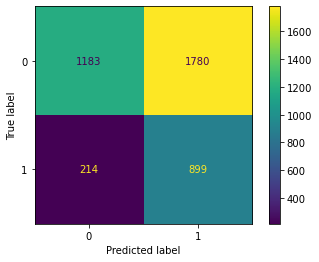

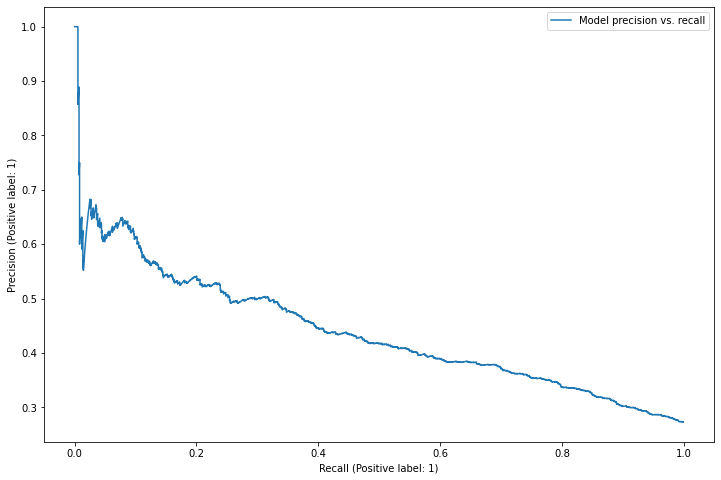

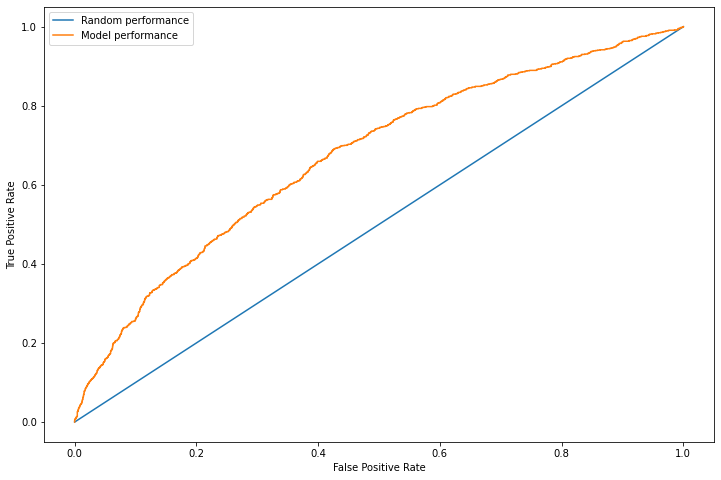

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Adagrad' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Adagrad20210603-0927


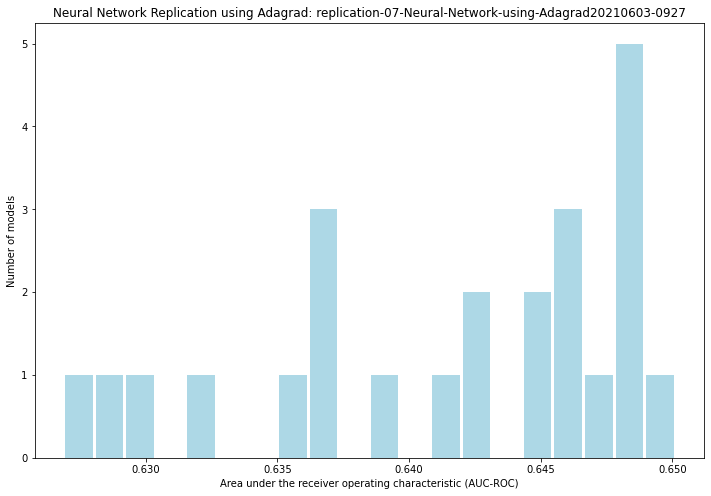

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Adagrad: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)